# BEATCF - Baseline Paper

In [175]:
import mysql.connector     #python library for connecting to server
import csv
import datetime
import decimal
import math
import statistics
import textwrap

from fuzzywuzzy import fuzz # Used to find key words from free text fields
from tabulate import tabulate
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

connection  = mysql.connector.connect(user='root', password='password123', host='127.0.0.1', database='beatcf_test')
mycursor = connection.cursor()

# Cut Off Date
cut_off = "2023-07-01"

## Derived Tables

### Beatcf enrolment paper

In [44]:
# sweat chlrone level = scl

# beatcf_enrolment_paper
mycursor.execute("""CREATE TABLE IF NOT EXISTS beatcf_enrolment_paper (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,
age_int INT,
age_category TEXT,
height DECIMAL (10, 3),
weight DECIMAL (10, 3),
BMI DECIMAL (10, 3),
sex TEXT,
genotype TEXT,
scl_NoCFTR INT,
scl_NoCFTR_1 INT,
scl_NoCFTR_2 INT,
scl_NoCFTR_3 INT,
scl_NoCFTR_Missing INT,
scl_CFTR INT,
scl_CFTR_1 INT,
scl_CFTR_2 INT,
scl_CFTR_3 INT,
scl_CFTR_Missing INT,
scl_beforeAug INT,
not_scl_beforeAug INT,
pancreatic_insufficiency INT,
cf_diab INT,
c_difficile INT,
total_ige INT,
ppfev_365 DECIMAL (10,3),
ppfev_180 DECIMAL (10,3),
high_lungfunction INT,
pseudomonas INT,
micro_sample INT,
updated_at TIMESTAMP,
PRIMARY KEY (study_id));""")

### Functions

#### Age

In [25]:
# Calculate the age (in years) when given birth_date and date which are both given in datetime.date format
def age_calculator(birth_date, date):
    # Assumes that all enrolments are done after birth_day
    age = date.year - birth_date.year
    
    # Check to see if e_day month / day preceds the birth month / day
    if date.month < birth_date.month:
        age = age - 1
        
    if date.month == birth_date.month and date.day < birth_date.day:
        age = age - 1
    return age

# Classify age into age categories
def age_category(age):
    # Switch statement to determine which age category the age belongs to
    if 0 <= age < 6:
        age_cat = "<6y"
    elif 6 <= age < 12:
        age_cat = "6y-<12y"
    elif 12 <= age < 18:
        age_cat = "12y-<18y"
    elif 18 <= age < 30:
        age_cat = "18y-<30y"
    elif 30 <= age < 40:
        age_cat = "30y-<40y"
    elif 40 <= age:
        age_cat = ">=40y" #The unicode for greater than equals sign
    else:
        print("Negative Age Error")
    return age_cat

#### BMI

In [26]:
# BMI calculator (weight in kgs, height in cm)
def bmi_calculator(weight, height):
    if weight != None and height != None:
        BMI = weight / ((height/100) ** 2)
        return(BMI)
    else:
        return None

#### ppFEV

In [27]:
# Spirometry Calculation (ppFEV1)

# Male / Female splines
male_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\LookupTable_Male.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        male_data.append(row)
        
female_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\LookupTable_Female.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        female_data.append(row)
        
# Create Male and Female Dictionaries for spline
Male_Dict = {}
Female_Dict = {}
for a in range (1, len(male_data)): #Remove headers
    Male_Dict[float(male_data[a][0])] = float(male_data[a][1])
    
for a in range (1, len(female_data)):
    Female_Dict[float(female_data[a][0])] = float(female_data[a][1])
    
#Round to the nearest 0.25 increment
def myround(x, base=0.25):
    return base * round(x/base)

def ppfev(fev1result, fev1date, birthdate, sex, height):
    age = fev1date - birthdate
    rounded_age = myround(age.days/365.2425) # 365.2425 days in a year
    if sex == 1:
        #print("Male: ", study_id, rounded_age, Male_Dict[rounded_age], fev1_height)
        #Male Coefficients
        spline = Male_Dict[rounded_age]
        a_0 = -10.342
        a_1 = 2.2196
        a_2 = 0.0574
    elif sex == 2:
        #print("Female: ", study_id, rounded_age, Female_Dict[rounded_age], fev1_height)
        #Female Coefficients
        spline = Female_Dict[rounded_age]
        a_0 = -9.6987
        a_1 = 2.1211
        a_2 = -0.027
    else:
        print("Sex Error: {}".format(sex))
        
    #Calculate the predicted fev1 for patient
    pred_fev1 = math.exp(a_0 + (a_1 * math.log(height)) + (a_2 * math.log(age.days/365.2425)) + spline)
    ppfev_result = float(fev1result) / pred_fev1 * 100
    
    return ppfev_result

#### Sex


In [28]:
# Determine the sex based on the coding from Research Path
def sex_category(sex):
    if sex == 1:
        sex_string = "Male"
    elif sex == 2:
        sex_string = "Female"
    elif sex == 3:
        sex_string = "Other"
    else:
        print("Sex Error")
    return sex_string

#### Genotype

In [29]:
# Determine the Genotype. 
# If both genotype1 and genotype2 = F508del -> Homozygous F508del
# If one of genotype1 or genotype2 = F508del -> Heterozygous F508del
# If neither genotype1 or genotype2 = F508del -> Other
# If genotype1 and genotype2 are missing -> NULL

def genotype_category(genotype1, genotype2):
    if genotype_1 != None and genotype_2 != None: # Ensure the subject has both genotypes
        if genotype_1 == 1 and genotype_2 == 1:
            genotype = "Homozygous F508del"
        elif genotype_1 == 1 or genotype_2 == 1:
            genotype = "Heterozygous F508del"
        else:
            genotype = "Other"
    else:
        genotype = None
    return genotype

#### Clostridium difficile

In [30]:
# Check for positive results of Clostridium difficile test at time of enrollment.

# look back is the number of years we lookback from the enrolment_date to check for positive results of C.diff
# Assumes that the database is already connected to and mycursor is active.
def cdiff_calculator(study_id, enrolment_date, lookback):
    
    enrolment_2years = enrolment_date - relativedelta(years=2)
    
    # cdprevpos - Has there been a previous POSITIVE Clostridium difficile result in the preceding 2 years? (If [cdres] = 1, Unless [previous_positive?])
    # cdprevposdat - Sample date for the previous POSITIVE faecal sample (If [cdprevpos] is Yes)
    sql_string = """SELECT cddat, cdres, cdprevpos, cdprevposdat, study_id
    FROM clostridium_difficile_test
    WHERE study_id = '{}' and cdprevpos = 1 and cdprevposdat > '{}'""".format(study_id, enrolment_2years)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()

    if len(temp_data) > 0:
        return 1 # If there is an occurance of a postive result within this time period
    else:
        return 0        

#### Total IGE

In [31]:
# Check for Total IGE from closest date to enrolment with a lookback of 2 years)

# Assumes that the database is already connected to and mycursor is active.
def ige_calculator(study_id, enrolment_date, lookback):

    enrolment_2years = enrolment_date - relativedelta(years=2)
    
    sql_string = """SELECT study_id, total_ige_date, total_ige_result, ABS(DATEDIFF({}, total_ige_date)) as datediff 
    FROM total_ige
    WHERE study_id = "{}" and total_ige_date <= '{}' and total_ige_date >= '{}'
    ORDER BY datediff LIMIT 1""".format(enrolment_date, study_id, enrolment_date, enrolment_2years)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    
    if len(temp_data) == 1:
        return float(temp_data[0][2])
    else:
        return None

#### ppFEV1

In [32]:
# Calculate the highest ppfev value within a certain time window (Lookback in days)

def ppfev_calculator(study_id, enrolment_date, lookback):
    # Get the relevant spirometry data for enrolment_365days
    sql_string = """SELECT fev1height, fev1result, fev1datetime
    FROM spirometry
    WHERE study_id = '{}' and fev1datetime < '{}' and fev1datetime > '{}'""".format(study_id, enrolment_date + datetime.timedelta(days=1), enrolment_date - relativedelta(days=lookback))
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()

    # Check to see if there are any missing height values
    temp_max = 0
    if len(temp_data) != 0:
        for b in range (0, len(temp_data)):
            fevheight = temp_data[b][0]
            fev1 = temp_data[b][1]
            fev1_date = temp_data[b][2].date() # Convert to datetime.date
            if fevheight != None:
                temp_result = ppfev(fev1, fev1_date, birth_date, sex, fevheight)
                if temp_result > temp_max:
                    temp_max = temp_result
            else:
                print("Missing fevheight")
        return temp_max
    else:
        return None

#### High Lung function

In [33]:
# Determine whether the participant has high lor low lungfunction based on their ppfev_365 and their age

def highlungfunction_classifier(ppfev_365, age_int):
    
    # High lungfunction
    if ppfev_365 != None:
        if ppfev_365 >= 70:
            high_lungfunction = 1
        else:
            high_lungfunction = 0
    else:
        if age_int <= 8: #If no spirometry + younger or equal to the age of 8 default to high_lungfunction
            high_lungfunction = 1
        else:
            high_lungfunction = None
            
    return high_lungfunction

#### Pseudonomas

In [34]:
# Detect whether the participant has presence of pseudomonas within the lookback period (lookback in years)

def pseudonomas_classifier(study_id, enrolment_date, lookback):
        
    sql_string = """SELECT *
    FROM microbiology_sample
    WHERE study_id = '{}'and sample_date <= '{}' and sample_date > '{}' and growth_detected != 0""".format(study_id, enrolment_date, enrolment_date - relativedelta(years=lookback)) # Pull out the sample records which have at least one growth detected and within the time period
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()

    pseudomonas = 0
    # Iterate through these sample data to check to see if there is any with pseudomonas
    if len(sample_data) != 0:
        for b in range (0, len(sample_data)):
            sample_id = sample_data[b][0]
            # Collect the growths collected from this sample_id
            sql_string = """SELECT study_id, organism_type
            FROM microbiology_organism
            WHERE sample_id = '{}'""".format(sample_id) # List of growths detected from this sample
            mycursor.execute(sql_string)
            temp_data = mycursor.fetchall()
                        
            #Iterate through growths to see if any of them are pseudomonas
            for c in range (0, len(temp_data)):
                temp_id = temp_data[c][0]
                organism_type = temp_data[c][1]

                # Linking Check
                if temp_id != study_id:
                    print("Study_id error")

                if organism_type == 1: # None are captured from others
                    pseudomonas = 1
            
    return pseudomonas

#### Microbiology Sample Status

In [35]:
# This function detects whether or not the participant has a microbiology sample 2 years to the time of enrolment. This is used to determine if they can be classified into the correct strata.

# 1 means the participant does have a microbiology sample (At time of enrollment)
# 0 means the participant has no microbiology samples (At time of enrollment)

def microbiology_sample_status(study_id, enrolment_date):

    sql_string = """SELECT * FROM microbiology_sample WHERE study_id = '{}' and sample_date <= '{}'""".format(study_id, enrolment_date)
    mycursor.execute(sql_string)
    tempdata = mycursor.fetchall()

    if len(tempdata) == 0:
        return 0
    else:
        return 1

#### CFTR Modulator

In [36]:
# Initiate conmeds grouping dictionary

# Create a dictionary from predefined grouping from .csv file
conmed_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\BEATCF_ConcomitantMedications_19Feb2024.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        conmed_data.append(row)
        
conmed_group = {} # Links free text with a con med grouping category

for a in range (1, len(conmed_data)): # Discard the headings of the csv
    free_text = conmed_data[a][1]
    free_text = free_text.replace("Ãƒâ€šÃ‚Â®", "").replace("ÃƒÂ¡","") # Remove unrecognized characters
    conmed_group[free_text] = conmed_data[a][4]
    
conmed_group = dict(sorted(conmed_group.items())) # Sort the dictionary alphabetically 

conmed_group_index = {} # Links cmt index with their medication name 

sql_string = """SELECT * FROM medication_name"""
mycursor.execute(sql_string)
temp_data = mycursor.fetchall()

for a in range (0, len(temp_data)):
    index = temp_data[a][0]
    medication_name = temp_data[a][1].replace("Ãƒâ€šÃ‚Â®", "").replace("ÃƒÂ¡","").replace("Â®", "") # Remove special characters
    medication_name = medication_name + "_index"
    medication_name = medication_name.lstrip(" ") # Remove the first character space from the medication names from the SQL database
    
    conmed_group_index[index] = medication_name

# Detect whether the participant has occurance of a CFTR Modulator at the time of enrolment

def CFTR_modulator_calculator(study_id, enrolment_date, datewindow):
    # List of CFTR modulators which are searched for
    CFTR_modulator_list = ['Elexacaftor/tezacaftor/ivacaftor (Trikafta)', 'Ivacaftor (Kalydeco)', 'Tezacaftor/ivacaftor and ivacaftor (symdeko)', 'Lumacaftor/ivacaftor (Orkambi)']

    # Find their concomitant_medication
    sql_string = """SELECT study_id, cmtrt, cmtrtoth, cmtrtname, cmstdat, cmongo, cmendat, cmroute
    FROM concomitant_medication
    WHERE study_id = '{}' AND cmtrt in (1013, 1014, 1015, 1026, 9998, 9999)""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    
    CFTR_modulator = 0
    if len(temp_data) != 0:
        # Check to see if the concomitant medication was active during enrolment date
        duplicate_list = [] # Check to see if there are any duplicates
        for b in range (0, len(temp_data)):
            flag = 0

            cmt_index = temp_data[b][1]
            cmt_oth = temp_data[b][2]
            cmt_name = temp_data[b][3]
            start_date = temp_data[b][4]
            end_date = temp_data[b][6]
            cmongo = temp_data[b][5]
            cmroute = temp_data[b][7]

            flag = 0
            if cmongo == 1: # If the medication is ongoing
                if start_date != None:
                    if start_date <= enrolment_date + datetime.timedelta(days=datewindow):
                        flag = 1
                else:
                    flag = 1
            elif start_date != None and end_date != None:
                if (start_date <= enrolment_date + datetime.timedelta(days=datewindow)) and (enrolment_date <= end_date):
                    flag = 1
            elif end_date == None:
                if start_date <= enrolment_date + datetime.timedelta(days=datewindow):
                    flag = 1
            elif start_date == None:
                if enrolment_date <= end_date:
                    flag = 1
            elif end_date == None and start_date == None:
                print("Data Error")
                
            # Update the correct key in the conmed_dictionary
            if flag == 1:
                if cmt_index != 9998 and cmt_index != 9999:
                    medication_index_name = conmed_group_index[cmt_index]
                    group = conmed_group[medication_index_name]
                    if group in CFTR_modulator_list:
                        CFTR_modulator = 1
                else:
                    if cmt_oth in conmed_group:
                        group = conmed_group[cmt_oth]
                        group = group.replace("Â\xa0", "") # Remove Special character from cmt_oth
                    else:
                        # Manual handeling of some special characters
                        if cmt_oth == "EscitaloprÃ¡m":
                            group = "Other"
                        else:
                            #print(cmt_oth) -> these are the medications that are not classified
                            if enrolment_date < datetime.datetime(2023,7,1).date():
                                print("Unclassified Concomitant Medication: {}".format(cmt_oth))
                            group = "Unknown"
                                
                    if group in CFTR_modulator_list:
                        CFTR_modulator = 1
                        
    return CFTR_modulator

#### Sweat chloride level

In [37]:
# Classify the sweat chlorine into categories
def sweat_chlorine_category(num):
    # Switch statement to determine which sweat chlorine category the subject belongs to
    if num < 40:
        sweat_cat = "<40"
    elif 40 <= num < 60:
        sweat_cat = "40-<60"
    elif 60 <= num:
        sweat_cat = ">=60"
    else:
        print("Error") # Should never hit this condition
    return sweat_cat

# Classify participants based on CFTR modulator, Sweat Chloride level, enrolment before Aug2022
def sweat_chlorine_breakdown(CFTR_modulator, sweat_chloride_level, enrolment_date):
    # Particpant on CFTR modulator
    if CFTR_modulator == 1:
        sweat_chlorine_cat = "CFTR modulator"
        if sweat_chloride_level != None and sweat_chloride_level != 0:
            sweat_chlorine_cat = "CFTR " + sweat_chlorine_category(sweat_chloride_level)
        else:
            sweat_chlorine_cat = "CFTR Missing"
    # Participant not on CFTR modulator
    else:
        if sweat_chloride_level != None and CFTR_modulator == 0:
            sweat_chlorine_cat = sweat_chlorine_category(sweat_chloride_level)
        else:
            sweat_chlorine_cat = "Missing"
        
    # Detect the participants with missing sweat chlorine levels who enrolled before August2022
    if sweat_chlorine_cat == "Missing" or sweat_chlorine_cat == "CFTR Missing":
        if enrolment_date < datetime.date(2022, 8, 1):
            sweat_chlorine_cat = "Enrolment before Aug2022"
    
    return sweat_chlorine_cat

### Main

In [45]:
datewindow = 28 #For sweat chloride CFTR Modulator

# Clear the data from the table
sql_string = "TRUNCATE TABLE beatcf_enrolment_paper"
mycursor.execute(sql_string)

# Select out the necessary variables for derived data.
sql_string = """SELECT A.study_id, A.birth_date, A.enrolment_date, B.Height, B.Weight, A.sex, B.genotype1, B.genotype2, B.sweat_chloride_level, B.paninsuff, B.cfdiab
FROM subject A
LEFT JOIN baseline B
ON A.study_id = B.study_id"""
mycursor.execute(sql_string)
data = mycursor.fetchall()
    
#sweat_chlorine_dic
sweat_chlorine_dic = {}
sweat_chlorine_dic["scl_NoCFTR"] = 0
sweat_chlorine_dic["<40"] = 0
sweat_chlorine_dic["40-<60"] = 0
sweat_chlorine_dic[">=60"] = 0
sweat_chlorine_dic["Missing"] = 0
sweat_chlorine_dic["scl_CFTR"] = 0
sweat_chlorine_dic["CFTR <40"] = 0
sweat_chlorine_dic["CFTR 40-<60"] = 0
sweat_chlorine_dic["CFTR >=60"] = 0
sweat_chlorine_dic["CFTR Missing"] = 0
sweat_chlorine_dic["Enrolment before Aug2022"] = 0
sweat_chlorine_dic["Enrolment after Aug2022 or scl"] = 0
    
for a in range (0, len(data)):
    study_id = data[a][0]
    birth_date = data[a][1]
    enrolment_date = data[a][2]
    height = data[a][3]
    weight = data[a][4]
    sex = data[a][5]
    genotype_1 = data[a][6]
    genotype_2 = data[a][7]
    sweat_chloride_level = data[a][8]
    pan_insuff = data[a][9] # Can cross check with creon prescription on enrolment (Complete)
    cf_diab = data[a][10] # Can cross check with insulin prescription on enrolment (Complete)
    
    # calculate the age at enrolment (in years)
    age_int = age_calculator(birth_date, enrolment_date)
    
    # classify the age category at the time of enrolment
    age_cat = age_category(age_int)
    
    # calculate the BMI
    BMI = bmi_calculator(weight, height)
    
    # Convert sex index to a string
    sex_string = sex_category(sex)
        
    # Previous iteration of genotype classification
    genotype = genotype_category(genotype_1, genotype_2)
    
    # We only know if a subject has c.diff if they have another test and then look back 2 years from enrolment date.
    enrolment_2years = enrolment_date - relativedelta(years=2) # Look back 2 years. If the date is Feb 29 then this pushes back Feb 28.
    
    # Check for positive results of c.diff test within 2 years of enrolment
    c_difficile = cdiff_calculator(study_id, enrolment_date, 2)
    
    # Find total IGE that is closest to enrolment date and is within 2 years of enrolment
    total_ige = ige_calculator(study_id, enrolment_date, 2)

    # Get the maximum ppfev value for the 365 days before enrolment date. (enrolment date included)
    ppfev_365 = ppfev_calculator(study_id, enrolment_date, 365)
        
    # Get the maximum ppfev value for the 180 days before enrolment date. (enrolment date included)
    ppfev_180 = ppfev_calculator(study_id, enrolment_date, 180)
      
    # Determine if participant is considered high or low lung function.
    high_lungfunction = highlungfunction_classifier(ppfev_365, age_int)
      
    # Detemine if participant has record of pseudomonas within 2 years of enrolment date.
    pseudomonas = pseudonomas_classifier(study_id, enrolment_date, 2)
    
    # Check to see if the participant had a record of a microbiology sample
    sample_status = microbiology_sample_status(study_id, enrolment_date)
                        
    # Classify Stratum
    if high_lungfunction != None and sample_status == 1:
        if high_lungfunction == 1 and pseudomonas == 1:
            strata = "HighLungfunction+Pseudomonas"
        elif high_lungfunction == 1 and pseudomonas == 0:
            strata = "HighLungfunction+NoPseudomonas"
        elif high_lungfunction == 0 and pseudomonas == 1:
            strata = "LowLungfunction+Pseudomonas"
        elif high_lungfunction == 0 and pseudomonas == 0:
            strata = "LowLungfunction+NoPseudomonas"
        else:
            print("Stratum Error")
    else:
        strata = "N/A"
        
    # Classify the missing baseline subjects as None
    if study_id == "009-0065":
        strata = None

    # Determine if the participant is on a CFTR_modulator on enrolment with an extended datewindow after this date (days)
    CFTR_modulator = CFTR_modulator_calculator(study_id, enrolment_date, 0)
                           
    # Determine the sweat chlorine category
    sweat_chlorine_cat = sweat_chlorine_breakdown(CFTR_modulator, sweat_chloride_level, enrolment_date)
    
    # Reset Dictionary
    for key in sweat_chlorine_dic:
        sweat_chlorine_dic[key] = 0
        
    # Transform category to binary fields
    # Total Counts
    # If the first 4 letters of the sweat_chlorine_cat == "CFTR"
    if sweat_chlorine_cat[:4] == "CFTR":
        sweat_chlorine_dic["scl_CFTR"] = 1
    else:
        if sweat_chlorine_cat != "Enrolment before Aug2022":
            sweat_chlorine_dic["scl_NoCFTR"] = 1
            
    # Record binary for 
    if sweat_chlorine_cat != "Enrolment before Aug2022":    
        sweat_chlorine_dic["Enrolment after Aug2022 or scl"] = 1
    
    sweat_chlorine_dic[sweat_chlorine_cat] = 1
        
    sql_variables = [study_id, enrolment_date, strata, age_int, age_cat, height, weight, BMI, sex_string, genotype,sweat_chlorine_dic["scl_NoCFTR"], sweat_chlorine_dic["<40"],sweat_chlorine_dic["40-<60"],sweat_chlorine_dic[">=60"],sweat_chlorine_dic["Missing"],sweat_chlorine_dic["scl_CFTR"],sweat_chlorine_dic["CFTR <40"],sweat_chlorine_dic["CFTR 40-<60"],sweat_chlorine_dic["CFTR >=60"],sweat_chlorine_dic["CFTR Missing"],sweat_chlorine_dic["Enrolment before Aug2022"], sweat_chlorine_dic["Enrolment after Aug2022 or scl"], pan_insuff, cf_diab, c_difficile, total_ige, ppfev_365, ppfev_180, high_lungfunction, pseudomonas, sample_status]
    #Write the MySQL insert string for this study_id
    sql_string = """INSERT IGNORE INTO beatcf_enrolment_paper (study_id, enrolment_date, stratum, age_int, age_category, height, weight, BMI, sex, genotype, scl_NoCFTR ,scl_NoCFTR_1 ,scl_NoCFTR_2 ,scl_NoCFTR_3 ,scl_NoCFTR_Missing ,scl_CFTR ,scl_CFTR_1 ,scl_CFTR_2 ,scl_CFTR_3 ,scl_CFTR_Missing ,scl_beforeAug, not_scl_beforeAug, pancreatic_insufficiency, cf_diab, c_difficile, total_ige, ppfev_365, ppfev_180, high_lungfunction, pseudomonas, micro_sample, updated_at)VALUES ("""

    for b in range (0, len(sql_variables)):
        if sql_variables[b] == None:
            sql_string = sql_string + 'NULL,'
        else:
            sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
    sql_string = sql_string + "NOW())"
    mycursor.execute(sql_string)
    connection.commit()
    
print("Finished")

Finished


### CFQR

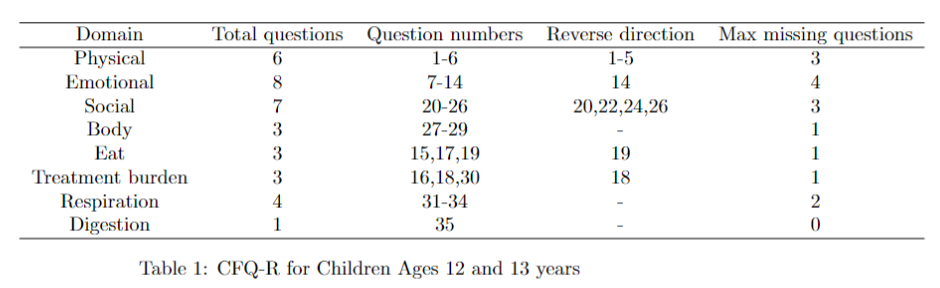
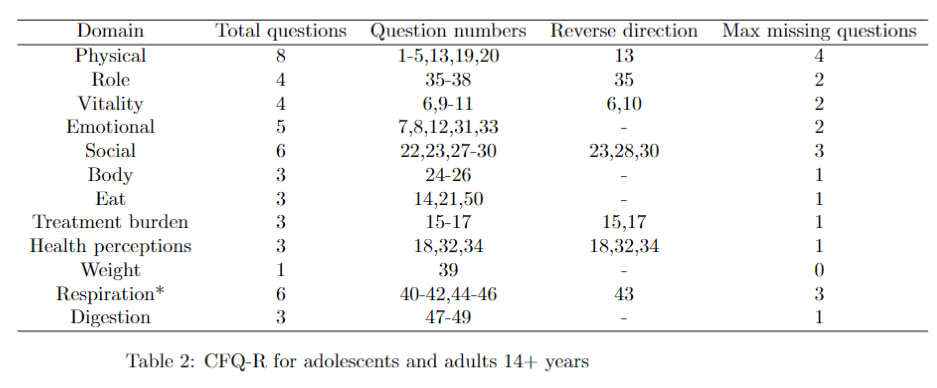
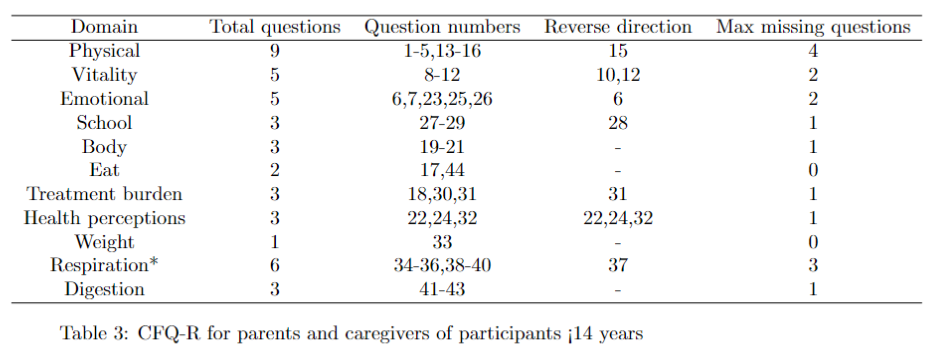

In [47]:
# CFQR Question domains
# cfqr ages12 and 13
cfqr1213_question_numbers = {}
cfqr1213_question_numbers["Physical"] = [1,2,3,4,5,6]
cfqr1213_question_numbers["Emotional"] = [7,8,9,10,11,12,13,14]
cfqr1213_question_numbers["Social"] = [20,21,22,23,24,25,26]
cfqr1213_question_numbers["Body"] = [27,28,29]
cfqr1213_question_numbers["Eat"] = [15,17,19]
cfqr1213_question_numbers["Treatment Burden"] = [16,18,30]
cfqr1213_question_numbers["Respiration"] = [31,32,33,34]
cfqr1213_question_numbers["Digestion"] = [35]

# cfqr adolescents and adults
cfqradol_question_numbers = {}
cfqradol_question_numbers["Physical"] = [1,2,3,4,5,13,19,20]
cfqradol_question_numbers["Role"] = [35,36,37,38]
cfqradol_question_numbers["Vitality"] = [6,9,10,11]
cfqradol_question_numbers["Emotional"] = [7,8,12,31,33]
cfqradol_question_numbers["Social"] = [22,23,27,28,29,30]
cfqradol_question_numbers["Body"] = [24,25,26]
cfqradol_question_numbers["Eat"] = [14,21,50]
cfqradol_question_numbers["Treatment Burden"] = [15,16,17]
cfqradol_question_numbers["Health Perceptions"] = [18,32,35]
cfqradol_question_numbers["Weight"] = [39]
cfqradol_question_numbers["Respiration"] = [40,41,42,44,45,46]
cfqradol_question_numbers["Digestion"] = [47,48,49]

# cfqr parents and caregivers
cfqrparents_question_numbers = {}
cfqrparents_question_numbers["Physical"] = [1,2,3,4,5,13,14,15,16]
cfqrparents_question_numbers["Vitality"] = [8,9,10,11,12]
cfqrparents_question_numbers["Emotional"] = [6,7,23,25,26]
cfqrparents_question_numbers["School"] = [27,28,29]
cfqrparents_question_numbers["Body"] = [19,20,21]
cfqrparents_question_numbers["Eat"] = [17,44]
cfqrparents_question_numbers["Treatment Burden"] = [18,30,31]
cfqrparents_question_numbers["Health Perceptions"] = [22,24,32]
cfqrparents_question_numbers["Weight"]  = [33]
cfqrparents_question_numbers["Respiration"] = [34,35,36,38,39,40]
cfqrparents_question_numbers["Digestion"] = [41,42,43]

# Record all of the CFQR Questions

CFQR_adoladult_questions = {}
CFQR_adoladult_questions[1] = "Performing vigorous activities such as running or playing sports"
CFQR_adoladult_questions[2] = "Walking as fast as others"
CFQR_adoladult_questions[3] = "Carrying or lifting heavy things such as books, shopping, or school bags"
CFQR_adoladult_questions[4] = "Climbing one flight of stairs"
CFQR_adoladult_questions[5] = "Climbing stairs as fast as others"
CFQR_adoladult_questions[6] = "You felt well"
CFQR_adoladult_questions[7] = "You felt worried"
CFQR_adoladult_questions[8] = "You felt useless"
CFQR_adoladult_questions[9] = "You felt tired"
CFQR_adoladult_questions[10] = "You felt full of energy"
CFQR_adoladult_questions[11] = "You felt exhausted"
CFQR_adoladult_questions[12] = "You felt sad"
CFQR_adoladult_questions[13] = "To what extent do you have difficulty walking?"
CFQR_adoladult_questions[14] = "How do you feel about eating?"
CFQR_adoladult_questions[15] = "To what extent do your treatments make your daily life more difficult?"
CFQR_adoladult_questions[16] = "How much time do you currently spend each day on your treatments?"
CFQR_adoladult_questions[17] = "How difficult is it for you to do your treatments (including medications) each day?"
CFQR_adoladult_questions[18] = "How do you think your health is now?"
CFQR_adoladult_questions[19] = "I have trouble recovering after physical effort"
CFQR_adoladult_questions[20] = "I have to limit vigorous activities such as running or playing sports"
CFQR_adoladult_questions[21] = "I have to force myself to eat"
CFQR_adoladult_questions[22] = "I have to stay at home more than I want to"
CFQR_adoladult_questions[23] = "I feel comfortable discussing my illness with others"
CFQR_adoladult_questions[24] = "I think I am too thin"
CFQR_adoladult_questions[25] = "I think I look different from others my age"
CFQR_adoladult_questions[26] = "I feel bad about my physical appearance"
CFQR_adoladult_questions[27] = "People are afraid that I may be contagious"
CFQR_adoladult_questions[28] = "I get together with my friends a lot"
CFQR_adoladult_questions[29] = "I think my coughing bothers others"
CFQR_adoladult_questions[30] = "I feel comfortable going out at night"
CFQR_adoladult_questions[31] = "I often feel lonely"
CFQR_adoladult_questions[32] = "I feel healthy"
CFQR_adoladult_questions[33] = "It is difficult to make plans for the future (for example, going to college, getting married, getting promoted at work, etc.)"
CFQR_adoladult_questions[34] = "I lead a normal life"
CFQR_adoladult_questions[35] = "To what extent did you have trouble keeping up with your schoolwork, professional work, or other daily activities during the past two weeks?"
CFQR_adoladult_questions[36] = "How often were you absent from school, work, or unable to complete daily activities during the last two weeks because of your illness or treatments?"
CFQR_adoladult_questions[37] = "How often does CF get in the way of meeting your school, work, or personal goals?"
CFQR_adoladult_questions[38] = "How often does CF interfere with getting out of the house to run errands such as shopping or going to the bank?"
CFQR_adoladult_questions[39] = "Have you had trouble gaining weight?"
CFQR_adoladult_questions[40] = "Have you been congested?"
CFQR_adoladult_questions[41] = "Have you been coughing during the day?"
CFQR_adoladult_questions[42] = "Have you had to cough up mucus?"
CFQR_adoladult_questions[43] = "Has your mucus been mostly:"
CFQR_adoladult_questions[44] = "Have you been wheezing?"
CFQR_adoladult_questions[45] = "Have you had trouble breathing?"
CFQR_adoladult_questions[46] = "Have you woken up during the night because you were coughing?"
CFQR_adoladult_questions[47] = "Have you had problems with wind?"
CFQR_adoladult_questions[48] = "Have you had diarrhea?"
CFQR_adoladult_questions[49] = "Have you had abdominal pain?"
CFQR_adoladult_questions[50] = "Have you had eating problems?"

CFQR_1213_questions = {}
CFQR_1213_questions[1] = "You were able to walk as fast as others"
CFQR_1213_questions[2] = "You were able to climb stairs as fast as others"
CFQR_1213_questions[3] = "You were able to run, jump, and climb as you wanted"
CFQR_1213_questions[4] = "You were able to run as quickly and for as long as others"
CFQR_1213_questions[5] = "You were able to participate in sports that you enjoy (e.g., swimming, football, dancing or others)"
CFQR_1213_questions[6] = "You had difficulty carrying or lifting heavy things such as books, your school bag, or a backpack"
CFQR_1213_questions[7] = "You felt tired"
CFQR_1213_questions[8] = "You felt mad"
CFQR_1213_questions[9] = "You felt grouchy"
CFQR_1213_questions[10] = "You felt worried"
CFQR_1213_questions[11] = "You felt sad"
CFQR_1213_questions[12] = "You had trouble falling asleep"
CFQR_1213_questions[13] = "You had bad dreams or nightmares"
CFQR_1213_questions[14] = "You felt good about yourself"
CFQR_1213_questions[15] = "You had trouble eating"
CFQR_1213_questions[16] = "You had to stop fun activities to do your treatments"
CFQR_1213_questions[17] = "You were forced to eat"
CFQR_1213_questions[18] = "You were able to do all of your treatments"
CFQR_1213_questions[19] = "You enjoyed eating"
CFQR_1213_questions[20] = "You got together with friends a lot"
CFQR_1213_questions[21] = "You stayed at home more often than you wanted to"
CFQR_1213_questions[22] = "You felt comfortable sleeping away from home (at a friend of family member's house or elsewhere)"
CFQR_1213_questions[23] = "You felt left out"
CFQR_1213_questions[24] = "You often invited friends to your house"
CFQR_1213_questions[25] = "You were teased by other children"
CFQR_1213_questions[26] = "You felt comfortable discussion your illness with others (friends, teachers)"
CFQR_1213_questions[27] = "You thought you were too short"
CFQR_1213_questions[28] = "You thought you were too thin"
CFQR_1213_questions[29] = "You thought you were physically different from others your age"
CFQR_1213_questions[30] = "Doing your treatments bothered you"
CFQR_1213_questions[31] = "You coughed during the day"
CFQR_1213_questions[32] = "You woke up during the night because you were coughing"
CFQR_1213_questions[33] = "You had to cough up mucus"
CFQR_1213_questions[34] = "You had trouble breathing"
CFQR_1213_questions[35] = "Your stomach hurt"

CFQR_parent_questions = {}
CFQR_parent_questions[1] = "Performing vigorous activities such as running or playing sports"
CFQR_parent_questions[2] = "Walking as fast as others"
CFQR_parent_questions[3] = "Climbing stairs as fast as others"
CFQR_parent_questions[4] = "Carrying or lifting heavy objects such as books, school bag, or backpack"
CFQR_parent_questions[5] = "Climbing several flights of stairs"
CFQR_parent_questions[6] = "Seemed happy"
CFQR_parent_questions[7] = "Seemed worried"
CFQR_parent_questions[8] = "Seemed tired"
CFQR_parent_questions[9] = "Seemed short-tempered"
CFQR_parent_questions[10] = "Seemed well"
CFQR_parent_questions[11] = "Seemed grouchy"
CFQR_parent_questions[12] = "Seemed full of energy"
CFQR_parent_questions[13] = "Was absent or late for school or other activites because of his/her illness or treatments"
CFQR_parent_questions[14] = "The extent to which your child participated in sports and other physical activities, such as P.E. (physical education)"
CFQR_parent_questions[15] = "The extent to which your child has difficulty walking"
CFQR_parent_questions[16] = "My child has trouble recovering after physical effort"
CFQR_parent_questions[17] = "Mealtimes are a struggle"
CFQR_parent_questions[18] = "My child's treatments get in the way of his/her activities"
CFQR_parent_questions[19] = "My child feels small compared to other kids the same age "
CFQR_parent_questions[20] = "My child feels physically different from other kids the same age"
CFQR_parent_questions[21] = "My child thinks that he/she is too thin "
CFQR_parent_questions[22] = "My child feels healthy"
CFQR_parent_questions[23] = "My child tends to be withdrawn"
CFQR_parent_questions[24] = "My child leads a normal life"
CFQR_parent_questions[25] = "My child has less fun than usual"
CFQR_parent_questions[26] = "My child has trouble getting along with others"
CFQR_parent_questions[27] = "My child has trouble concentrating"
CFQR_parent_questions[28] = "My child is able to keep up with his/her school work or holiday activities"
CFQR_parent_questions[29] = "My child is not doing as well as usual in school or holiday activities"
CFQR_parent_questions[30] = "My child spends a lot of time on his/her treatments everyday"
CFQR_parent_questions[31] = "How difficult is it for your child to do his/her treatments (including medications) each day? "
CFQR_parent_questions[32] = "How do you think your child's health is now?"
CFQR_parent_questions[33] = "My child had trouble gaining weight"
CFQR_parent_questions[34] = "My child was congested"
CFQR_parent_questions[35] = "My child coughed during the day"
CFQR_parent_questions[36] = "My child had to cough up mucus"
CFQR_parent_questions[37] = "My child's mucus has been mostly:"
CFQR_parent_questions[38] = "My child wheezed"
CFQR_parent_questions[39] = "My child had trouble breathing"
CFQR_parent_questions[40] = "My child woke up during the night because he/she was coughing"
CFQR_parent_questions[41] = "My child had wind"
CFQR_parent_questions[42] = "My child had diarrhea"
CFQR_parent_questions[43] = "My child had abdominal pain"
CFQR_parent_questions[44] = "My child has had eating problems"

In [48]:
# CFQR_12_13
mycursor.execute("""CREATE TABLE IF NOT EXISTS CFQR_1213 (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,
physical DECIMAL (5,2),
emotional DECIMAL (5,2),
social DECIMAL (5,2),
body DECIMAL (5,2),
eat DECIMAL (5,2),
treatmentburden DECIMAL (5,2),
respiration DECIMAL (5,2),
digestion DECIMAL (5,2),
updated_at TIMESTAMP,
PRIMARY KEY (study_id));""")

# CFQR Adolescent and adult
mycursor.execute("""CREATE TABLE IF NOT EXISTS CFQR_adol (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,
physical DECIMAL (5,2),
role DECIMAL (5,2),
vitality DECIMAL (5,2),
emotional DECIMAL (5,2),
social DECIMAL (5,2),
body DECIMAL (5,2),
eat DECIMAL (5,2),
treatmentburden DECIMAL (5,2),
healthperceptions DECIMAL (5,2),
weight DECIMAL (5,2),
respiration DECIMAL (5,2),
digestion DECIMAL (5,2),
updated_at TIMESTAMP,
PRIMARY KEY (study_id));""")

# CFQR parents and caregivers
mycursor.execute("""CREATE TABLE IF NOT EXISTS CFQR_parent (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,
physical DECIMAL (5,2),
vitality DECIMAL (5,2),
emotional DECIMAL (5,2),
school DECIMAL (5,2),
body DECIMAL (5,2),
eat DECIMAL (5,2),
treatmentburden DECIMAL (5,2),
healthperceptions DECIMAL (5,2),
weight DECIMAL (5,2),
respiration DECIMAL (5,2),
digestion DECIMAL (5,2),
updated_at TIMESTAMP,
PRIMARY KEY (study_id));""")

In [49]:
# Clear the data from the table
sql_string = "TRUNCATE TABLE CFQR_1213"
mycursor.execute(sql_string)

# Clear the data from the table
sql_string = "TRUNCATE TABLE CFQR_adol"
mycursor.execute(sql_string)

# Clear the data from the table
sql_string = "TRUNCATE TABLE CFQR_parent"
mycursor.execute(sql_string)

sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper"""
mycursor.execute(sql_string)
cfqr_data = mycursor.fetchall()

# Rows = Domain
# Columns = Survey

Domains = ["Respiration", "Digestion", "Physical", "Emotional", "Body", "Eat", "Treatment Burden", "Role", "Vitality", "Social", "School", "Health Perceptions", "Weight"]

CFQR_results = {}
for domain in Domains:
    # Add a nested dictionary for each Domain type
    CFQR_results[domain] = {}
    
    CFQR_results[domain]["12-13"] = []
    CFQR_results[domain]["Parent/Caregiver"] = []
    CFQR_results[domain]["Adol/Adult"] = []
    
for a in range (0, len(cfqr_data)):
    
    study_id = cfqr_data[a][0]
    enrolment_date = cfqr_data[a][1]
    stratum = cfqr_data[a][2]

    # Compile a list of all the CFQR data that links with the study_ID
    cfqr_list = []

    sql_string = """SELECT *
    FROM cfqr_adolescent_adult
    WHERE study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()

    if len(temp_data) > 0:
        for b in range (0, len(temp_data)):
            cfqr_list.append(temp_data[b])

    sql_string = """SELECT *
    FROM cfqr_ages12_and13
    WHERE study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()

    if len(temp_data) > 0:
        for b in range (0, len(temp_data)):
            cfqr_list.append(temp_data[b])

    sql_string = """SELECT *
    FROM cfqr_parent_caregiver
    WHERE study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()

    if len(temp_data) > 0:
        for b in range (0, len(temp_data)):
            cfqr_list.append(temp_data[b])

    # Iterate through the cfqr_list to find the record which is closest to the date of enrolment
    temp_min = 60 # Determine which row is the closest to date of enrolment and within 30 days of enrolment
    temp_row = []
    for b in range (0, len(cfqr_list)):
        cfqr_date = cfqr_list[b][4].date()
        if (cfqr_date - enrolment_date).days < temp_min:
            temp_min = (cfqr_date - enrolment_date).days
            temp_row = cfqr_list[b][5:-4] # Only include the columns which refer to the answers to the survey question
                        
    if len(temp_row) != 0:
        if len(temp_row) == 50:
            CFQR_cat = "Adol/Adult"
        elif len(temp_row) == 44:
            CFQR_cat = "Parent/Caregiver"
        elif len(temp_row) == 35:
            CFQR_cat = "12-13"
        else:
            print("Data Length Error")
    else:
        CFQR_cat = None

    # Calculate the domains for the CFQ-R for children Ages 12 and 13 years
    # Scaled domain score = 100x(mean(domain question responses)-1) / 3
    # This code is really long and poorly written
    
    if CFQR_cat == "12-13":
        
        sql_variables = [study_id, enrolment_date, stratum]
        for key in cfqr1213_question_numbers:
            temp_list = []
            for b in range (0, len(cfqr1213_question_numbers[key])):
                temp_list.append(temp_row[cfqr1213_question_numbers[key][b]-1])
            score = 100 * (statistics.mean(temp_list) - 1) / 3
            CFQR_results[key][CFQR_cat].append(temp_list)
            sql_variables.append(score)
            
        #Write the MySQL insert string for this study_id
        sql_string = """INSERT IGNORE INTO CFQR_1213 (study_id, enrolment_date, stratum, physical, emotional, social, body, eat, treatmentburden, respiration, digestion, updated_at)VALUES ("""

        for b in range (0, len(sql_variables)):
            if sql_variables[b] == None:
                sql_string = sql_string + 'NULL,'
            else:
                sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
        sql_string = sql_string + "NOW())"
        mycursor.execute(sql_string)
        connection.commit()
        
    if CFQR_cat == "Adol/Adult":

        sql_variables = [study_id, enrolment_date, stratum]
        for key in cfqradol_question_numbers:
            temp_list = []
            for b in range (0, len(cfqradol_question_numbers[key])):
                temp_list.append(temp_row[cfqradol_question_numbers[key][b]-1])
            score = 100 * (statistics.mean(temp_list) - 1) / 3
            CFQR_results[key][CFQR_cat].append(temp_list)
            sql_variables.append(score)
            
        #Write the MySQL insert string for this study_id
        sql_string = """INSERT IGNORE INTO CFQR_adol (study_id, enrolment_date, stratum, physical, role, vitality, emotional, social, body, eat, treatmentburden, healthperceptions, weight, respiration, digestion, updated_at)VALUES ("""

        for b in range (0, len(sql_variables)):
            if sql_variables[b] == None:
                sql_string = sql_string + 'NULL,'
            else:
                sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
        sql_string = sql_string + "NOW())"
        mycursor.execute(sql_string)
        connection.commit()
        
    # CFQR parents and caregivers
    if CFQR_cat == "Parent/Caregiver":

        sql_variables = [study_id, enrolment_date, stratum]
        for key in cfqrparents_question_numbers:
            temp_list = []
            for b in range (0, len(cfqrparents_question_numbers[key])):
                temp_list.append(temp_row[cfqrparents_question_numbers[key][b]-1])
            score = 100 * (statistics.mean(temp_list) - 1) / 3
            CFQR_results[key][CFQR_cat].append(temp_list)
            sql_variables.append(score)
            
        #Write the MySQL insert string for this study_id
        sql_string = """INSERT IGNORE INTO CFQR_parent (study_id, enrolment_date, stratum, physical, vitality, emotional, school, body, eat, treatmentburden, healthperceptions, weight, respiration, digestion, updated_at)VALUES ("""

        for b in range (0, len(sql_variables)):
            if sql_variables[b] == None:
                sql_string = sql_string + 'NULL,'
            else:
                sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
        sql_string = sql_string + "NOW())"
        mycursor.execute(sql_string)
        connection.commit()        
    

#### Heatmaps

In [50]:
#CFQR_results["Respiration"]

Domains = ["Respiration", "Digestion", "Physical", "Emotional", "Body", "Eat", "Treatment Burden", "Role", "Vitality", "Social", "School", "Health Perceptions", "Weight"]
Surveys = ["12-13", "Parent/Caregiver", "Adol/Adult"]

Survey_to_question = {}
Survey_to_question["12-13"] = CFQR_1213_questions
Survey_to_question["Parent/Caregiver"] = CFQR_parent_questions
Survey_to_question["Adol/Adult"] = CFQR_adoladult_questions

Survey_to_question_num = {}
Survey_to_question_num["12-13"] = cfqr1213_question_numbers
Survey_to_question_num["Parent/Caregiver"] = cfqrparents_question_numbers
Survey_to_question_num["Adol/Adult"] = cfqradol_question_numbers

heatmap_color = {}
heatmap_color["12-13"] = "Blues"
heatmap_color["Parent/Caregiver"] = "Greens"
heatmap_color["Adol/Adult"] = "Reds"

In [ ]:
#CFQR_results[domain][survey_cat]

#### R Markdown Database

In [51]:
### Create a database that formats the results in a database that links to R Markdown

# CFQR parents and caregivers
mycursor.execute("""CREATE TABLE IF NOT EXISTS derived_CFQR_heatmaps (
domain TEXT,
survey_type TEXT,
Question_Number INT,
Question_String TEXT,
Score INT,
Value DECIMAL (5,2),
updated_at TIMESTAMP);""")

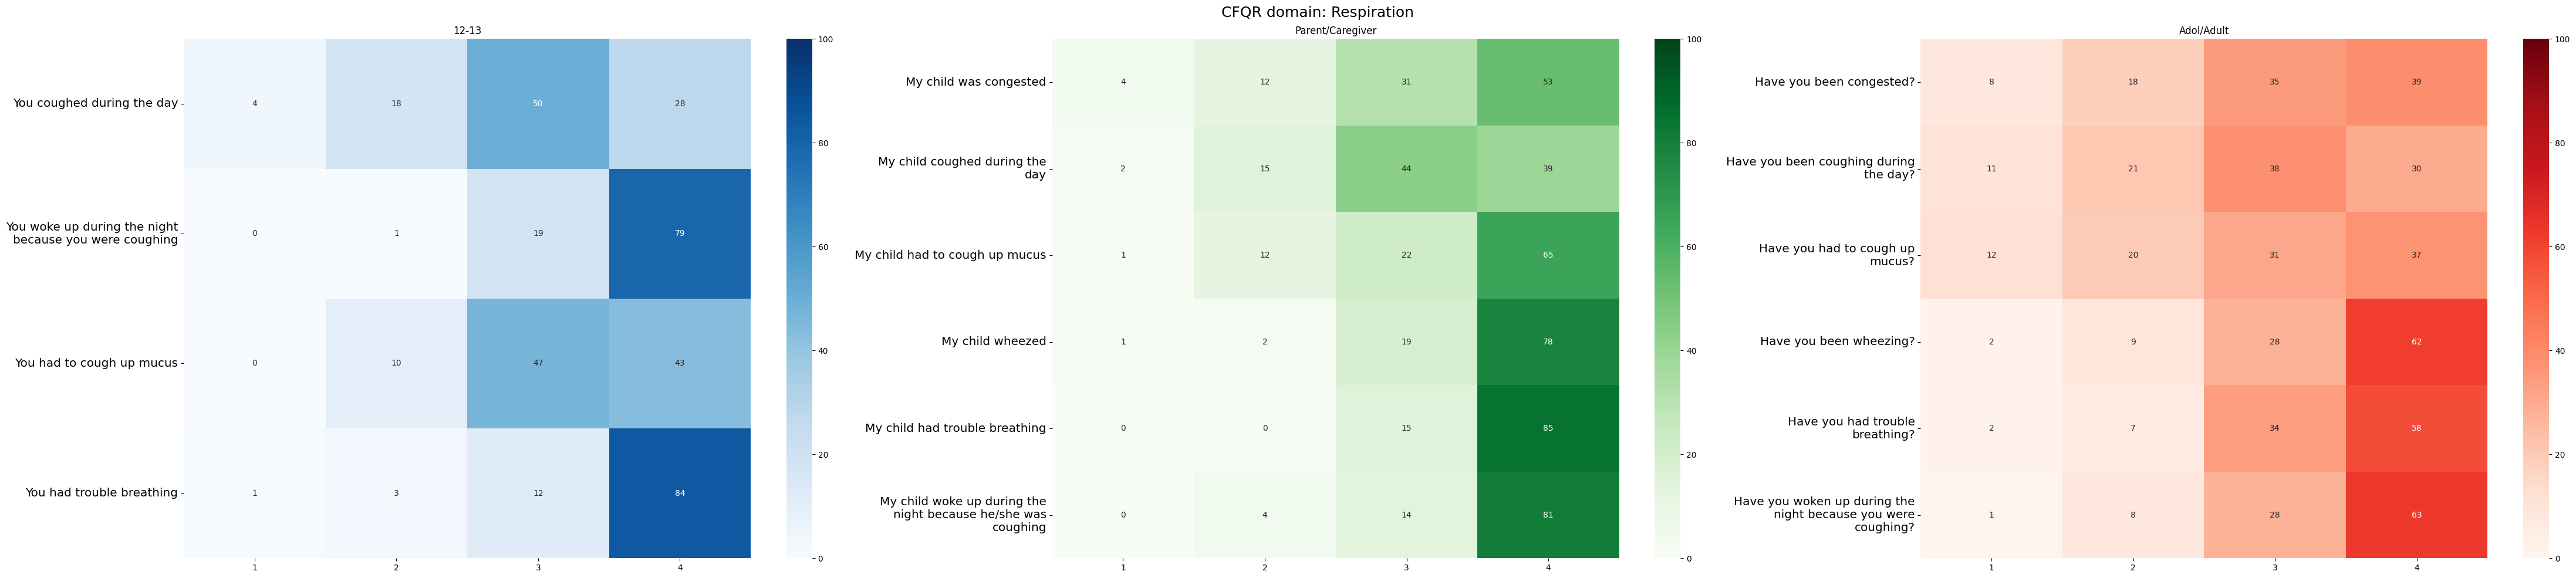

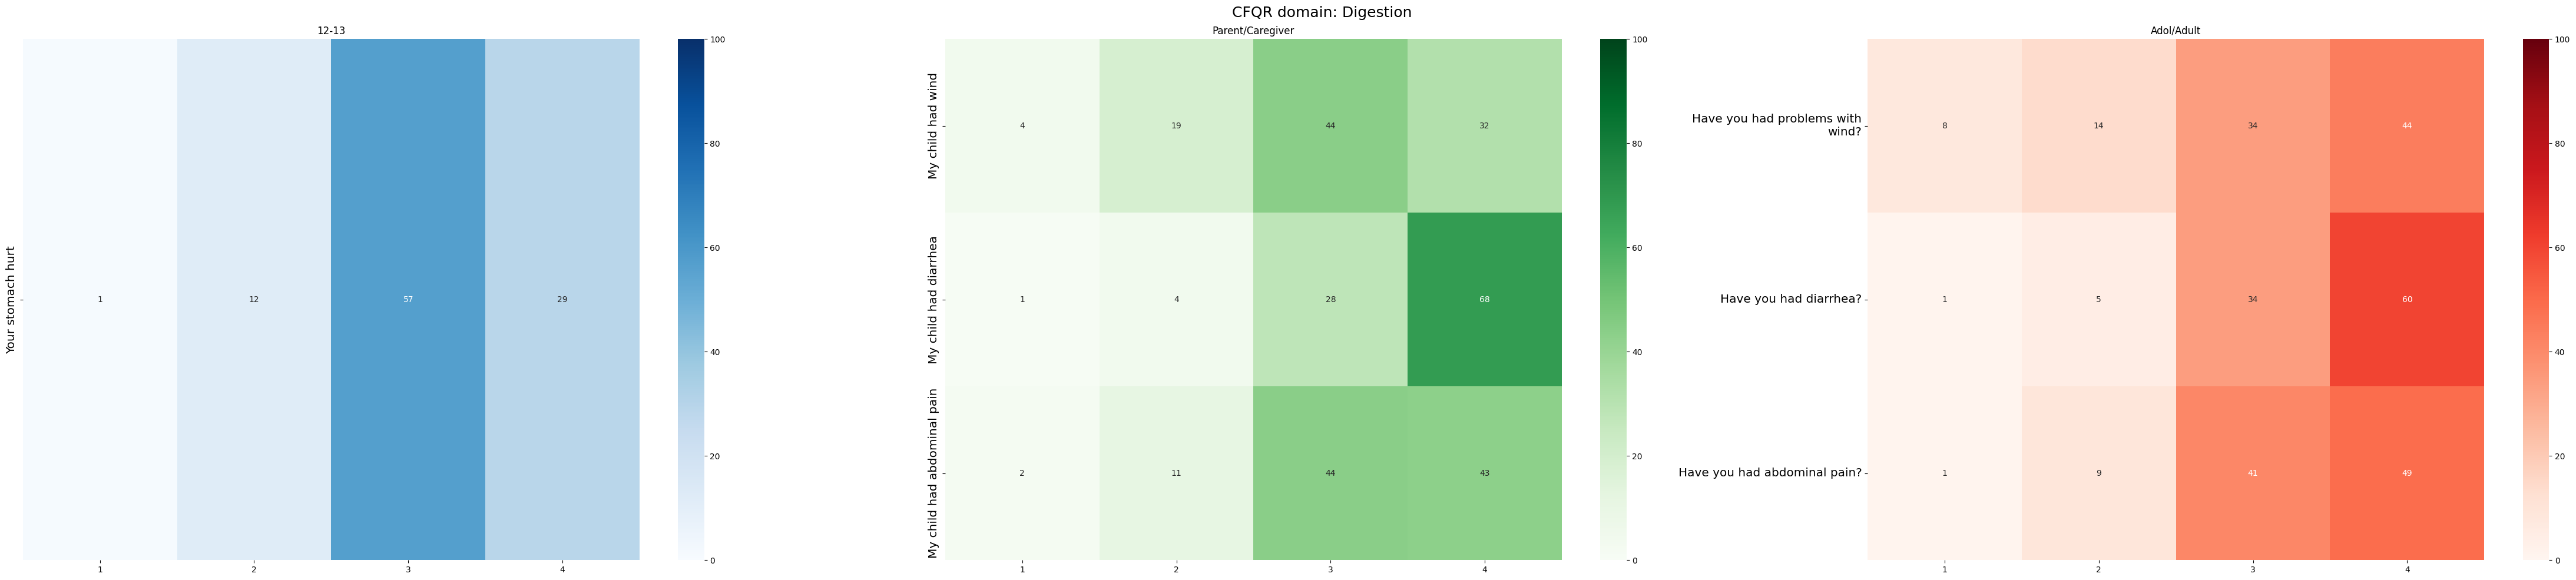

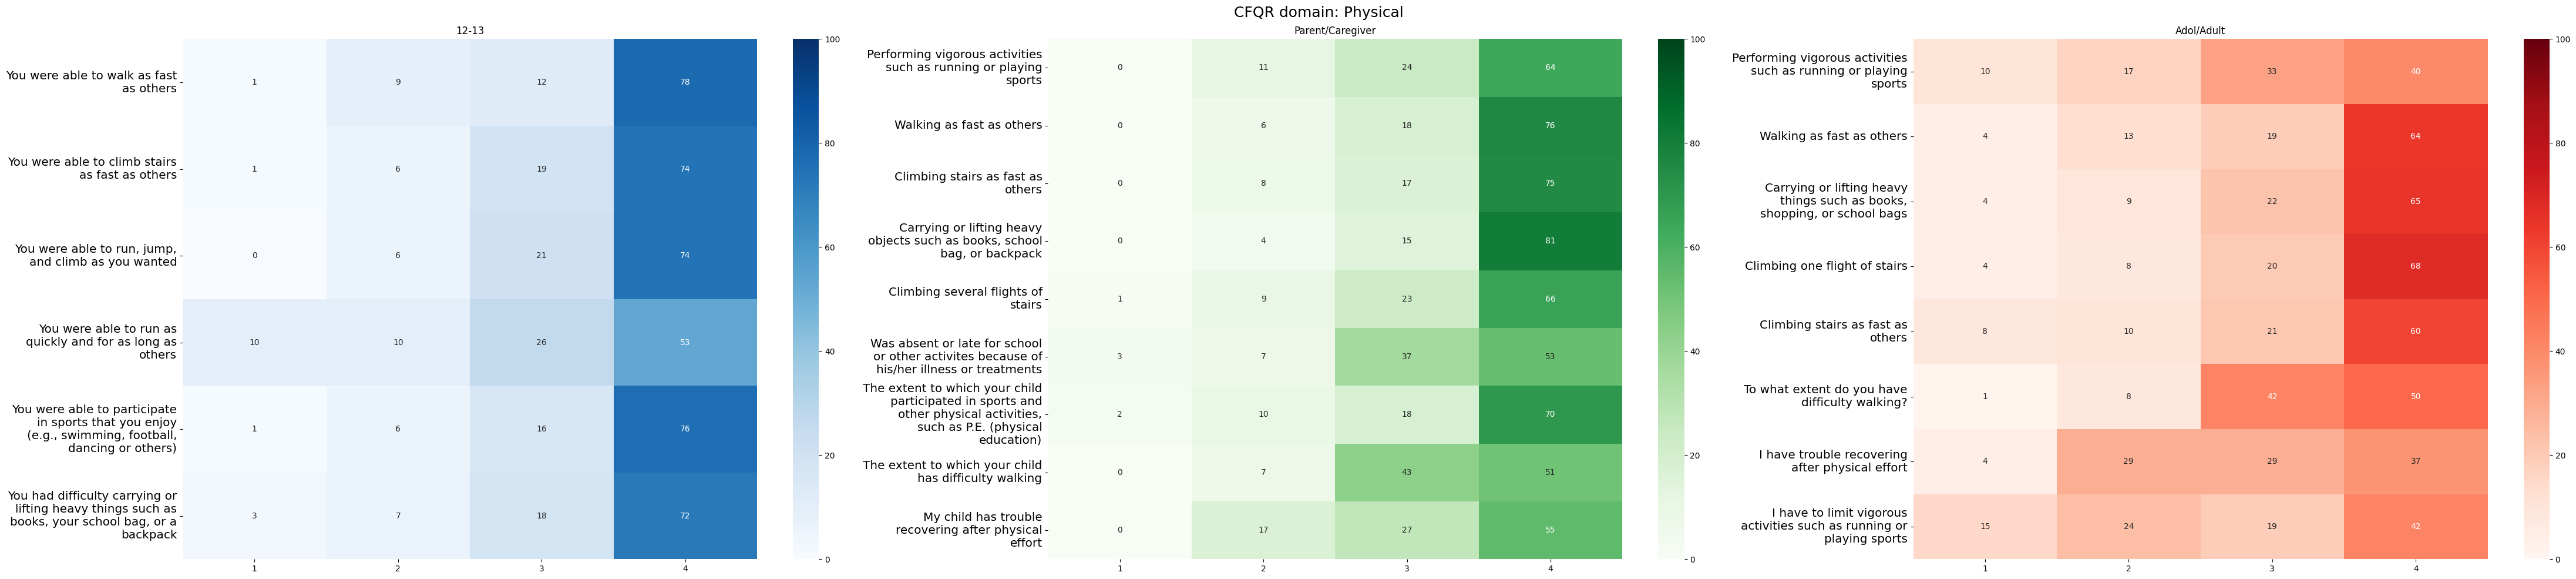

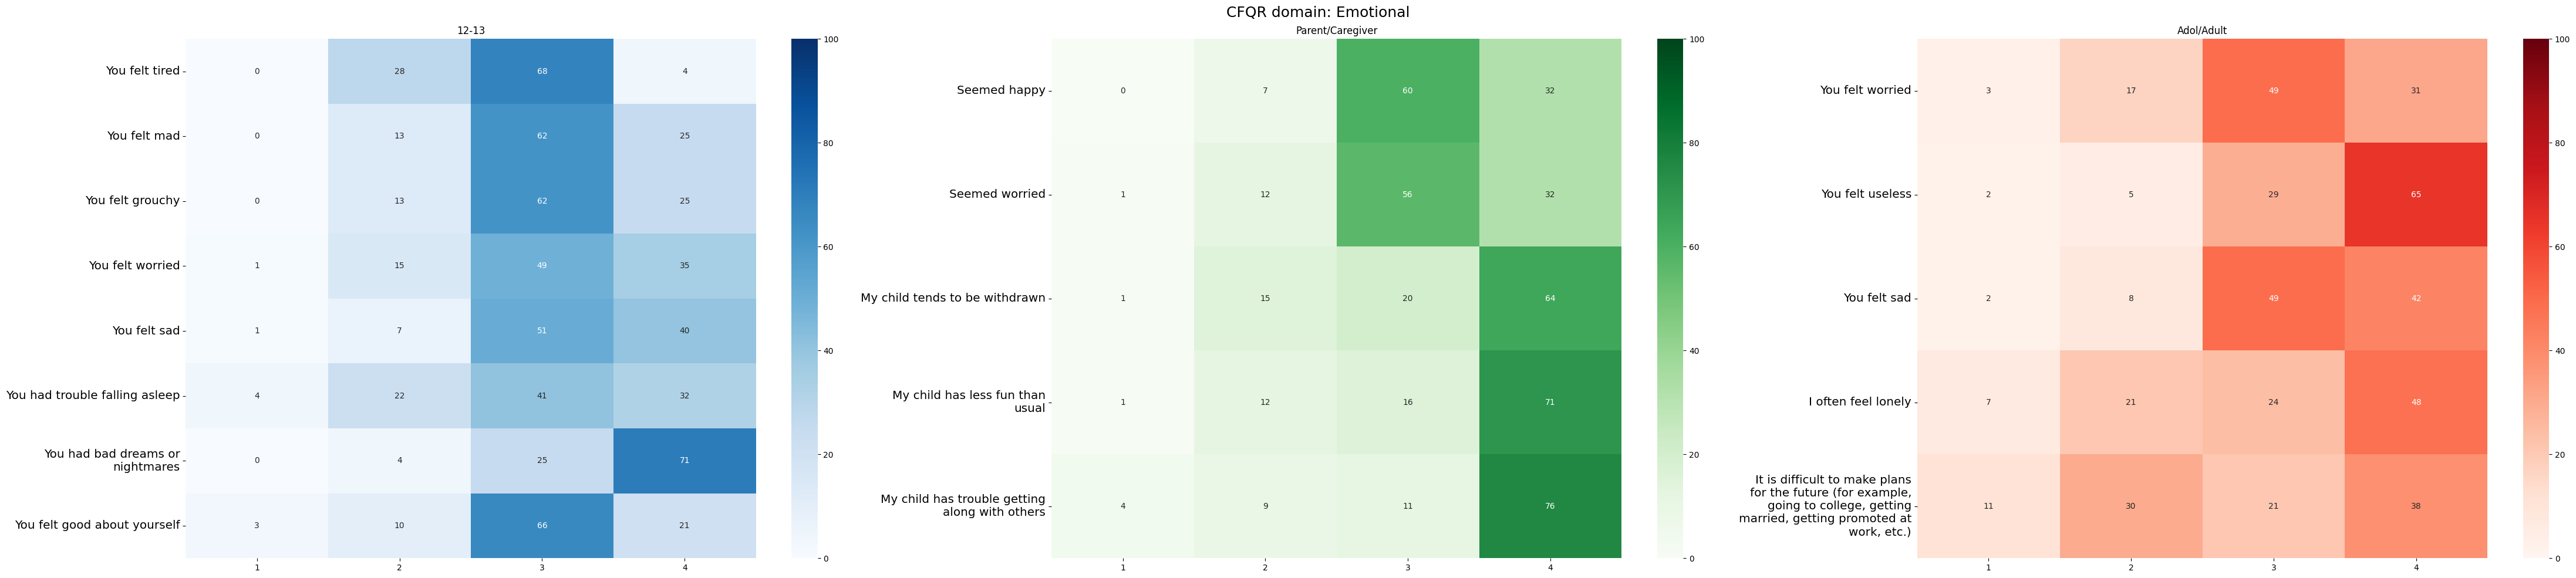

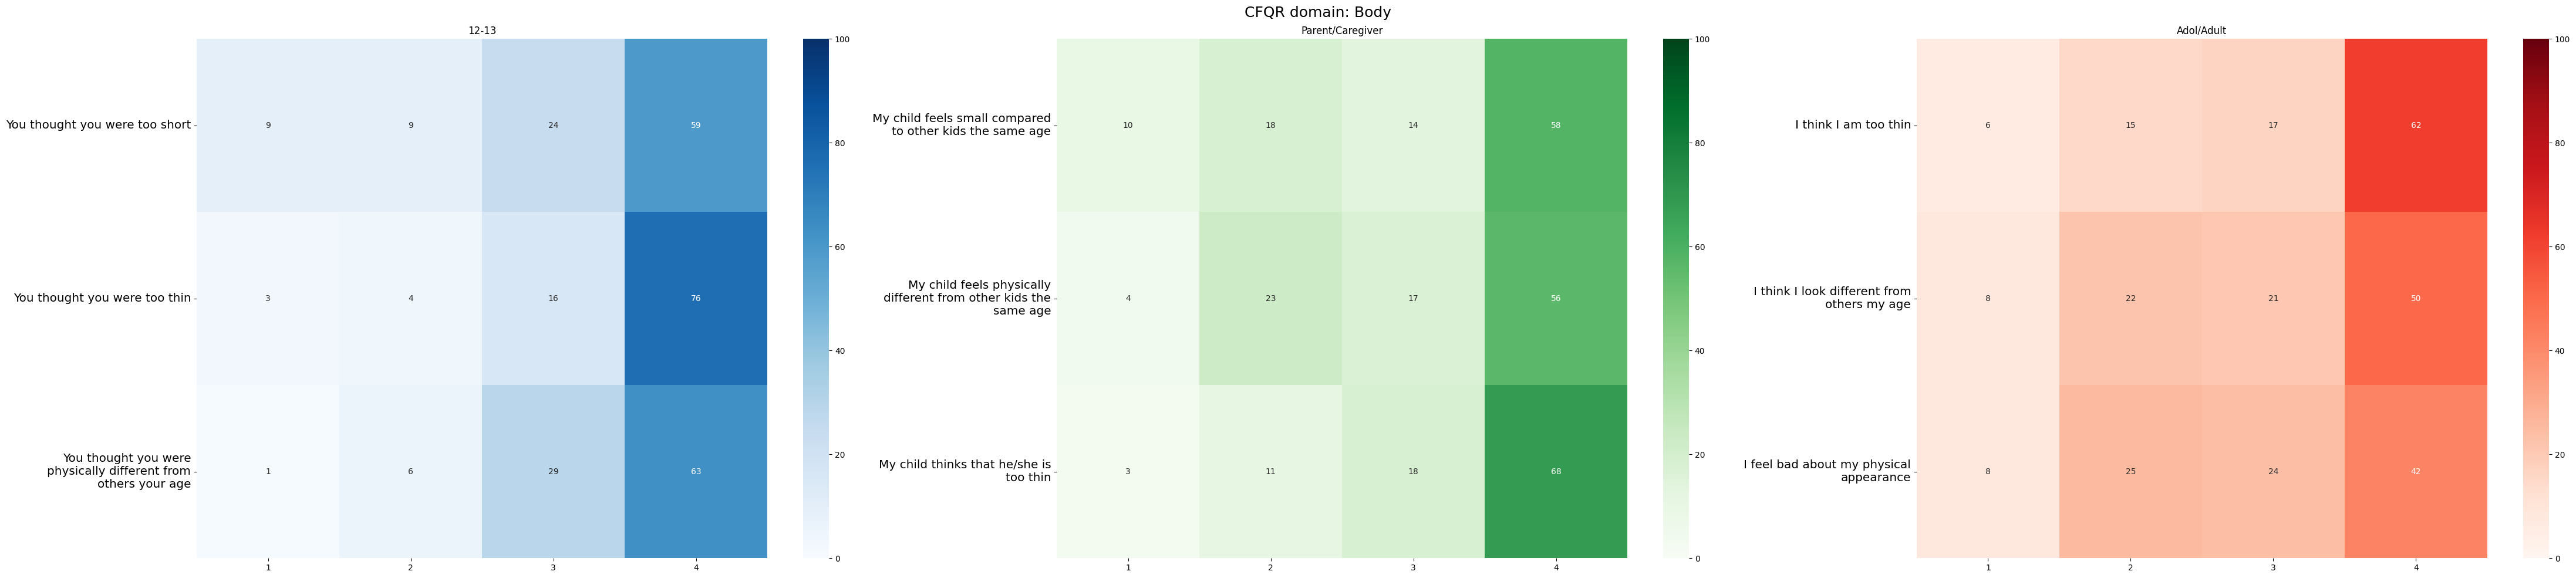

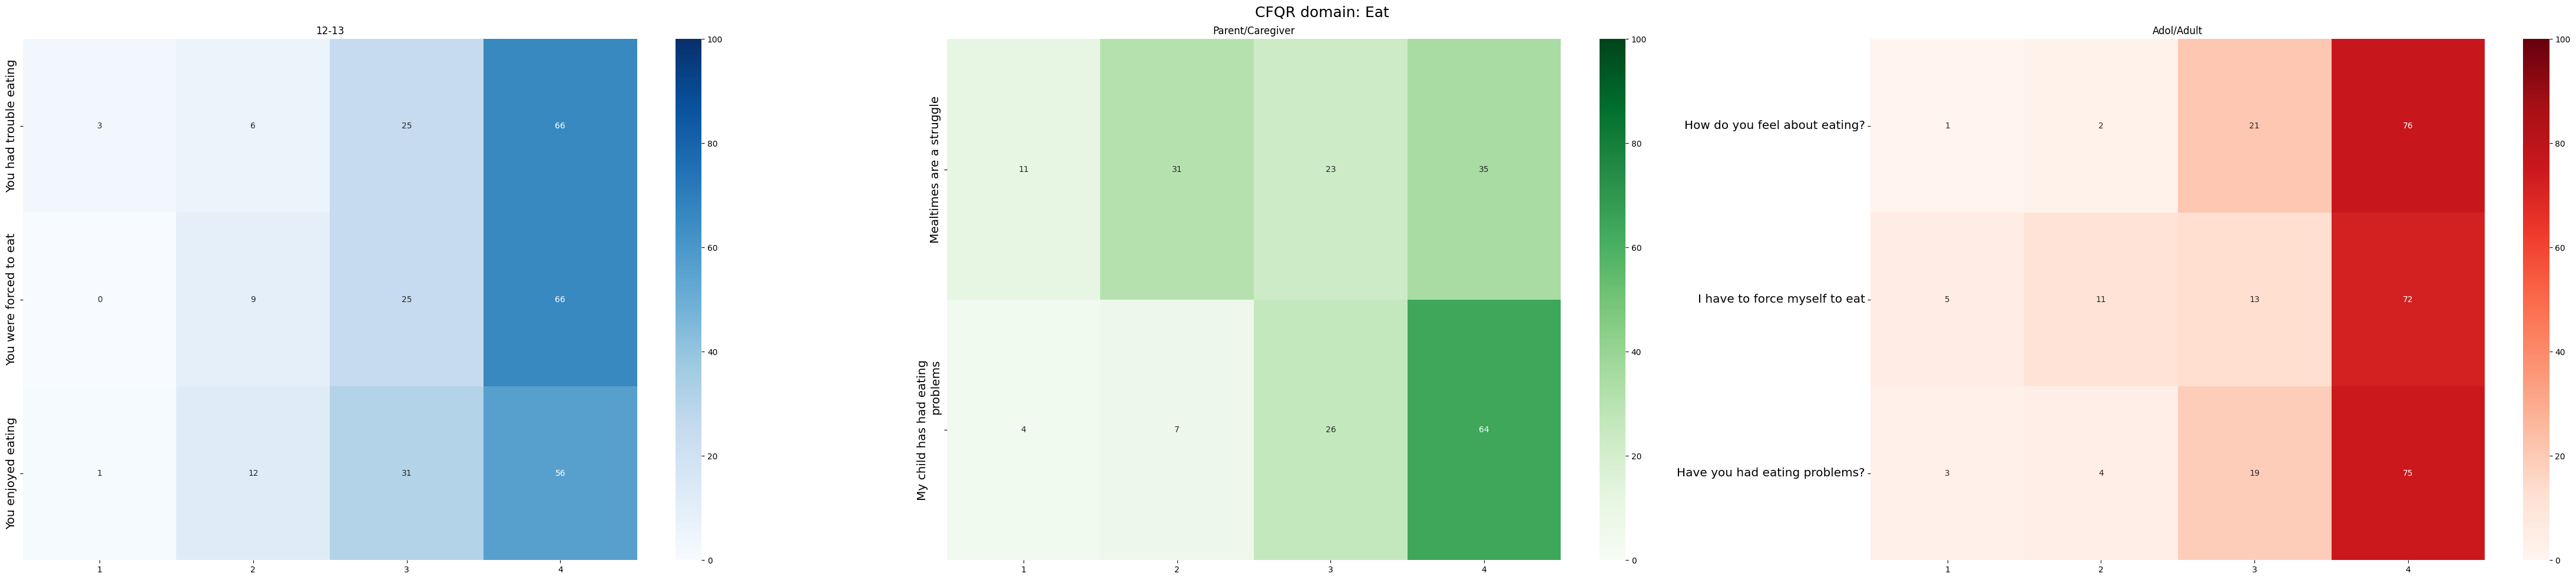

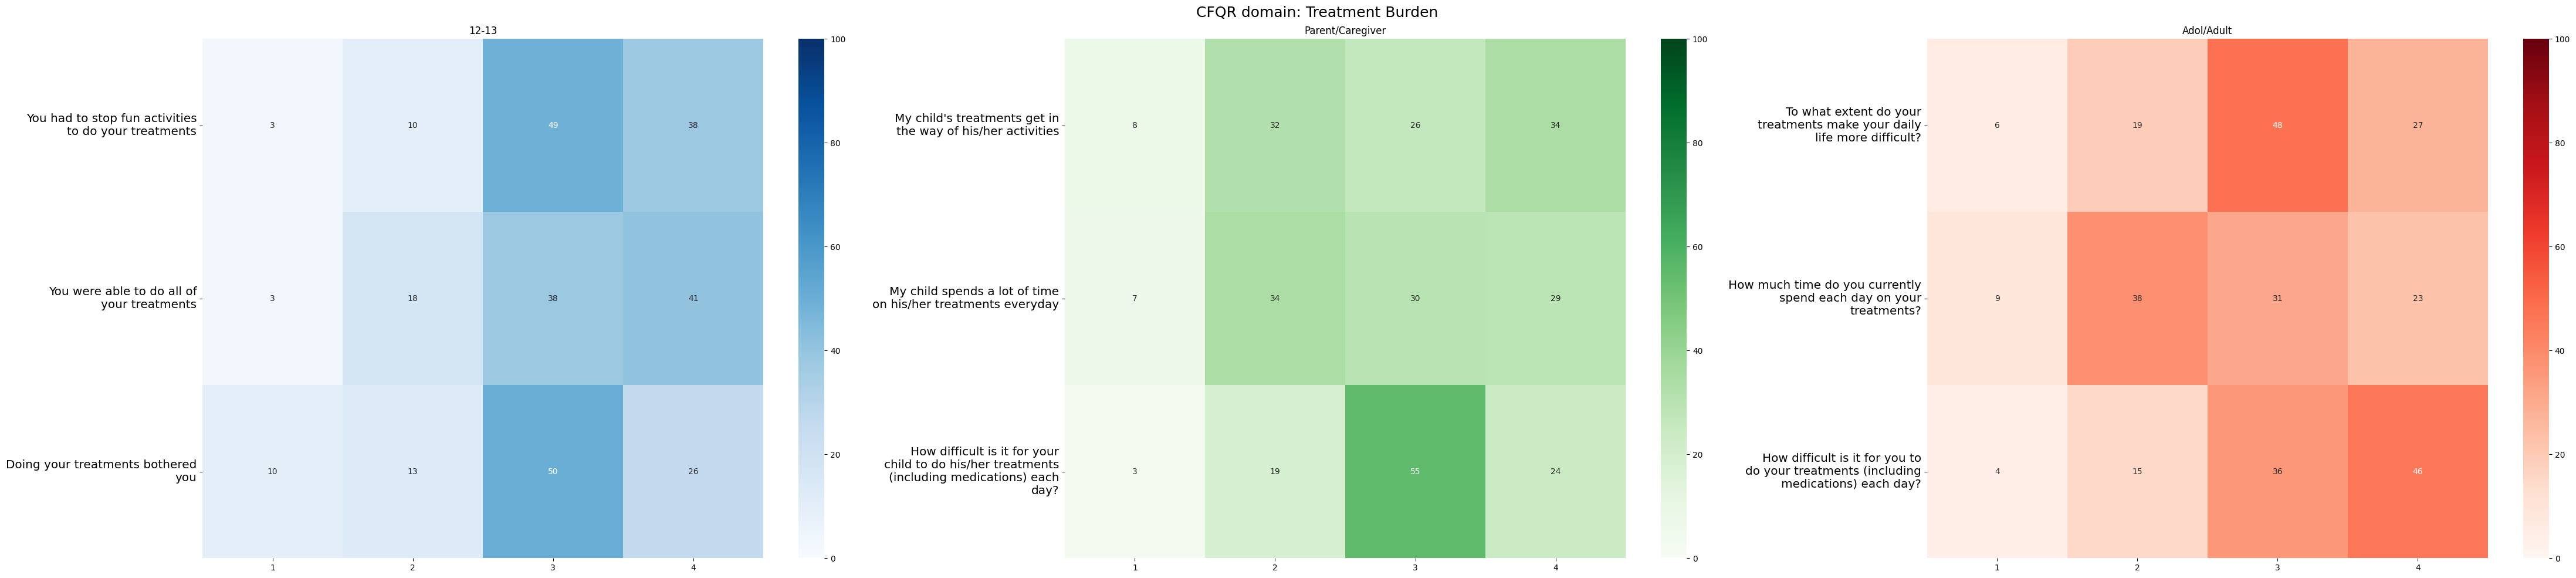

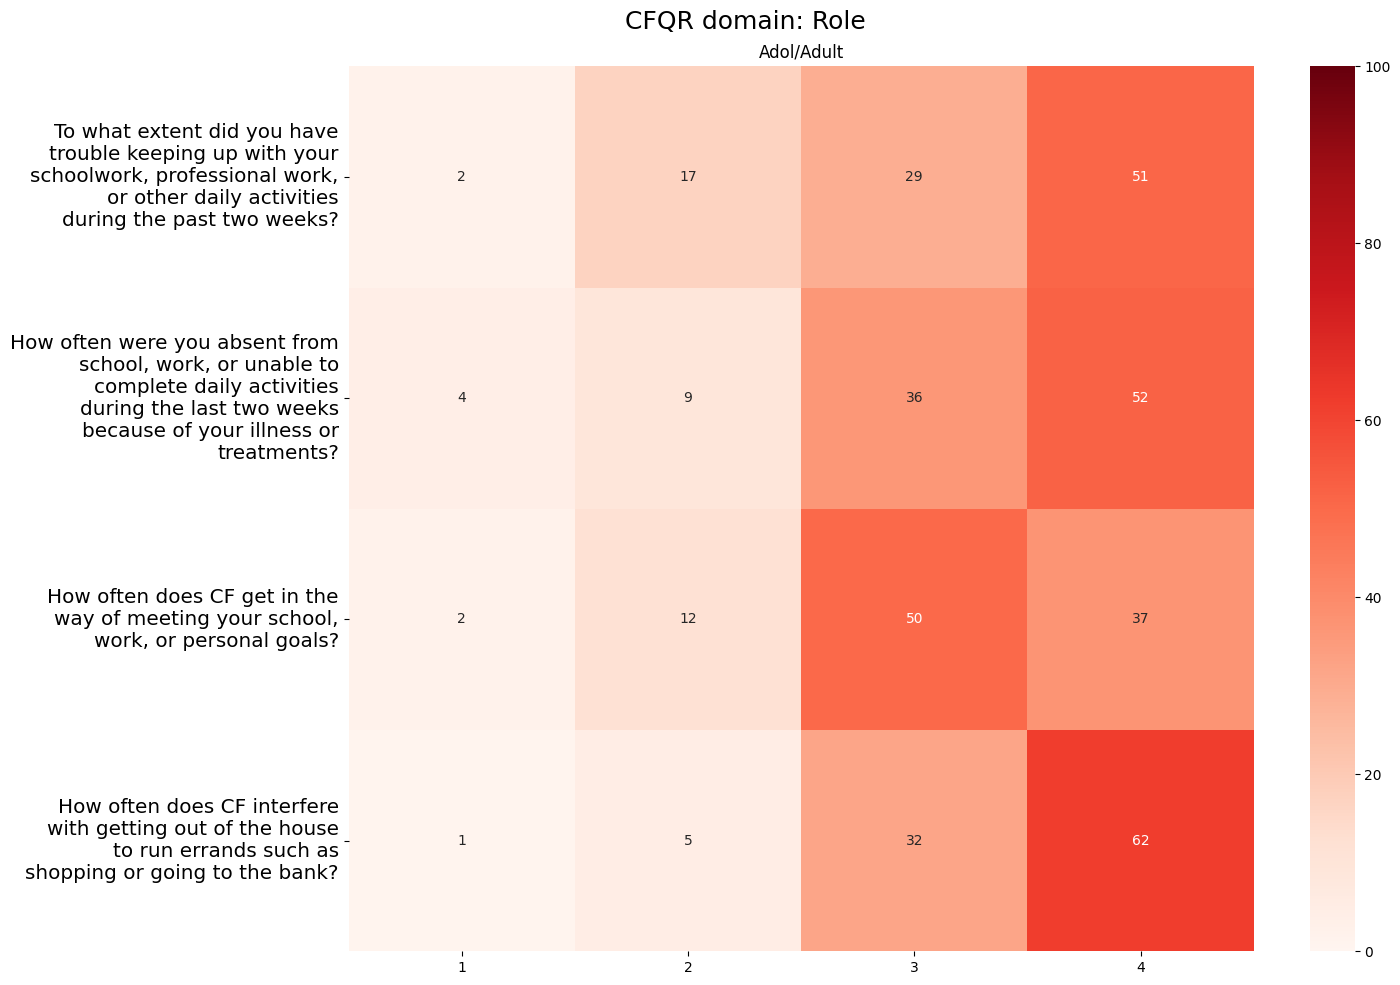

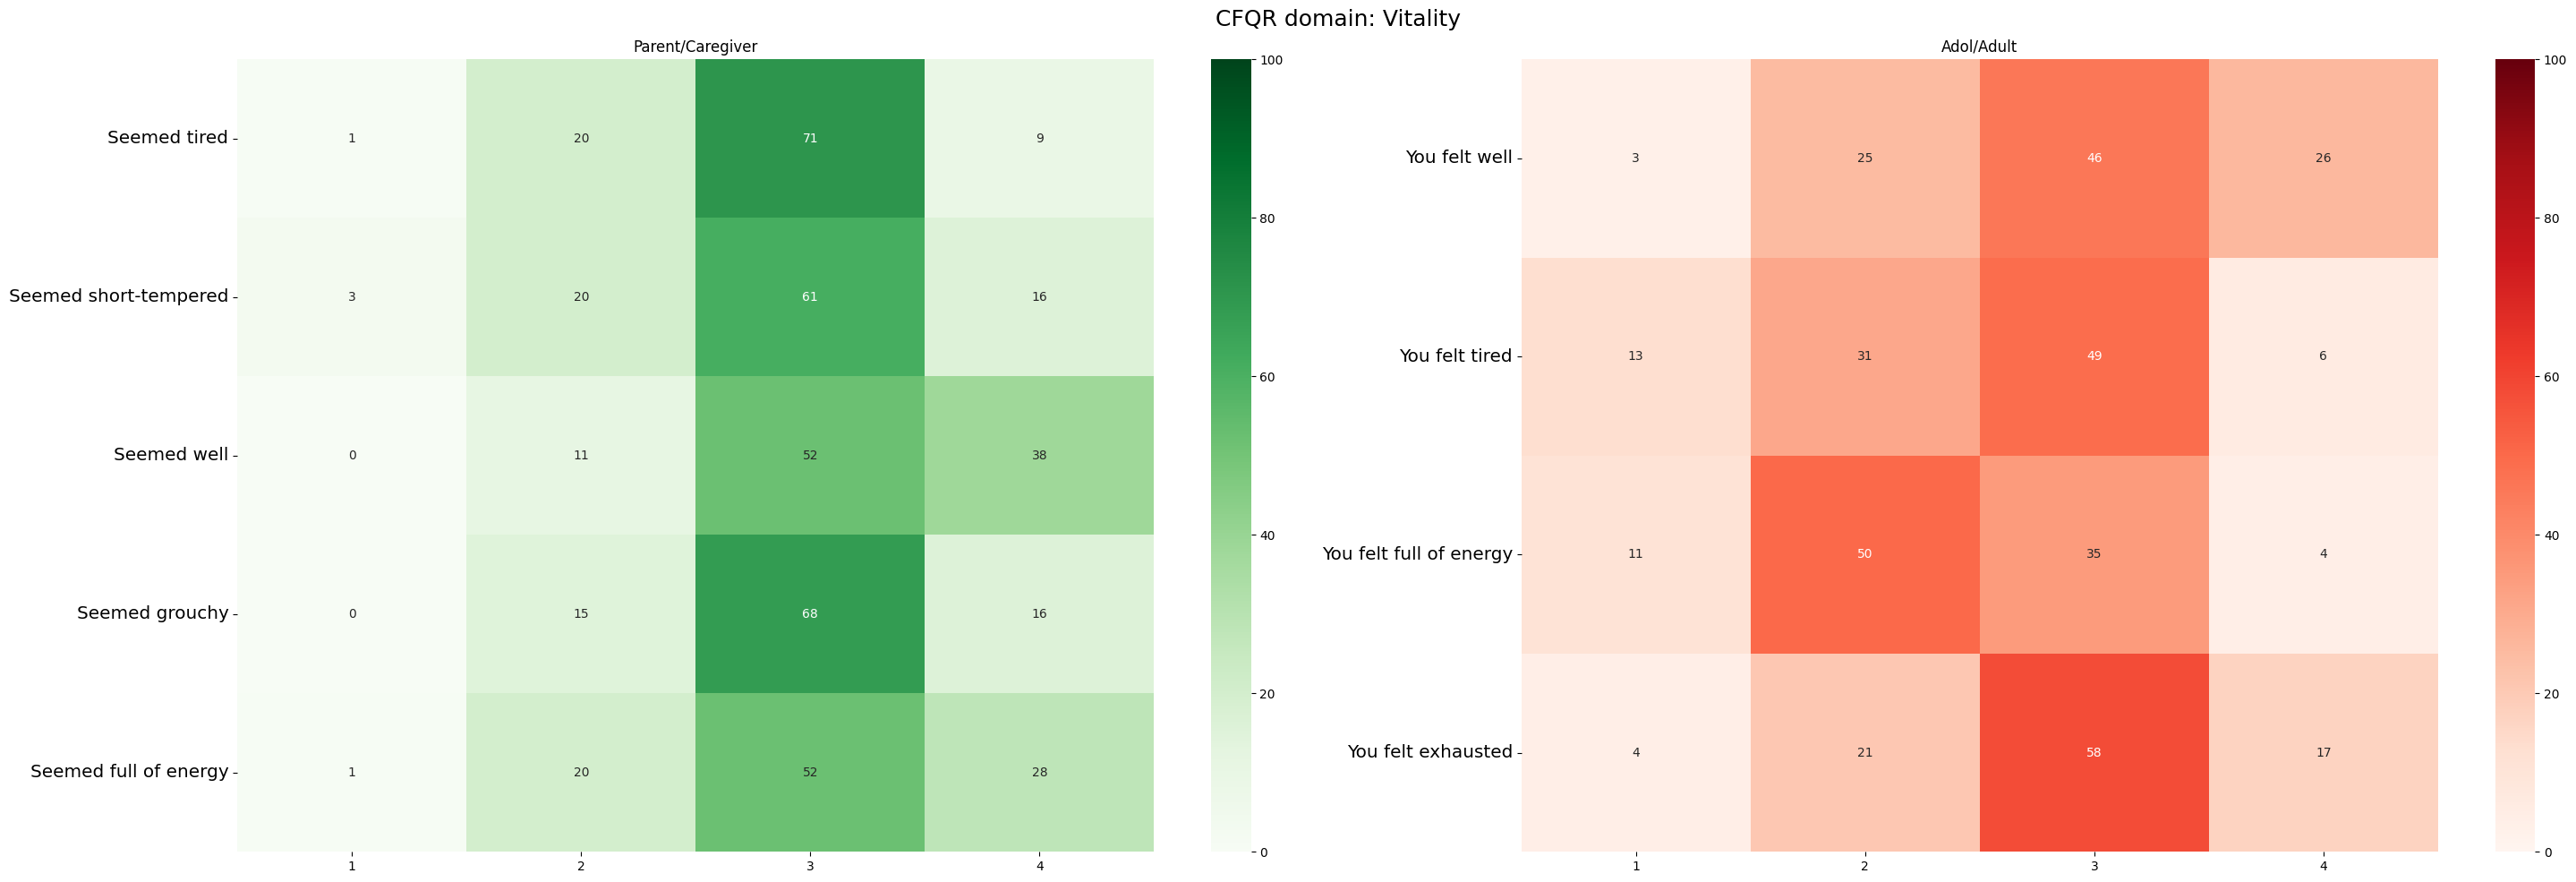

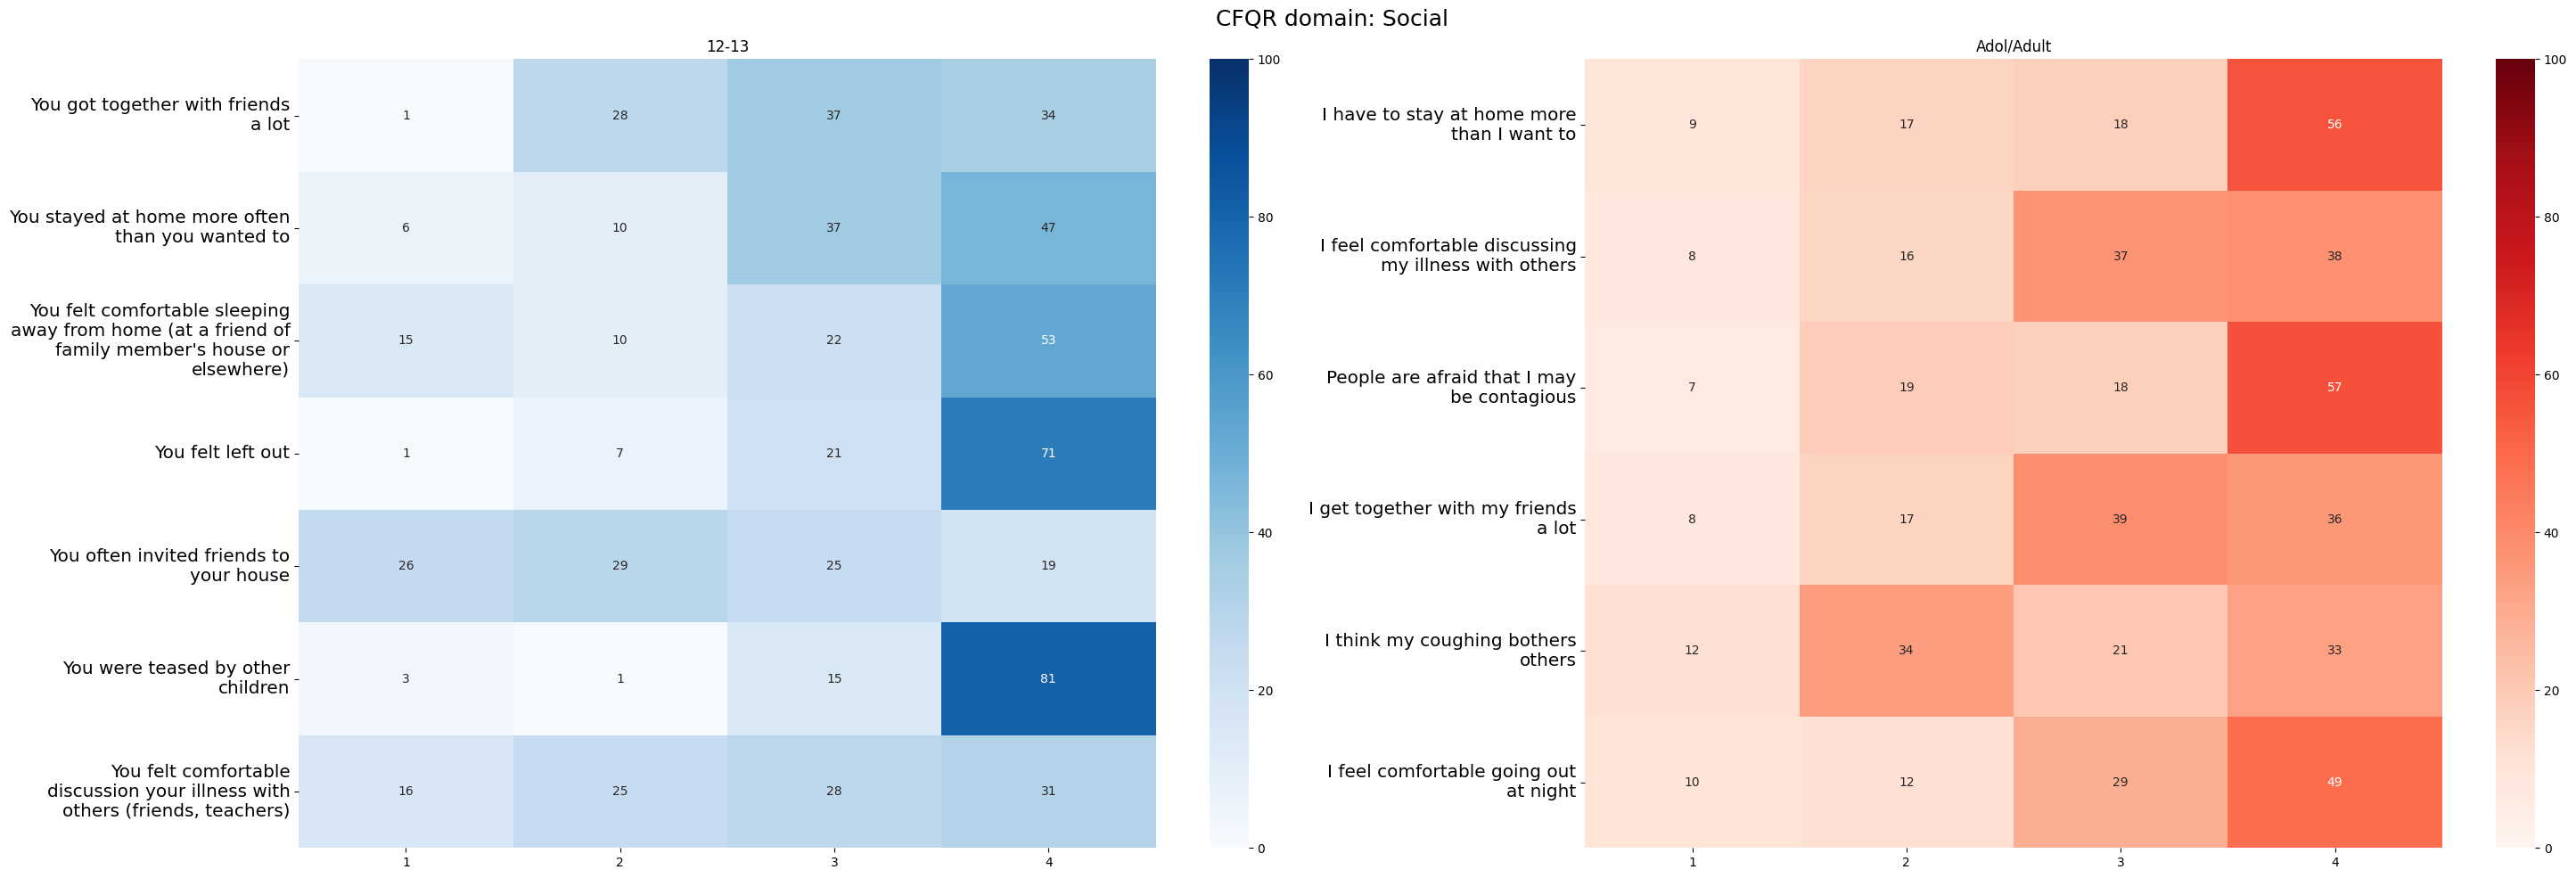

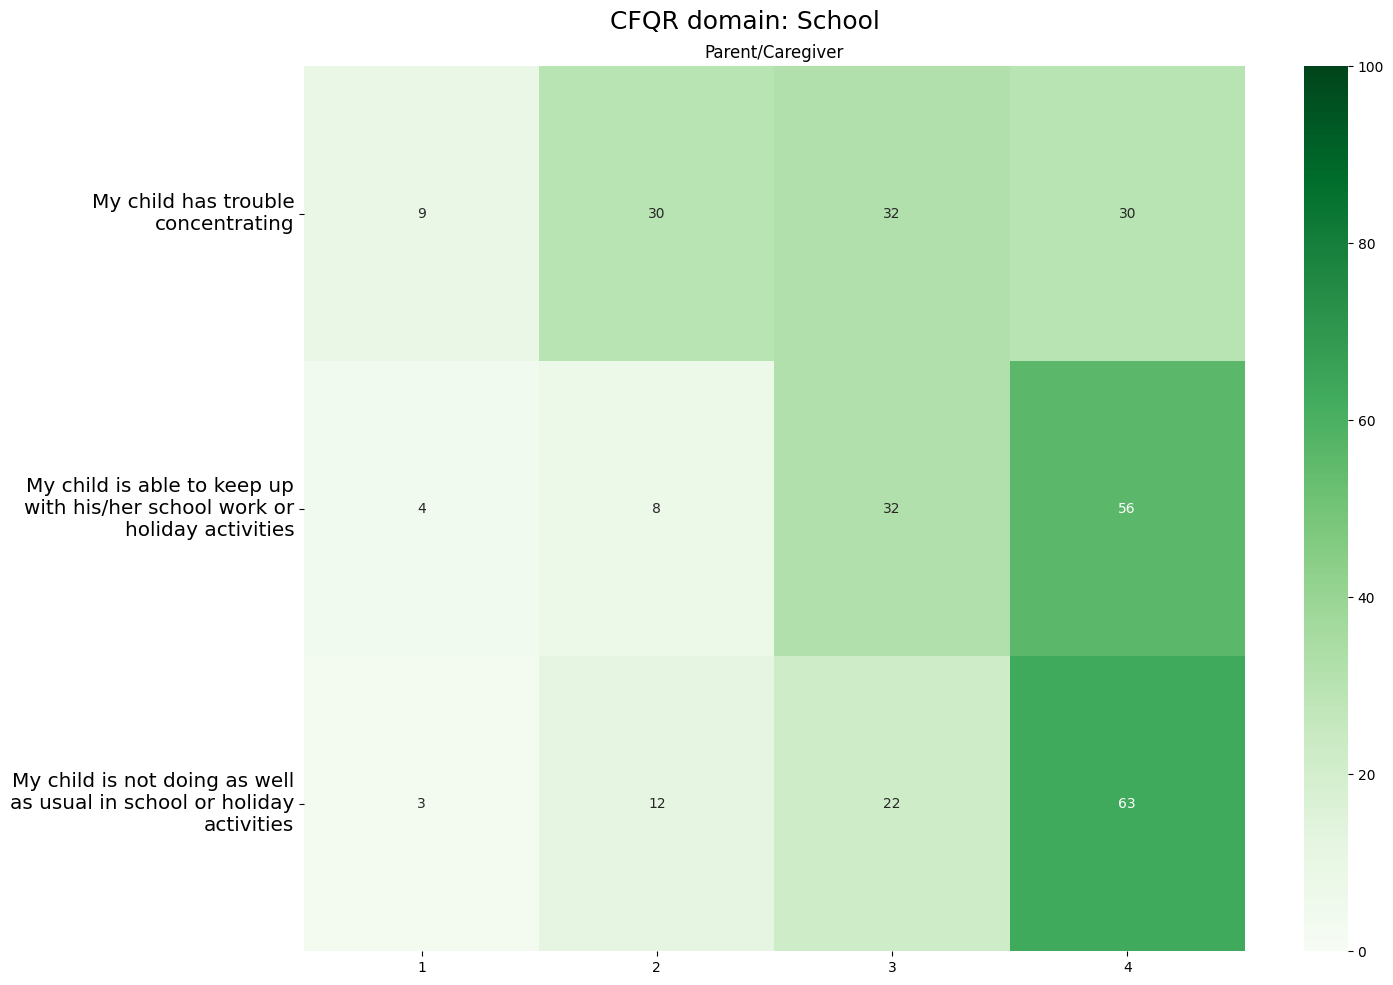

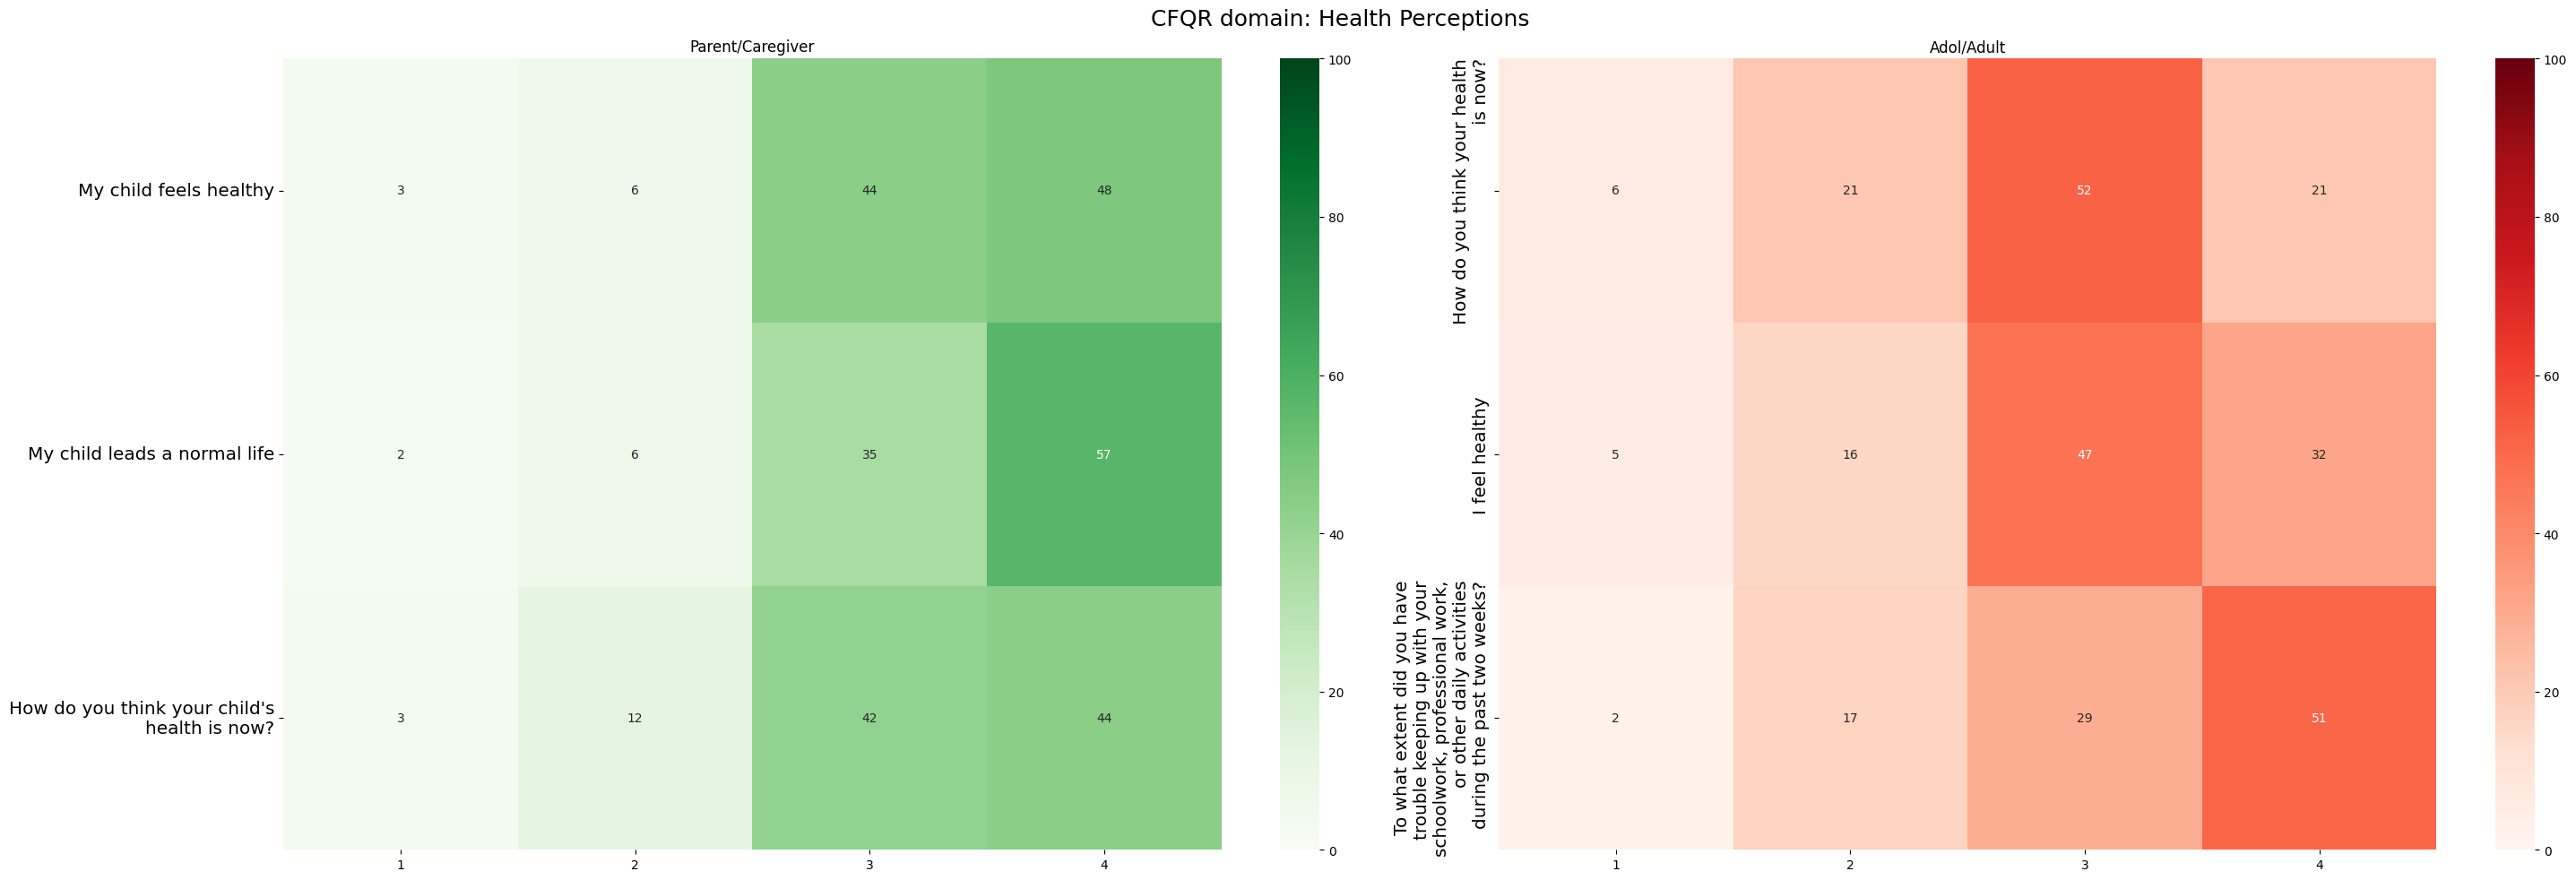

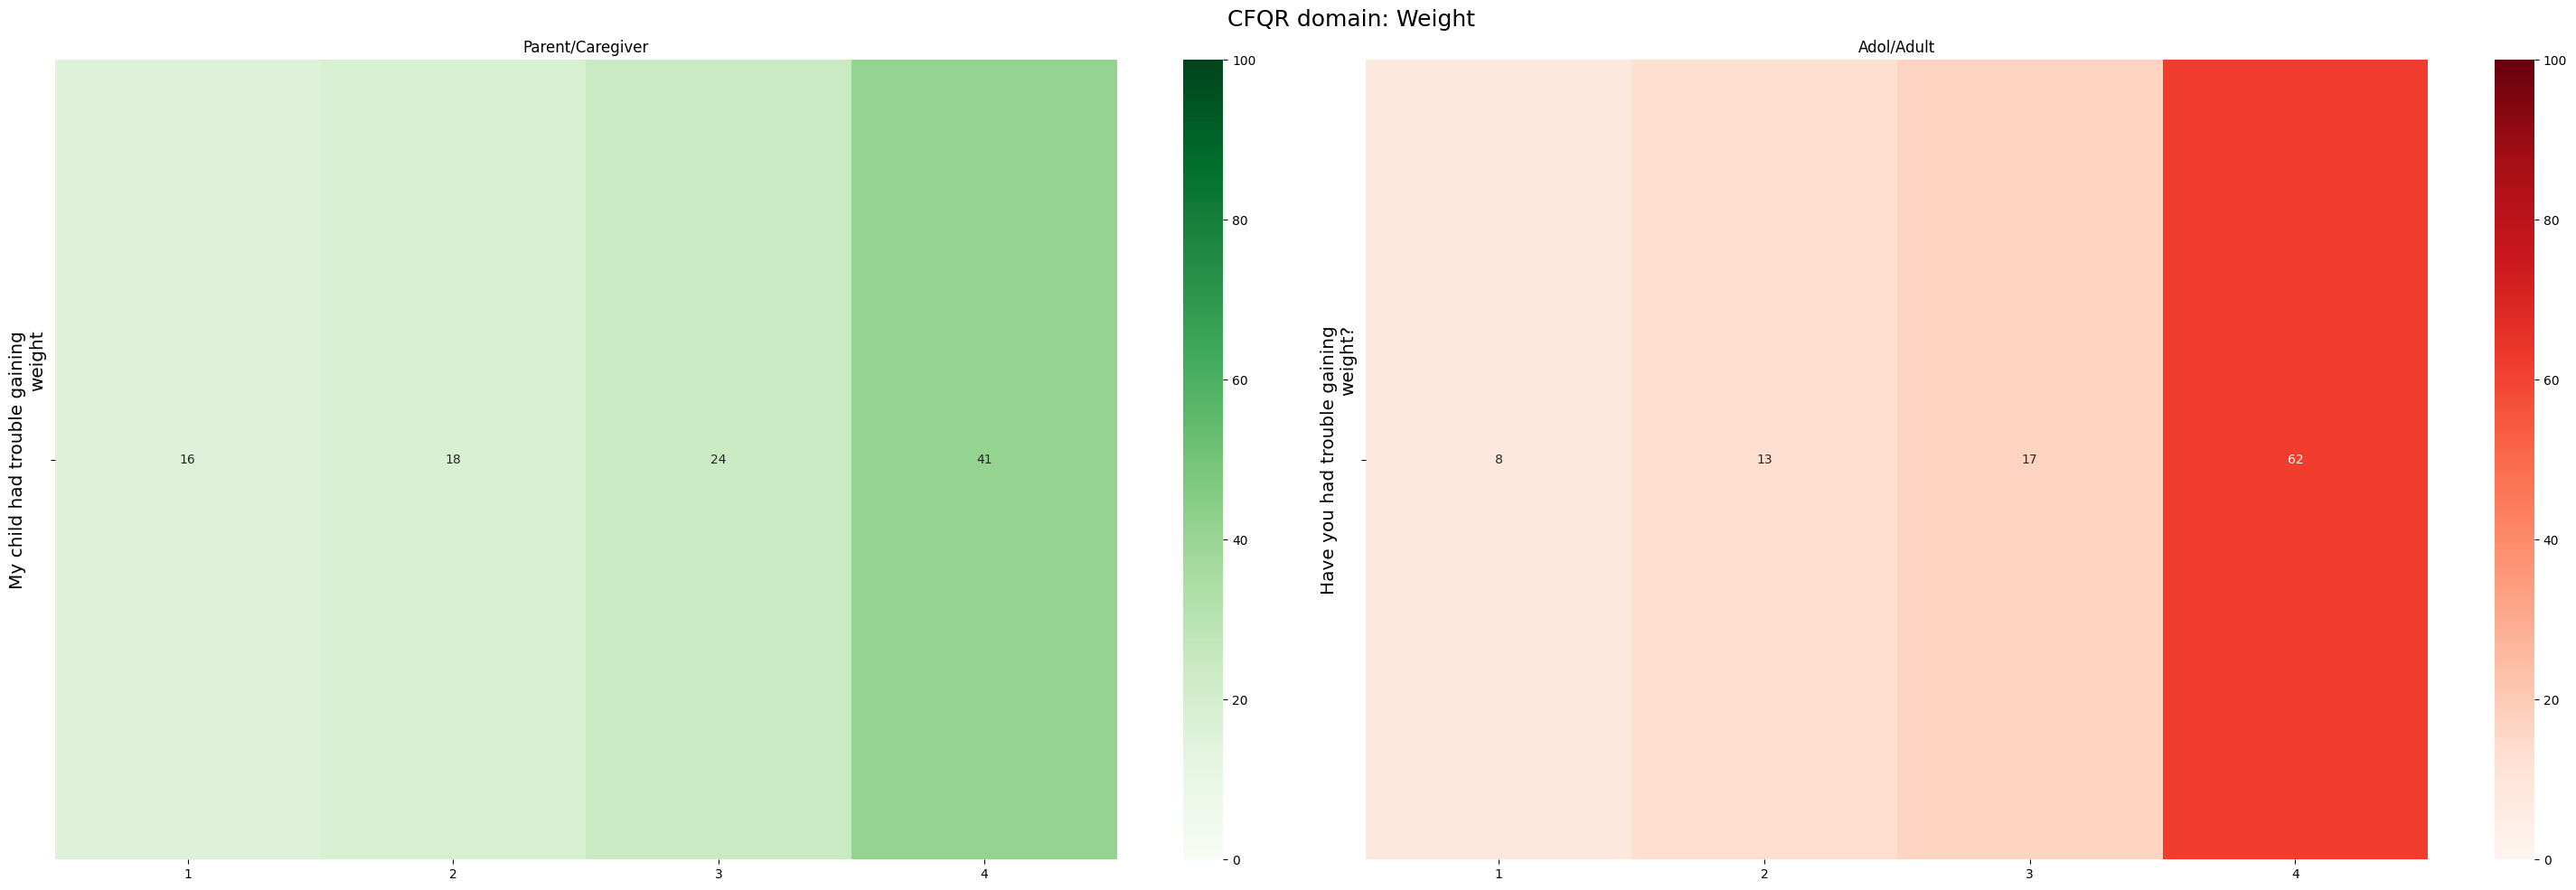

In [54]:
Rmarkdown_results = []

import warnings
warnings.filterwarnings('ignore')

# importing the modules 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

    # CFQR_results[domain]["12-13"] = []
    # CFQR_results[domain]["Parent/Caregiver"] = []
    # CFQR_results[domain]["Adol/Adult"] = []

# # setting the parameter values 
annot = True
    
for domain in Domains:
    # Check which surveys have avaiable data
    count = 0
    for survey_cat in Surveys:
        if CFQR_results[domain][survey_cat] != []:
            count = count + 1
    
    fig, ax = plt.subplots(1, count, figsize=(count * 15, 10))
    
    column = 0
    for survey_cat in Surveys:
        if CFQR_results[domain][survey_cat] != []:
            results = []
            for a in range (0, len(CFQR_results[domain][survey_cat][0])):
                results.append([0, 0, 0, 0])

            for a in range (0, len(CFQR_results[domain][survey_cat])):
                for b in range (0, len(CFQR_results[domain][survey_cat][a])):
                    results[b][CFQR_results[domain][survey_cat][a][b]-1] = results[b][CFQR_results[domain][survey_cat][a][b]-1] + 1

            # Change to percentages
            for a in range (0, len(results)):
                for b in range (0, len(results[a])):
                    results[a][b] = round(results[a][b] * 100 / len(CFQR_results[domain][survey_cat])) 
                    
            Rmarkdown_results.append([domain, survey_cat, results])

            # Create the heatmap labels
            y_axis_labels = []
            for num in Survey_to_question_num[survey_cat][domain]:
                y_axis_labels.append(textwrap.fill(Survey_to_question[survey_cat][num], 30))
            x_axis_labels = ["1", "2", "3", "4"]

            if count == 1:
                # plotting the heatmap 
                ax.set_xticklabels(ax.get_xticks(), rotation = 0)
                ax.set_yticklabels(ax.get_yticks(), fontsize='x-large')

                hm = sn.heatmap(data=results, annot=annot, cmap=heatmap_color[survey_cat], fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax, vmin=0, vmax=100)
                ax.title.set_text(survey_cat)
            else:
                # plotting the heatmap 
                ax[column].set_xticklabels(ax[column].get_xticks(), rotation = 0)
                ax[column].set_yticklabels(ax[column].get_yticks(), fontsize='x-large')

                hm = sn.heatmap(data=results, annot=annot, cmap=heatmap_color[survey_cat], fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[column], vmin=0, vmax=100)
                ax[column].title.set_text(survey_cat)
                column = column + 1
    
    fig.suptitle("CFQR domain: {}".format(domain), fontsize=18)
    fig.tight_layout()
    plt.savefig('BEATCF_heatmaps_{}.png'.format(domain))
    plt.show() 

# plt.show() 

In [55]:
# Clear the data from the table
sql_string = "TRUNCATE TABLE derived_CFQR_heatmaps"
mycursor.execute(sql_string)

# Insert the results from the heatmap into the database
for survey in Rmarkdown_results:
    domain = survey[0]
    survey_type = survey[1]
    results = survey[2]
        
    # Get the question numbers and question based on domain and survey type
    if survey_type == '12-13':
        temp_survey_dic = cfqr1213_question_numbers
        temp_survey_questions = CFQR_1213_questions
    elif survey_type == 'Parent/Caregiver':
        temp_survey_dic = cfqrparents_question_numbers
        temp_survey_questions = CFQR_parent_questions
    elif survey_type == 'Adol/Adult':
        temp_survey_dic = cfqradol_question_numbers
        temp_survey_questions = CFQR_adoladult_questions
    else:
        print("Survey Type Error: {}".format(survey_type))
    
    # Check to see if the number of questions is equal to the number of questions reported by the domain
    if len(results) != len(temp_survey_dic[domain]):
        print("Results Error: {} - {}".format(domain, survey_type))
    
    # Use the domain to link to the number of questions
    for a in range (0, len(results)):
        question_number = temp_survey_dic[domain][a]
        question_string = temp_survey_questions[question_number]
        
        for b in range (0, 4):
            score = b + 1
            value  = results[a][b]

            sql_variables = [domain, survey_type, question_number, question_string, score, value]
            #Write the MySQL insert string for this study_id
            sql_string = """INSERT IGNORE INTO derived_CFQR_heatmaps (domain, survey_type, Question_Number, Question_String, Score, Value, updated_at)VALUES ("""

            for b in range (0, len(sql_variables)):
                if sql_variables[b] == None:
                    sql_string = sql_string + 'NULL,'
                else:
                    sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
            sql_string = sql_string + "NOW())"
            mycursor.execute(sql_string)
            connection.commit()     

#### Total Heatmaps

##### Adult / Adolescent

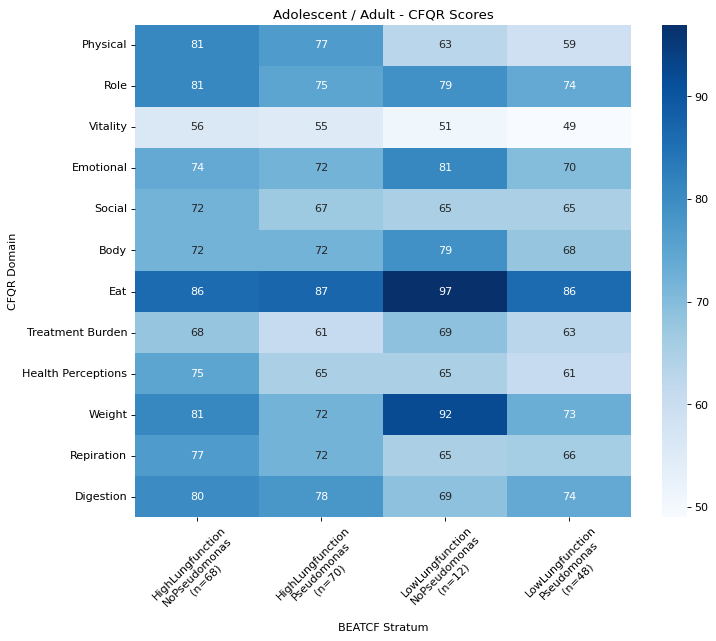

In [56]:
import warnings
warnings.filterwarnings('ignore')

# importing the modules 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 
from statistics import mean

CFQR_stratum = ["HighLungfunction+NoPseudomonas", "HighLungfunction+Pseudomonas",'LowLungfunction+NoPseudomonas','LowLungfunction+Pseudomonas']
domains = ["Physical", "Role", "Vitality", "Emotional", "Social", "Body", "Eat", "Treatment Burden", "Health Perceptions", "Weight", "Repiration", "Digestion"]

# Calculate the averages for each domain, each stratum
results = []
CFQR_stratum_label = []
for stratum in CFQR_stratum:
    sql_string = """select * from cfqr_adol where stratum = '{}' and enrolment_date < "2023-07-01" and study_id not in ('010-0004', '010-0032')""".format(stratum)
    mycursor.execute(sql_string)
    data = mycursor.fetchall()
    
    label_string = stratum.split("+")[0] + "\n" + stratum.split("+")[1] + "\n(n={})".format(len(data)) 
    CFQR_stratum_label.append(label_string)
    #print(stratum, len(data))
    
    score_array = [[] for a in range (len(domains))] # There are 12 domains for adolescent / adult CFQR survey
    for a in range (0, len(data)):
        for b in range (0, len(domains)): 
            score_array[b].append(float(data[a][b+3]))
    
    temp = []
    for b in range (0, len(domains)):
        temp.append(round(mean(score_array[b])))
    results.append(temp)
    
results = np.array(results).T

annot = True

plt.figure(figsize=(10, 8), dpi=80)
hm = sn.heatmap(data=results, annot=annot, cmap='Blues', xticklabels=CFQR_stratum_label, yticklabels=domains, fmt='g')
hm.set(xlabel='BEATCF Stratum', ylabel='CFQR Domain')
plt.xticks(rotation=45)
plt.title("Adolescent / Adult - CFQR Scores")
plt.show()

##### Caregiver / Parents

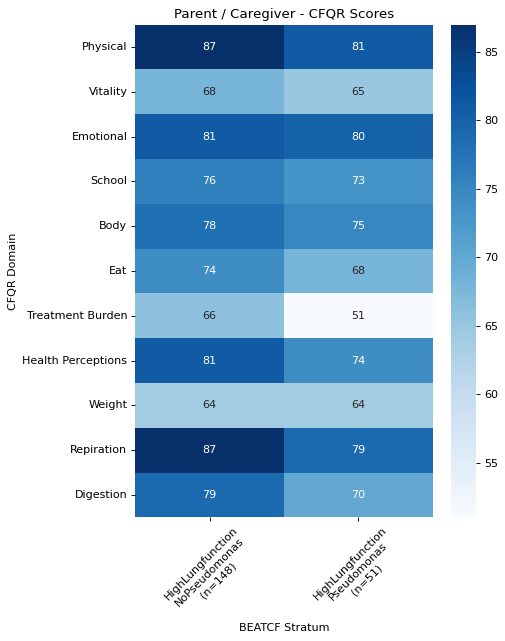

In [57]:
# Removed Low Lungfunction Strata

CFQR_stratum = ["HighLungfunction+NoPseudomonas", "HighLungfunction+Pseudomonas"]
CFQR_stratum_label = ["HighLungfunction\nNoPseudomonas", "HighLungfunction\nPseudomonas"]
domains = ["Physical", "Vitality", "Emotional", "School", "Body", "Eat", "Treatment Burden", "Health Perceptions", "Weight", "Repiration", "Digestion"]

# Calculate the averages for each domain, each stratum
results = []
CFQR_stratum_label = []
for stratum in CFQR_stratum:
    sql_string = """select * from cfqr_parent where stratum = '{}' and enrolment_date < "2023-07-01" and study_id not in ('010-0004', '010-0032')""".format(stratum)
    mycursor.execute(sql_string)
    data = mycursor.fetchall()
    
    label_string = stratum.split("+")[0] + "\n" + stratum.split("+")[1] + "\n(n={})".format(len(data)) 
    CFQR_stratum_label.append(label_string)
    
    score_array = [[] for a in range (len(domains))] # There are 12 domains for adolescent / adult CFQR survey
    for a in range (0, len(data)):
        for b in range (0, len(domains)): 
            score_array[b].append(float(data[a][b+3]))
    
    temp = []
    for b in range (0, len(domains)):
        temp.append(round(mean(score_array[b])))
    results.append(temp)
    
results = np.array(results).T

annot = True

plt.figure(figsize=(6, 8), dpi=80)
hm = sn.heatmap(data=results, annot=annot, cmap='Blues', xticklabels=CFQR_stratum_label, yticklabels=domains, fmt='g')
hm.set(xlabel='BEATCF Stratum', ylabel='CFQR Domain')
plt.xticks(rotation=45)
plt.title("Parent / Caregiver - CFQR Scores")
plt.show()

#### Age Plots

##### Original Plots

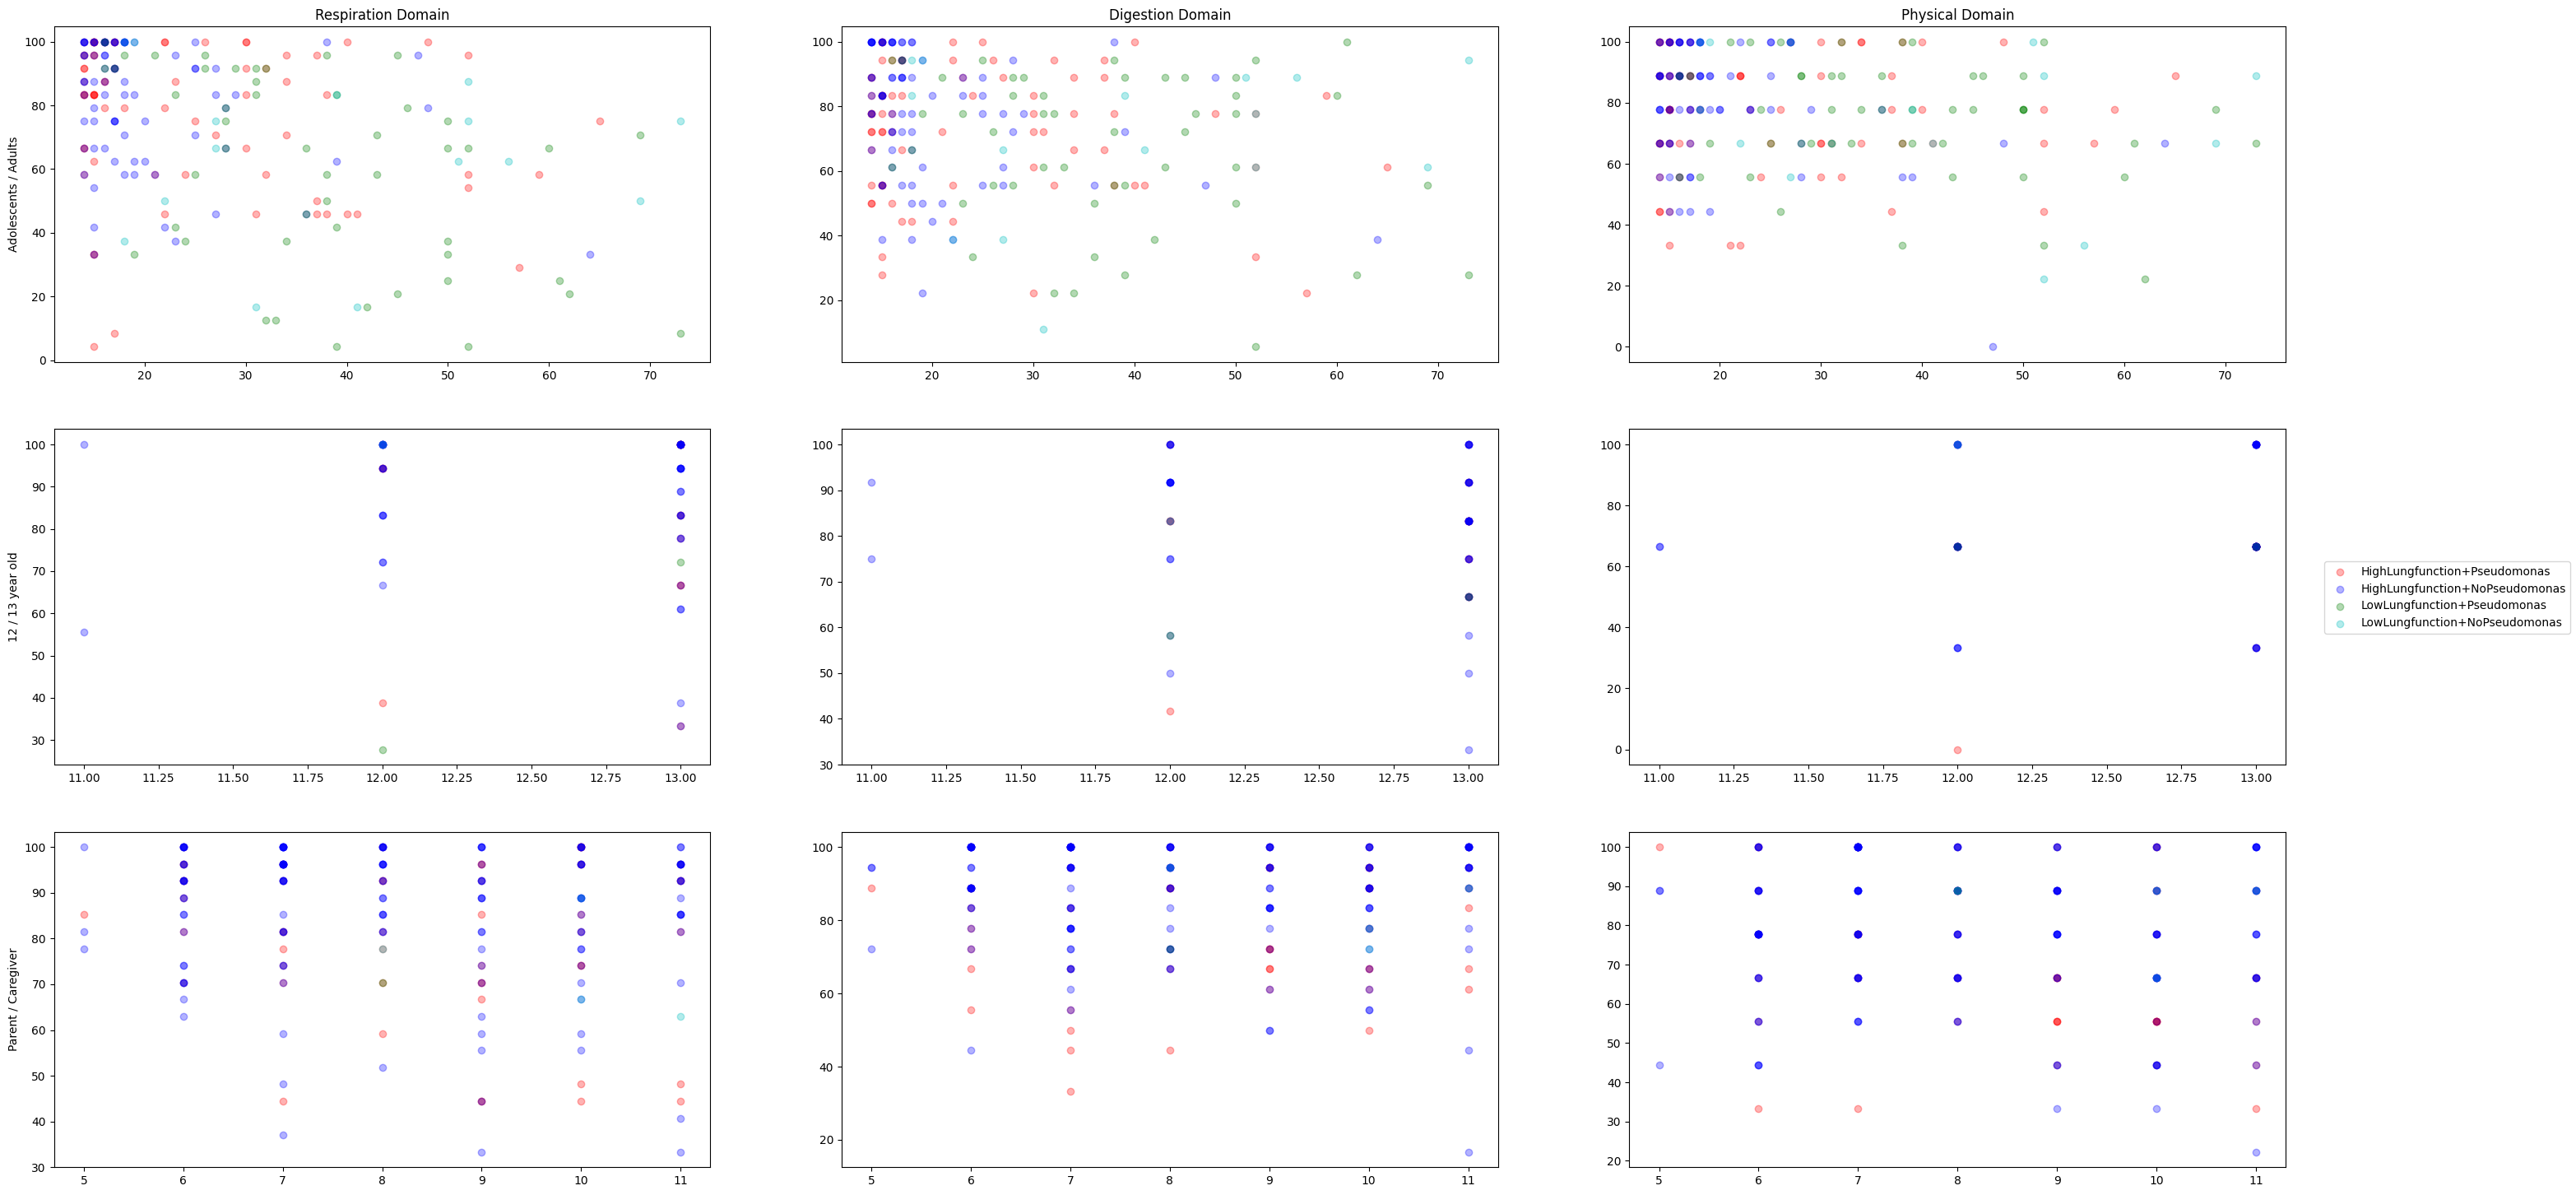

In [58]:
import warnings
warnings.filterwarnings('ignore')

# importing the modules 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3,3, figsize=(35, 18))

CFQR_domains = ["physical", "respiration", "digestion"]
CFQR_survey = ["cfqr_adol", "cfqr_1213", "cfqr_parent"]
CFQR_stratum = ["HighLungfunction+Pseudomonas", "HighLungfunction+NoPseudomonas",'LowLungfunction+Pseudomonas','LowLungfunction+NoPseudomonas']
colours = ['r', 'b', 'g', 'c']

for a in range (0, len(CFQR_survey)):
    for b in range (0, len(CFQR_domains)):
        for c in range (0, len(CFQR_stratum)):

            survey = CFQR_survey[a]
            domain = CFQR_domains[b]
            stratum = CFQR_stratum[c]
            
            sql_string = "select a.study_id, a.{}, b.age_int from {} a inner join beatcf_enrolment_paper b where a.study_id = b.study_id and b.stratum = '{}' and b.ppfev_365 != ''".format(domain, survey, stratum)
            mycursor.execute(sql_string)
            data = mycursor.fetchall()

            y_column = []
            age = []
            for d in range (0, len(data)):
                y_column.append(data[d][1])
                age.append(data[d][2])
                
            ax[a, b].scatter(age, y_column, color = colours[c], alpha=0.3, label = stratum)

# displaying the plotted heatmap 
ax[0, 0].set_title("Respiration Domain")
ax[0, 0].set(ylabel="Adolescents / Adults")

ax[0, 1].set_title("Digestion Domain")
ax[1, 0].set(ylabel="12 / 13 year old")

ax[0, 2].set_title("Physical Domain")
ax[2, 0].set(ylabel="Parent / Caregiver")

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.savefig('BEATCF_CFQR vs Age.png')
plt.show()

##### Age Spread

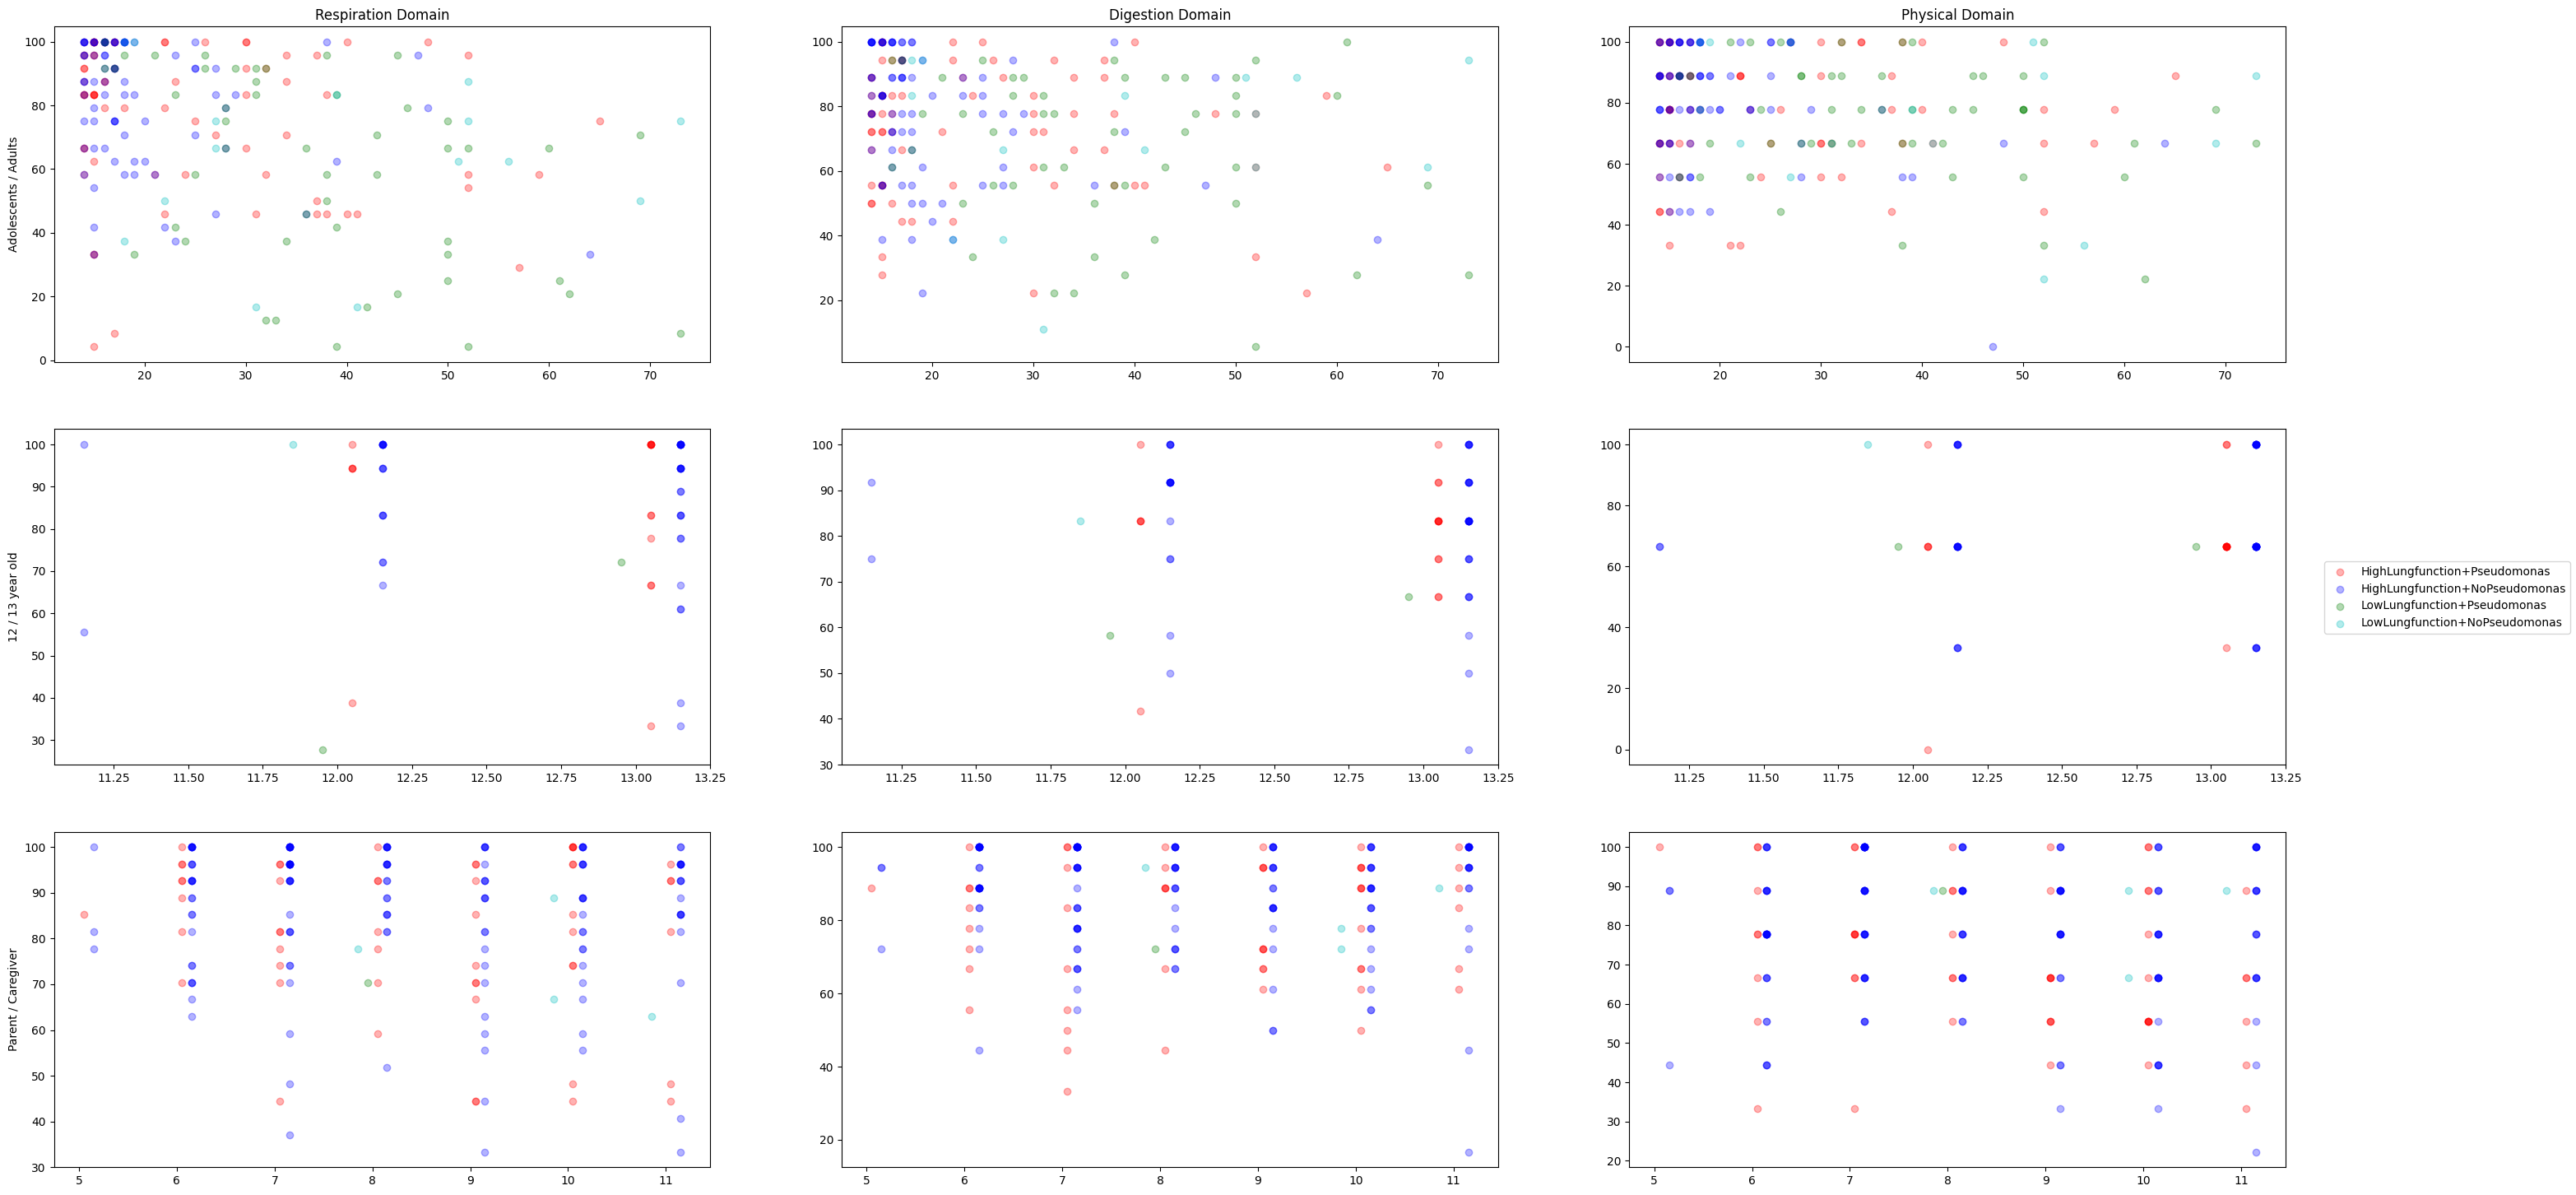

In [59]:
import warnings
warnings.filterwarnings('ignore')

# importing the modules 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3,3, figsize=(35, 18))

CFQR_domains = ["physical", "respiration", "digestion"]
CFQR_survey = ["cfqr_adol", "cfqr_1213", "cfqr_parent"]
CFQR_stratum = ["HighLungfunction+Pseudomonas", "HighLungfunction+NoPseudomonas",'LowLungfunction+Pseudomonas','LowLungfunction+NoPseudomonas']
colours = ['r', 'b', 'g', 'c']
age_spread = [0.05, 0.15, -0.05, -0.15]

for a in range (0, len(CFQR_survey)):
    for b in range (0, len(CFQR_domains)):
        for c in range (0, len(CFQR_stratum)):

            survey = CFQR_survey[a]
            domain = CFQR_domains[b]
            stratum = CFQR_stratum[c]
            
            sql_string = "select a.study_id, a.{}, b.age_int from {} a inner join beatcf_enrolment_paper b where a.study_id = b.study_id and b.stratum = '{}' and b.ppfev_365 != ''".format(domain, survey, stratum)
            mycursor.execute(sql_string)
            data = mycursor.fetchall()

            y_column = []
            age = []
            for d in range (0, len(data)):
                y_column.append(data[d][1])
                if a != 0:
                    age.append(data[d][2] + age_spread[c])
                else:
                    age.append(data[d][2])
                
            ax[a, b].scatter(age, y_column, color = colours[c], alpha=0.3, label = stratum)

# displaying the plotted heatmap 
ax[0, 0].set_title("Respiration Domain")
ax[0, 0].set(ylabel="Adolescents / Adults")

ax[0, 1].set_title("Digestion Domain")
ax[1, 0].set(ylabel="12 / 13 year old")

ax[0, 2].set_title("Physical Domain")
ax[2, 0].set(ylabel="Parent / Caregiver")

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.savefig('BEATCF_CFQR vs Age.png')
plt.show()

#### FFEVplot

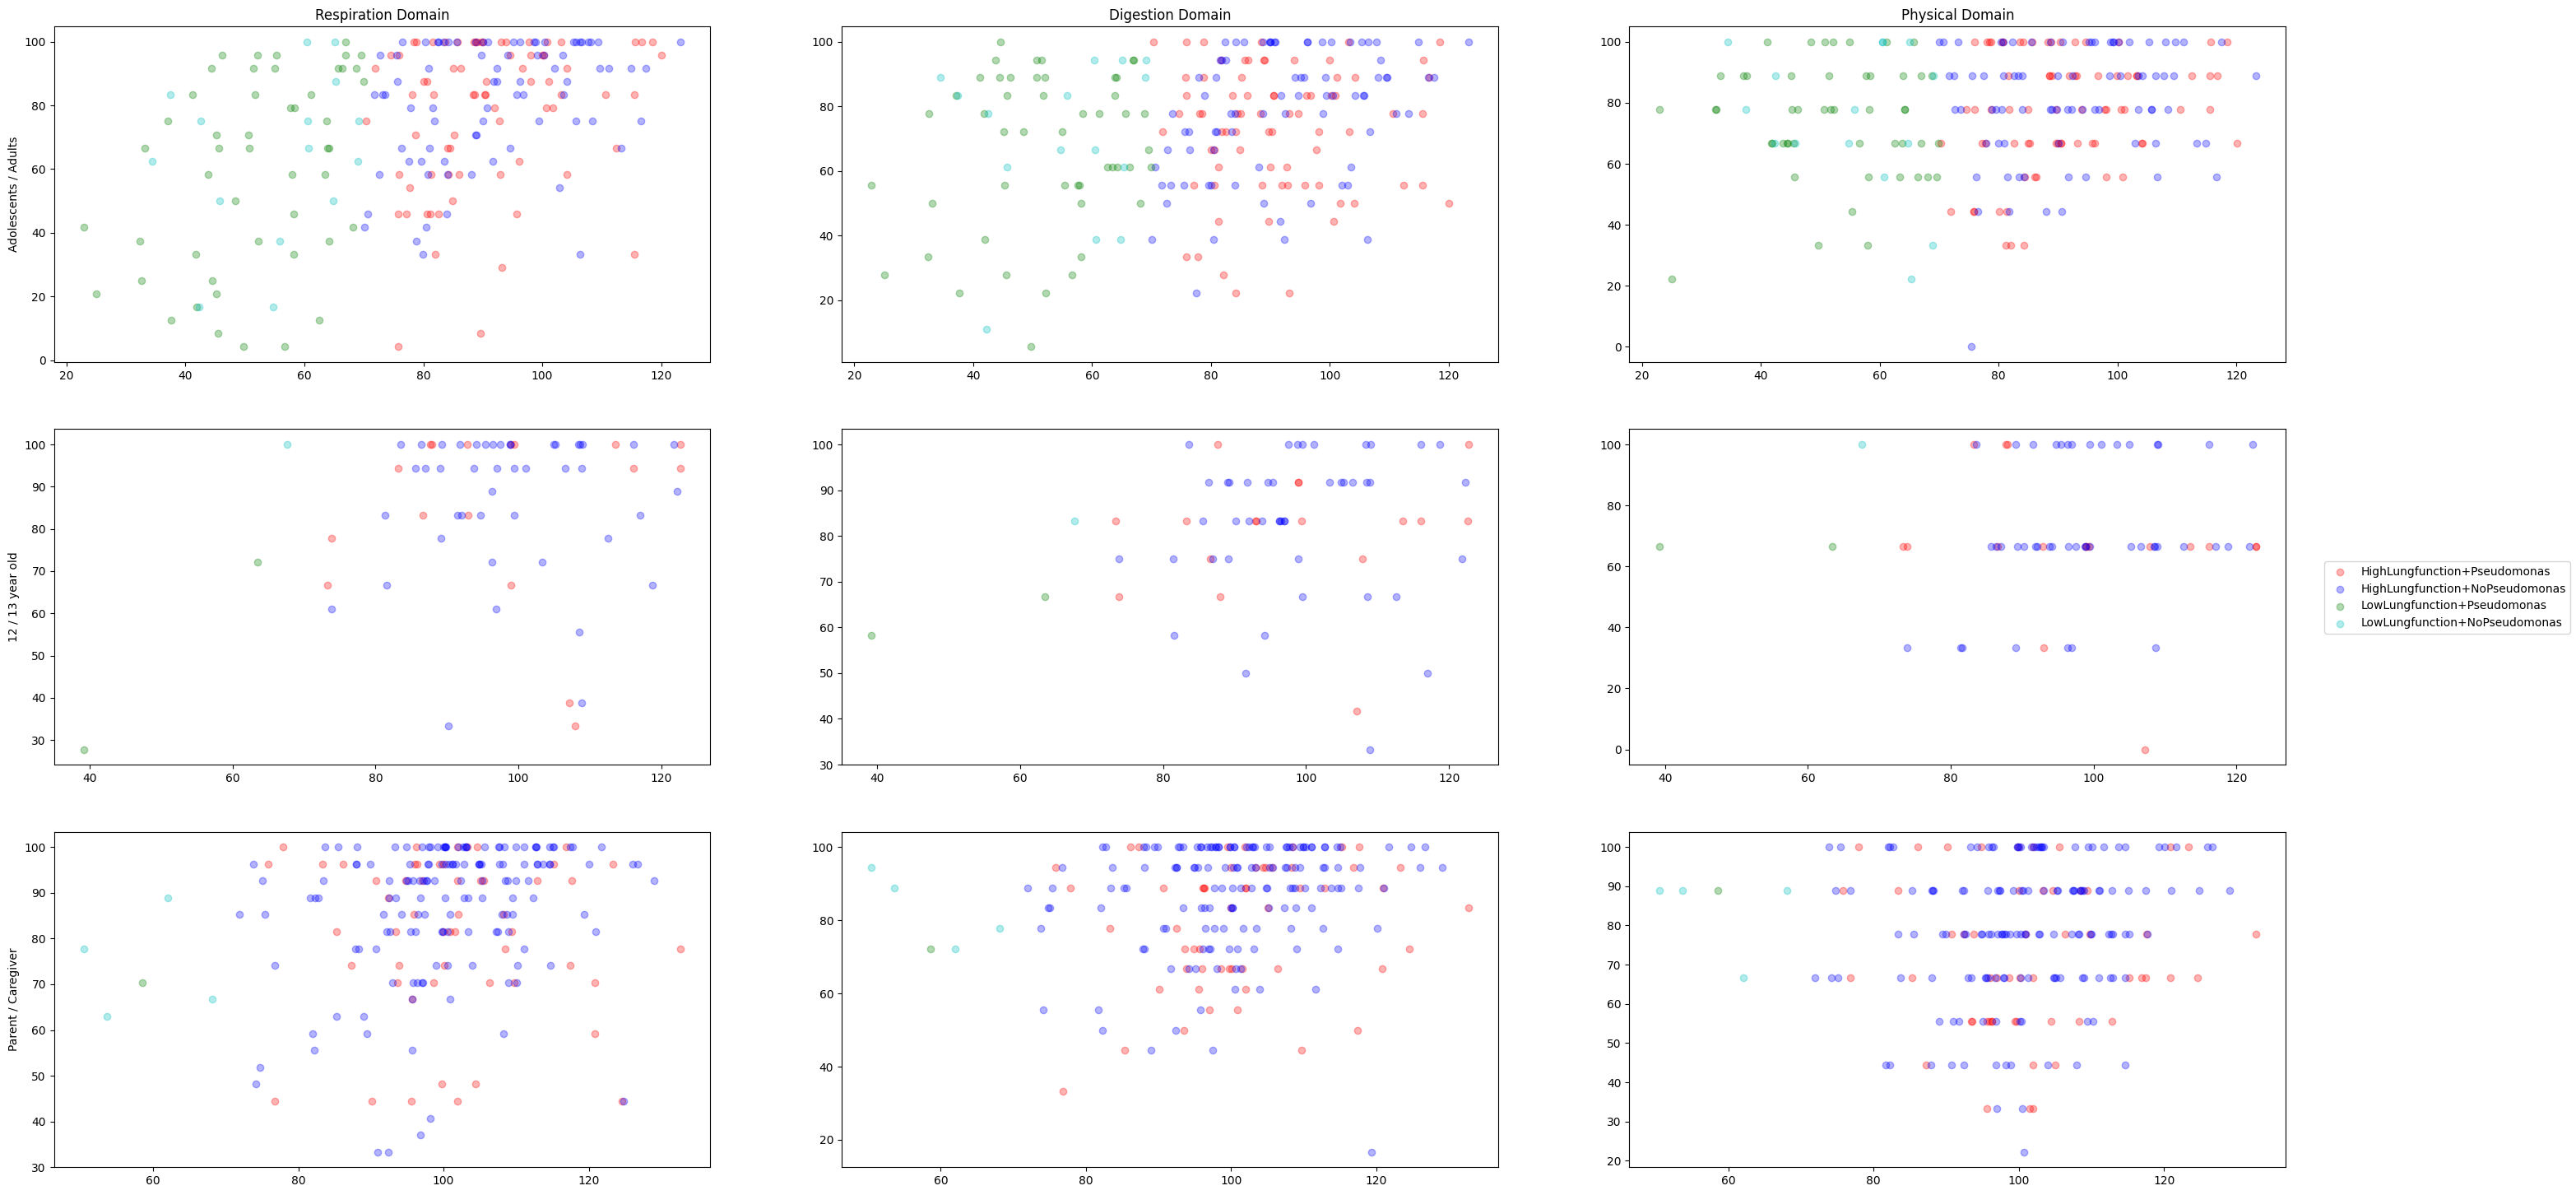

In [60]:
import warnings
warnings.filterwarnings('ignore')

# importing the modules 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3,3, figsize=(35, 18))

CFQR_domains = ["physical", "respiration", "digestion"]
CFQR_survey = ["cfqr_adol", "cfqr_1213", "cfqr_parent"]
CFQR_stratum = ["HighLungfunction+Pseudomonas", "HighLungfunction+NoPseudomonas",'LowLungfunction+Pseudomonas','LowLungfunction+NoPseudomonas']
colours = ['r', 'b', 'g', 'c']

for a in range (0, len(CFQR_survey)):
    for b in range (0, len(CFQR_domains)):
        for c in range (0, len(CFQR_stratum)):

            survey = CFQR_survey[a]
            domain = CFQR_domains[b]
            stratum = CFQR_stratum[c]
            
            sql_string = "select a.study_id, a.{}, b.ppfev_365 from {} a inner join beatcf_enrolment_paper b where a.study_id = b.study_id and b.stratum = '{}' and b.ppfev_365 != ''".format(domain, survey, stratum)
            mycursor.execute(sql_string)
            data = mycursor.fetchall()

            y_column = []
            ppfev = []
            for d in range (0, len(data)):
                y_column.append(data[d][1])
                ppfev.append(data[d][2])
                
            ax[a, b].scatter(ppfev, y_column, color = colours[c], alpha=0.3, label = stratum)

# displaying the plotted heatmap 
ax[0, 0].set_title("Respiration Domain")
ax[0, 0].set(ylabel="Adolescents / Adults")

ax[0, 1].set_title("Digestion Domain")
ax[1, 0].set(ylabel="12 / 13 year old")

ax[0, 2].set_title("Physical Domain")
ax[2, 0].set(ylabel="Parent / Caregiver")

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.savefig('BEATCF_CFQR vs ppFEV.png')
plt.show()

### Concomitant Medications

In [132]:
# Create a dictionary from predefined grouping from .csv file
conmed_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\BEATCF_ConcomitantMedications_19Feb2024.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        conmed_data.append(row)

In [133]:
conmed_group = {} # Links free text with a con med grouping category

for a in range (1, len(conmed_data)): # Discard the headings of the csv
    free_text = conmed_data[a][1]
    free_text = free_text.replace("Ãƒâ€šÃ‚Â®", "").replace("ÃƒÂ¡","") # Remove unrecognized characters
    conmed_group[free_text] = conmed_data[a][4]
    
conmed_group = dict(sorted(conmed_group.items())) # Sort the dictionary alphabetically 
    
final_grouping = []
for key in conmed_group:
    grouping = conmed_group[key]
    grouping = grouping.replace("Â\xa0", "")
    if grouping == "?" or grouping == "":
        grouping = "Unknown"
    if grouping not in final_grouping:
        final_grouping.append(grouping)
        
final_grouping.sort()

In [134]:
conmed_group_index = {} # Links cmt index with their medication name 

sql_string = """SELECT * FROM medication_name"""
mycursor.execute(sql_string)
temp_data = mycursor.fetchall()

for a in range (0, len(temp_data)):
    index = temp_data[a][0]
    medication_name = temp_data[a][1].replace("Ãƒâ€šÃ‚Â®", "").replace("ÃƒÂ¡","").replace("Â®", "") # Remove special characters
    medication_name = medication_name + "_index"
    medication_name = medication_name.lstrip(" ") # Remove the first character space from the medication names from the SQL database
    
    conmed_group_index[index] = medication_name

In [135]:
# Create Concomitant table
sql_string = "select * from medication_name"
mycursor.execute(sql_string)
medication_name = mycursor.fetchall()

sql_string = "CREATE TABLE IF NOT EXISTS conmeds_paper_grouped (study_id VARCHAR (8),enrolment_date DATE,stratum TEXT,"

for a in range (0, len(final_grouping)):
    sql_string = sql_string + "{} INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
               
sql_string = sql_string + "updated_at TIMESTAMP, PRIMARY KEY (study_id));"
    
mycursor.execute(sql_string)

In [139]:
# The concomitant medication is present if within the date range of enrolment to "+ 31 days" ~ date window
# If the concomitant is ongoing and
    # startdate is before enrolment date + date window
    # startdate is missing (There is never an end date when ongoing)
# If startdate and end date is all present
    # If startdate before enroldate + date window and enddate after enroldate
# If only startdate is present
    # If startdate is before enroldate + date window
# If only enddate is present
    # if enddate is after enroldate
    
datewindow = 0

# Clear the data from the table
sql_string = "TRUNCATE TABLE conmeds_paper_grouped"
mycursor.execute(sql_string)

sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper WHERE enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
conmeds_data = mycursor.fetchall()

# Concomitant_medication_paper
# Find the number of concurrent medications linked to each subject at date of enrolment
conmed_dict = {}

for a in range (0, len(conmeds_data)):
    denominator_flag = 0 # Check to see if the participant has any concomitant records at the time of enrolment
    study_id = conmeds_data[a][0]
    enrol_date = conmeds_data[a][1]
    stratum = conmeds_data[a][2]
    
    # Find their concomitant_medication
    sql_string = """SELECT study_id, cmtrt, cmtrtoth, cmtrtname, cmstdat, cmongo, cmendat, cmroute
    FROM concomitant_medication
    WHERE study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    #print(len(temp_data))
    
    #Reset Dictionary
    for a in range (0, len(final_grouping)):
        conmed_dict[final_grouping[a]] = 0
    
    if len(temp_data) != 0:
        # Check to see if the concomitant medication was active during enrolment date
        duplicate_list = [] # Check to see if there are any duplicates
        for b in range (0, len(temp_data)):
            flag = 0

            cmt_index = temp_data[b][1]
            cmt_oth = temp_data[b][2]
            cmt_name = temp_data[b][3]
            start_date = temp_data[b][4]
            end_date = temp_data[b][6]
            cmongo = temp_data[b][5]
            cmroute = temp_data[b][7]

            flag = 0
            if cmongo == 1: # If the medication is ongoing
                if start_date != None:
                    if start_date <= enrol_date + datetime.timedelta(days=datewindow):
                        flag = 1
                else:
                    flag = 1
            elif start_date != None and end_date != None:
                if (start_date <= enrol_date + datetime.timedelta(days=datewindow)) and (enrol_date <= end_date):
                    flag = 1
            elif end_date == None:
                if start_date <= enrol_date + datetime.timedelta(days=datewindow):
                    flag = 1
            elif start_date == None:
                if enrol_date <= end_date:
                    flag = 1
            elif end_date == None and start_date == None:
                print("Data Error")                          
                
            # Update the correct key in the conmed_dictionary
            if flag == 1:
                denominator_flag = 1
                if cmt_index != 9998 and cmt_index != 9999:
                    medication_index_name = conmed_group_index[cmt_index]
                    group = conmed_group[medication_index_name]
                    if group == "Antibiotic - Tobramycin" or group == "Antibiotic - other":
                        if cmroute != 3:
                            conmed_dict[group] = 1
                    else:
                        conmed_dict[group] = 1
                else:
                    if cmt_oth in conmed_group:
                        group = conmed_group[cmt_oth]
                        group = group.replace("Â\xa0", "") # Remove Special character from cmt_oth
                    else:
                        # Manual handeling of some special characters
                        if cmt_oth == "EscitaloprÃ¡m":
                            group = "Other"
                        print(cmt_index, cmt_oth)
                    if group == "?" or group == "":
                        group = "Unknown"
                        
                    if group == "Antibiotic - Tobramycin" or group == "Antibiotic - other":
                        if cmroute != 3:
                            conmed_dict[group] = 1
                    else:
                        conmed_dict[group] = 1
                    
    if denominator_flag == 1:
        sql_variables = [study_id, enrol_date, stratum]
        for key in conmed_dict:
            sql_variables.append(conmed_dict[key])

        # Import into SQL
        sql_string = "INSERT IGNORE INTO conmeds_paper_grouped (study_id,enrolment_date,stratum,"

        for a in range (0, len(final_grouping)):
            sql_string = sql_string + "{},".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
        sql_string = sql_string + "updated_at)VALUES ("

        for b in range (0, len(sql_variables)):
            if sql_variables[b] == None:
                sql_string = sql_string + 'NULL,'
            else:
                sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
        sql_string = sql_string + "NOW())"

        mycursor.execute(sql_string)
        connection.commit()

    # Print the study id of those who do not have any concomitant medications    
    else:
        print(study_id, stratum)
print("finished")

002-0063 HighLungfunction+NoPseudomonas
002-0073 N/A
003-0013 HighLungfunction+NoPseudomonas
003-0070 N/A
003-0086 HighLungfunction+NoPseudomonas
003-0108 N/A
9999 EscitaloprÃ¡m
006-0075 HighLungfunction+NoPseudomonas
009-0025 HighLungfunction+NoPseudomonas
009-0031 HighLungfunction+NoPseudomonas
009-0032 LowLungfunction+Pseudomonas
009-0034 HighLungfunction+NoPseudomonas
009-0065 None
011-0023 N/A
finished


In [66]:
# Sort the concomitant medications by Frequency

sql_string = """SELECT * FROM conmeds_paper_grouped WHERE enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
conmeds_data = mycursor.fetchall()

conmeds_name = ["ADHD_medication","Anti_eosinophilic_antibodies","Antibiotic___Amoxicillin","Antibiotic___Azithromycin","Antibiotic___Ciprofloxacin","Antibiotic___Cotrimoxazole_","Antibiotic___Flucloxacillin","Antibiotic___Tobramycin","Antibiotic___other","Anticonvulsant","Antidepressant","Antifungal","Antipsychotic","Corticosteroids___Inhaled","Corticosteroids___Nasal","Corticosteroids___Systemic","Corticosteroids___Topical","Dornase_Alfa","Elexacaftor_tezacaftor_ivacaftor__Trikafta_","Hypertonic_saline","Iron_supplement","Ivacaftor__Kalydeco_","Lumacaftor_ivacaftor__Orkambi_","Mannitol__Bronchitol_","Other","Pancreatic_enzyme_replacement","Proton_pump_inhibitor","Salbutamol__Ventolin_","Sodium_chloride__salt_","Tezacaftor_ivacaftor_and_ivacaftor__symdeko_","Unknown","Ursodeoxycholic_acid","Vitamin_mineral_supplements"]

frequency_list = []
for a in range (0, len(conmeds_name)):
    count = 0
    for b in range (0, len(conmeds_data)):
        count = count + conmeds_data[b][a+3]
    frequency_list.append([count, conmeds_name[a]])

#### Concomitant Medications 2

In [ ]:
# Adding route to the concomintant medications that have been already classified by the concomitant medications.csv file.

In [68]:
# Create a dictionary from predefined grouping from .csv file
conmed_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\BEATCF_ConcomitantMedications_08Jan2024.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        conmed_data.append(row)

In [69]:
conmed_group = {} # Links free text with a con med grouping category

for a in range (1, len(conmed_data)): # Discard the headings of the csv
    free_text = conmed_data[a][1]
    free_text = free_text.replace("Ãƒâ€šÃ‚Â®", "").replace("ÃƒÂ¡","") # Remove unrecognized characters
    conmed_group[free_text] = conmed_data[a][4]
    
conmed_group = dict(sorted(conmed_group.items())) # Sort the dictionary alphabetically 
    
final_grouping = []
for key in conmed_group:
    grouping = conmed_group[key]
    grouping = grouping.replace("Â\xa0", "")
    if grouping == "?" or grouping == "":
        grouping = "Unknown"
    if grouping not in final_grouping:
        final_grouping.append(grouping)
        
final_grouping.sort()

In [70]:
conmed_group_index = {} # Links cmt index with their medication name 

sql_string = """SELECT * FROM medication_name"""
mycursor.execute(sql_string)
temp_data = mycursor.fetchall()

for a in range (0, len(temp_data)):
    index = temp_data[a][0]
    medication_name = temp_data[a][1].replace("Ãƒâ€šÃ‚Â®", "").replace("ÃƒÂ¡","").replace("Â®", "") # Remove special characters
    medication_name = medication_name + "_index"
    medication_name = medication_name.lstrip(" ") # Remove the first character space from the medication names from the SQL database
    
    conmed_group_index[index] = medication_name

In [71]:
# Create Concomitant table
sql_string = "select * from medication_name"
mycursor.execute(sql_string)
medication_name = mycursor.fetchall()

# Create a new table where the route of the medication is added to the final grouping of a product
sql_string = "CREATE TABLE IF NOT EXISTS conmeds_paper_grouped_route (study_id VARCHAR (8),enrolment_date DATE,stratum TEXT,"

for a in range (0, len(final_grouping)):
    sql_string = sql_string + "{}_1 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_2 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_3 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_4 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_5 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_6 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_7 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_99 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))

sql_string = sql_string + "updated_at TIMESTAMP, PRIMARY KEY (study_id));"
    
mycursor.execute(sql_string)

In [72]:
#Insulin medication from C:\Users\EPan\Documents\BEAT-CF\Data\BEATCF_ConcomitantMedications_08Jan2024.csv
insulin_medication = ["(NovoRapid","Apidra Solostar","Fiasp","Fiasp Insulin","Flasp","Glargine","Humalog Insulin","Insulin","insulin","Insulin - Fiasp","Insulin - Levemir","Insulin aspart","Insulin Aspart","Insulin aspart (Fiasp)","Insulin Aspart (NovoRapid)","insulin detemir","Insulin detemir","Insulin Detemir","insulin detemir (Levemir)","Insulin Detemir (Levemir)","Insulin determir","Insulin glargine","Insulin Isophane","Insulin Lantus","Insulin NovoRapid","Insulin-Actrapid","Insulin-Levemir","Insulin-Levemir and Novorapid","Insulin-Novorapid","Januvia","Lantas Insulin","Lantus","Lantus (insulin)","Lantus insulin","Lantus Solostar","levemir","Levemir","Levemir (insulin)","Levemir 2 units","Levemir Flexpen","Levemir Insulin","Levermir","Levimir","Lingaglipton","Metformin XR","Novarapid","novo rapid","novomix","Novorapid","novorapid","NovoRapid","novorapid - via pump","Novorapid 1-7 units per meal","NovoRapid Flexpen","Novorapid Flexpen","Novorapid insulin","novorapid insulin","novorapid via pump","Optisulin","Optisulin Solostar","Ryzodeg","Semaglutide","Tandem T2 slim insulin pump with aspart insulin","Toujeo"]

In [73]:
# The concomitant medication is present if within the date range of enrolment to "+ 31 days" ~ date window
# If the concomitant is ongoing and
    # startdate is before enrolment date + date window
    # startdate is missing (There is never an end date when ongoing)
# If startdate and end date is all present
    # If startdate before enroldate + date window and enddate after enroldate
# If only startdate is present
    # If startdate is before enroldate + date window
# If only enddate is present
    # if enddate is after enroldate
    
datewindow = 30

#List of different routes
route_list = [1, 2, 3, 4, 5, 6, 7, 99]

# 1	 Inhalation
# 2	 Intramuscular
# 3	 Intravenous
# 4	 Oral (or gastrostomy)
# 5	 Subcutaneous
# 6	 Topical
# 7	 Other
# 99	 Not known

# Count the number of Insulin routes
insulin_dic = {}
for a in range (0, len(route_list)):
    insulin_dic[route_list[a]] = 0

sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper WHERE enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
conmeds_data = mycursor.fetchall()

# Concomitant_medication_paper
# Find the number of concurrent medications linked to each subject at date of enrolment
conmed_dict = {}
for a in range (0, len(conmeds_data)):
    study_id = conmeds_data[a][0]
    enrol_date = conmeds_data[a][1]
    stratum = conmeds_data[a][2]
    
    # Find their concomitant_medication
    sql_string = """SELECT study_id, cmtrt, cmtrtoth, cmtrtname, cmstdat, cmongo, cmendat, cmroute
    FROM concomitant_medication
    WHERE study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    #print(len(temp_data))
    
    #Reset Dictionary
    conmed_dict = {}
    for a in range (0, len(final_grouping)):
        for b in range (0, len(route_list)):
            conmed_dict[final_grouping[a] + "_" + str(route_list[b])] = 0
    
    if len(temp_data) != 0:
        # Check to see if the concomitant medication was active during enrolment date
        duplicate_list = [] # Check to see if there are any duplicates
        for b in range (0, len(temp_data)):
            flag = 0

            cmt_index = temp_data[b][1]
            cmt_oth = temp_data[b][2]
            cmt_name = temp_data[b][3]
            start_date = temp_data[b][4]
            end_date = temp_data[b][6]
            cmongo = temp_data[b][5]
            cmroute = temp_data[b][7]

            flag = 0
            if cmongo == 1: # If the medication is ongoing
                if start_date != None:
                    if start_date <= enrol_date + datetime.timedelta(days=datewindow):
                        flag = 1
                else:
                    flag = 1
            elif start_date != None and end_date != None:
                if (start_date <= enrol_date + datetime.timedelta(days=datewindow)) and (enrol_date <= end_date):
                    flag = 1
            elif end_date == None:
                if start_date <= enrol_date + datetime.timedelta(days=datewindow):
                    flag = 1
            elif start_date == None:
                if enrol_date <= end_date:
                    flag = 1
            elif end_date == None and start_date == None:
                print("Data Error")
                
            # Update the correct key in the conmed_dictionary
            if flag == 1:
                if cmt_name == "metronidazole":
                    print(cmt_name, cmroute)
                if cmt_name in insulin_medication:
                    insulin_dic[cmroute] = insulin_dic[cmroute] + 1                
                if cmt_index != 9998 and cmt_index != 9999:
                    medication_index_name = conmed_group_index[cmt_index]
                    group = conmed_group[medication_index_name]
                    conmed_dict[group + "_" + str(cmroute)] = 1
                    # if group == "Corticosteroids - Inhaled" and cmroute != 1:
                    #     print(cmt_name, cmroute)
                else:
                    if cmt_oth in conmed_group:
                        group = conmed_group[cmt_oth]
                        group = group.replace("Â\xa0", "") # Remove Special character from cmt_oth
                    else:
                        # Manual handeling of some special characters
                        if cmt_oth == "EscitaloprÃ¡m":
                            group = "Other"
                        print(cmt_index, cmt_oth)
                    if group == "?" or group == "":
                        group = "Unknown"
                    conmed_dict[group + "_" + str(cmroute)] = 1
                    # if group == "Corticosteroids - Inhaled" and cmroute != 1:
                    #     print(cmt_name, cmroute)
                    
    sql_variables = [study_id, enrol_date, stratum]
    for key in conmed_dict:
        sql_variables.append(conmed_dict[key])

    # Import into SQL
    sql_string = "INSERT IGNORE INTO conmeds_paper_grouped_route (study_id,enrolment_date,stratum,"
    
    for key in conmed_dict:
        sql_string = sql_string + "{},".format(key.replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "updated_at)VALUES ("
    
    for b in range (0, len(sql_variables)):
        if sql_variables[b] == None:
            sql_string = sql_string + 'NULL,'
        else:
            sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
    sql_string = sql_string + "NOW())"
    
    mycursor.execute(sql_string)
    connection.commit()
print("finished")

metronidazole 4
9999 frusemide
9999 isavuconazole
9999 tramadol
9999 panadol osteo
9999 EscitaloprÃ¡m
9999 testosterone
9999 denosumab
9999 Covid Vaccine
9999 Testosterone
9999 Panadol Osteo
9999 Isotretinoin
finished


In [74]:
conmeds_route_headings = ["Antibiotic___Amoxicillin_1","Antibiotic___Amoxicillin_2","Antibiotic___Amoxicillin_3","Antibiotic___Amoxicillin_4","Antibiotic___Amoxicillin_5","Antibiotic___Amoxicillin_6","Antibiotic___Amoxicillin_7","Antibiotic___Amoxicillin_99","Antibiotic___Azithromycin_1","Antibiotic___Azithromycin_2","Antibiotic___Azithromycin_3","Antibiotic___Azithromycin_4","Antibiotic___Azithromycin_5","Antibiotic___Azithromycin_6","Antibiotic___Azithromycin_7","Antibiotic___Azithromycin_99","Antibiotic___Ciprofloxacin_1","Antibiotic___Ciprofloxacin_2","Antibiotic___Ciprofloxacin_3","Antibiotic___Ciprofloxacin_4","Antibiotic___Ciprofloxacin_5","Antibiotic___Ciprofloxacin_6","Antibiotic___Ciprofloxacin_7","Antibiotic___Ciprofloxacin_99","Antibiotic___Cotrimoxazole__1","Antibiotic___Cotrimoxazole__2","Antibiotic___Cotrimoxazole__3","Antibiotic___Cotrimoxazole__4","Antibiotic___Cotrimoxazole__5","Antibiotic___Cotrimoxazole__6","Antibiotic___Cotrimoxazole__7","Antibiotic___Cotrimoxazole__99","Antibiotic___Flucloxacillin_1","Antibiotic___Flucloxacillin_2","Antibiotic___Flucloxacillin_3","Antibiotic___Flucloxacillin_4","Antibiotic___Flucloxacillin_5","Antibiotic___Flucloxacillin_6","Antibiotic___Flucloxacillin_7","Antibiotic___Flucloxacillin_99","Antibiotic___Tobramycin_1","Antibiotic___Tobramycin_2","Antibiotic___Tobramycin_3","Antibiotic___Tobramycin_4","Antibiotic___Tobramycin_5","Antibiotic___Tobramycin_6","Antibiotic___Tobramycin_7","Antibiotic___Tobramycin_99","Antibiotic___other_1","Antibiotic___other_2","Antibiotic___other_3","Antibiotic___other_4","Antibiotic___other_5","Antibiotic___other_6","Antibiotic___other_7","Antibiotic___other_99","Antifungal_1","Antifungal_2","Antifungal_3","Antifungal_4","Antifungal_5","Antifungal_6","Antifungal_7","Antifungal_99","Corticosteroids___Inhaled_1","Corticosteroids___Inhaled_2","Corticosteroids___Inhaled_3","Corticosteroids___Inhaled_4","Corticosteroids___Inhaled_5","Corticosteroids___Inhaled_6","Corticosteroids___Inhaled_7","Corticosteroids___Inhaled_99","Corticosteroids___Nasal_1","Corticosteroids___Nasal_2","Corticosteroids___Nasal_3","Corticosteroids___Nasal_4","Corticosteroids___Nasal_5","Corticosteroids___Nasal_6","Corticosteroids___Nasal_7","Corticosteroids___Nasal_99","Corticosteroids___Systemic_1","Corticosteroids___Systemic_2","Corticosteroids___Systemic_3","Corticosteroids___Systemic_4","Corticosteroids___Systemic_5","Corticosteroids___Systemic_6","Corticosteroids___Systemic_7","Corticosteroids___Systemic_99","Corticosteroids___Topical_1","Corticosteroids___Topical_2","Corticosteroids___Topical_3","Corticosteroids___Topical_4","Corticosteroids___Topical_5","Corticosteroids___Topical_6","Corticosteroids___Topical_7","Corticosteroids___Topical_99","Dornase_Alfa_1","Dornase_Alfa_2","Dornase_Alfa_3","Dornase_Alfa_4","Dornase_Alfa_5","Dornase_Alfa_6","Dornase_Alfa_7","Dornase_Alfa_99","Elexacaftor_tezacaftor_ivacaftor__Trikafta__1","Elexacaftor_tezacaftor_ivacaftor__Trikafta__2","Elexacaftor_tezacaftor_ivacaftor__Trikafta__3","Elexacaftor_tezacaftor_ivacaftor__Trikafta__4","Elexacaftor_tezacaftor_ivacaftor__Trikafta__5","Elexacaftor_tezacaftor_ivacaftor__Trikafta__6","Elexacaftor_tezacaftor_ivacaftor__Trikafta__7","Elexacaftor_tezacaftor_ivacaftor__Trikafta__99","Hypertonic_saline_1","Hypertonic_saline_2","Hypertonic_saline_3","Hypertonic_saline_4","Hypertonic_saline_5","Hypertonic_saline_6","Hypertonic_saline_7","Hypertonic_saline_99","Iron_supplement_1","Iron_supplement_2","Iron_supplement_3","Iron_supplement_4","Iron_supplement_5","Iron_supplement_6","Iron_supplement_7","Iron_supplement_99","Ivacaftor__Kalydeco__1","Ivacaftor__Kalydeco__2","Ivacaftor__Kalydeco__3","Ivacaftor__Kalydeco__4","Ivacaftor__Kalydeco__5","Ivacaftor__Kalydeco__6","Ivacaftor__Kalydeco__7","Ivacaftor__Kalydeco__99","Lumacaftor_ivacaftor__Orkambi__1","Lumacaftor_ivacaftor__Orkambi__2","Lumacaftor_ivacaftor__Orkambi__3","Lumacaftor_ivacaftor__Orkambi__4","Lumacaftor_ivacaftor__Orkambi__5","Lumacaftor_ivacaftor__Orkambi__6","Lumacaftor_ivacaftor__Orkambi__7","Lumacaftor_ivacaftor__Orkambi__99","Mannitol__Bronchitol__1","Mannitol__Bronchitol__2","Mannitol__Bronchitol__3","Mannitol__Bronchitol__4","Mannitol__Bronchitol__5","Mannitol__Bronchitol__6","Mannitol__Bronchitol__7","Mannitol__Bronchitol__99","Other_1","Other_2","Other_3","Other_4","Other_5","Other_6","Other_7","Other_99","Pancreatic_enzyme_replacement_1","Pancreatic_enzyme_replacement_2","Pancreatic_enzyme_replacement_3","Pancreatic_enzyme_replacement_4","Pancreatic_enzyme_replacement_5","Pancreatic_enzyme_replacement_6","Pancreatic_enzyme_replacement_7","Pancreatic_enzyme_replacement_99","Proton_pump_inhibitor_1","Proton_pump_inhibitor_2","Proton_pump_inhibitor_3","Proton_pump_inhibitor_4","Proton_pump_inhibitor_5","Proton_pump_inhibitor_6","Proton_pump_inhibitor_7","Proton_pump_inhibitor_99","Salbutamol__Ventolin__1","Salbutamol__Ventolin__2","Salbutamol__Ventolin__3","Salbutamol__Ventolin__4","Salbutamol__Ventolin__5","Salbutamol__Ventolin__6","Salbutamol__Ventolin__7","Salbutamol__Ventolin__99","Sodium_chloride__salt__1","Sodium_chloride__salt__2","Sodium_chloride__salt__3","Sodium_chloride__salt__4","Sodium_chloride__salt__5","Sodium_chloride__salt__6","Sodium_chloride__salt__7","Sodium_chloride__salt__99","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__1","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__2","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__3","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__4","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__5","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__6","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__7","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__99","Unknown_1","Unknown_2","Unknown_3","Unknown_4","Unknown_5","Unknown_6","Unknown_7","Unknown_99","Ursodeoxycholic_acid_1","Ursodeoxycholic_acid_2","Ursodeoxycholic_acid_3","Ursodeoxycholic_acid_4","Ursodeoxycholic_acid_5","Ursodeoxycholic_acid_6","Ursodeoxycholic_acid_7","Ursodeoxycholic_acid_99","Vitamin_mineral_supplements_1","Vitamin_mineral_supplements_2","Vitamin_mineral_supplements_3","Vitamin_mineral_supplements_4","Vitamin_mineral_supplements_5","Vitamin_mineral_supplements_6","Vitamin_mineral_supplements_7","Vitamin_mineral_supplements_99"]

In [75]:
route_dictionary = {}
route_dictionary[1] = "Inhalation"
route_dictionary[2] = "Intramuscular"
route_dictionary[3] = "Intravenous"
route_dictionary[4] = "Oral (or gastrostomy)"
route_dictionary[5] = "Subcutaneous"
route_dictionary[6] = "Topical"
route_dictionary[7] = "Other"
route_dictionary[99] = "Not known"

In [76]:
sql_string = """SELECT *
FROM conmeds_paper_grouped_route WHERE enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
conmeds_data = mycursor.fetchall()

In [77]:
insulin_dic

{1: 0, 2: 3, 3: 0, 4: 4, 5: 116, 6: 0, 7: 3, 99: 0}

In [79]:
Table = []
for a in range (0, len(conmeds_route_headings)):
    count = 0
    for b in range (0, len(conmeds_data)):
        count = count + conmeds_data[b][a + 3]
    temp_route = int(conmeds_route_headings[a].split("_")[-1])
    temp_name = conmeds_route_headings[a]
    temp_name = temp_name.replace("_" + str(temp_route), "")
    temp = [temp_name + " " + route_dictionary[temp_route], count]
    if count != 0:
        Table.append(temp)
    
# import module
from tabulate import tabulate

# create header
head = ["Concomitant Medication Name", "Total Frequency"]
 
# display table
print(tabulate(Table, headers=head, tablefmt="grid"))

+--------------------------------------------------------------------+-------------------+
| Concomitant Medication Name                                        |   Total Frequency |
+====================================================================+===================+
| Antibiotic___Amoxicillin Oral (or gastrostomy)                     |               104 |
+--------------------------------------------------------------------+-------------------+
| Antibiotic___Azithromycin Intramuscular                            |                 1 |
+--------------------------------------------------------------------+-------------------+
| Antibiotic___Azithromycin Oral (or gastrostomy)                    |               214 |
+--------------------------------------------------------------------+-------------------+
| Antibiotic___Azithromycin Other                                    |                 1 |
+--------------------------------------------------------------------+-------------------+

#### Antibiotic Contraindication

In [80]:
# Check to see which subjects have allergies to which antibiotics and the distribution of how many antibiotics they are allergic to

sql_string = """SELECT t1.study_id, t1.enrolment_date, t1.stratum, t2.abxreact
FROM beatcf_enrolment_paper t1 INNER JOIN baseline t2 ON t1.study_id = t2.study_id WHERE t1.enrolment_date < '2023-07-01' and t2.abxreact = 1"""
mycursor.execute(sql_string)
data = mycursor.fetchall()

In [81]:
# Dictionary with the counts of the most common antibiotic allergies
allergy_dic = {}

# Distribution of the number of antibiotics the subject is 
num_allergy = []
for a in range (0, len(data)):
    study_id = data[a][0]
    sql_string = """select t1.study_id, t2.antibiotic_name from antibiotic_contraindication t1 INNER JOIN antibiotic_name t2 ON t1.contraabx = t2.id where study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    num_allergy.append(len(temp_data))
    
    if len(temp_data) != 0:
        for b in range (0, len(temp_data)):
            if temp_data[b][1] not in allergy_dic:
                allergy_dic[temp_data[b][1]] = 1
            else:
                allergy_dic[temp_data[b][1]] = allergy_dic[temp_data[b][1]] + 1

In [82]:
allergy_0 = 0
allergy_1 = 0
allergy_2_3 = 0
allergy_4_plus = 0

for a in range (0, len(num_allergy)):
    if num_allergy[a] == 0:
        allergy_0 = allergy_0 + 1
    elif num_allergy[a] == 1:
        allergy_1 = allergy_1 + 1
    elif num_allergy[a] > 1 and num_allergy[a] < 4:
        allergy_2_3 = allergy_2_3 + 1
    else:
        allergy_4_plus = allergy_4_plus + 1
        
print("Not Reported:\t{}".format(allergy_0))
print("1 drug:\t\t{}".format(allergy_1))
print("2-3 drugs:\t{}".format(allergy_2_3))
print("4+ drugs:\t{}".format(allergy_4_plus))

Not Reported:	21
1 drug:		92
2-3 drugs:	52
4+ drugs:	7


In [83]:
dict(sorted(allergy_dic.items(), key=lambda item: -item[1]))

{'Piperacillin tazobactam (Tazocin)': 46,
 'Cotrimoxazole (Trimethoprim and sulfamethoxazole)': 29,
 'Ceftazidime': 24,
 'Ciprofloxacin': 20,
 'Tobramycin': 15,
 'Vancomycin': 10,
 'Flucloxacillin': 9,
 'Cefepime': 9,
 'Ticarcillin clavulanate (Timentin)': 9,
 'Cefaclor': 8,
 'Meropenem': 8,
 'Amoxicillin clavulanate': 6,
 'Penicillin/benzylpenicillin': 6,
 'Ceftriaxone': 5,
 'Trimethoprim': 5,
 'Colistin': 4,
 'Amikacin': 4,
 'Cephalexin': 3,
 'Cefotaxime': 3,
 'Azithromycin': 3,
 'Tetracycline': 2,
 'Aztreonam': 2,
 'Clindamycin': 1,
 'Erythromycin': 1,
 'Gentamicin': 1,
 'Voriconazole': 1,
 'Clarithromycin': 1,
 'Doxycycline': 1,
 'Imipenem': 1,
 'Ceftazidime/avibactam': 1,
 'Tigecycline': 1}

### Microbiology

In [202]:
# Check the number of people who have microbiology records

sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper WHERE enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
micro_data = mycursor.fetchall()

study_id_list = []
count = 0
nogrowth_count = 0
for a in range (0, len(micro_data)):
    study_id = micro_data[a][0]
    enrol_date = micro_data[a][1]
    stratum = micro_data[a][2]
    
    # Find their sample ids
    sql_string = """SELECT study_id, id, sample_date
    FROM microbiology_sample
    WHERE study_id = '{}' and growth_detected = 1 and sample_date <= '{}'""".format(study_id, enrol_date)
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()
    
    if len(sample_data) > 0:
        count = count + 1
    else:
        nogrowth_count = nogrowth_count + 1

print("number of micro samples with growth: {}\nnumber of micro samples without growth: {}".format(count, nogrowth_count))

number of micro samples with growth: 759
number of micro samples without growth: 117


In [203]:
# Get a list of participants who do not have any micrbiology samples
sql_string = """SELECT * FROM beatcf_enrolment_paper where enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
data = mycursor.fetchall()

no_sample_list = []
for a in range (0, len(data)):
    study_id = data[a][0]
    enrolment_date = data[a][1]
    
    sql_string = """SELECT * FROM microbiology_sample WHERE study_id = '{}' and sample_date <= '{}'""".format(study_id, enrolment_date)
    mycursor.execute(sql_string)
    tempdata = mycursor.fetchall()
    
    if len(tempdata) == 0:
        count = count + 1
        #print(count, study_id)
        no_sample_list.append(study_id)

In [204]:
# Produce a distribution of all the ages that have no microbiology sample to check whether all the missing microbiology cases are aged 8 and below. (This is not the case)
temp_dic = {}
for a in range (0, len(no_sample_list)):
    sql_string = """select age_int from beatcf_enrolment_paper where study_id = '{}'""".format(no_sample_list[a])
    mycursor.execute(sql_string)
    tempdata = mycursor.fetchall()
    if tempdata[0][0] not in temp_dic:
        temp_dic[tempdata[0][0]] = 1
    else:
        temp_dic[tempdata[0][0]] = temp_dic[tempdata[0][0]] + 1

In [205]:
# Read in Parveen's Microbiology_other file to classify other microbiology
micro_other_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology_other.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        micro_other_data.append(row)

micro_other_data_index = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology_other_index.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        micro_other_data_index.append(row)

In [206]:
# Group Freetext with their final groupings and org_type (Organism types: Bacteria / Virus / Fungi)
org_type = {}
genus_group = {}
final_group = {}
count = 0
for a in range (1, len(micro_other_data)): # Ignore the headers from the CSV File
    free_text = micro_other_data[a][0].lower().replace("â\xa0", " ") # Convert to lowercase and remove special characters from double spacing
    genus_grouping = micro_other_data[a][1]
    organism_type = micro_other_data[a][2]
    final_grouping = micro_other_data[a][3]
    
    if final_grouping != '': # If final grouping is not empty
        if final_grouping[0] == " ": # Remove if the first character is a space
            final_grouping = final_grouping.replace(final_grouping[0], "", 1)
    
    org_type[free_text] = organism_type
    final_group[genus_grouping] = final_grouping # Link the genus_grouping with final grouping
    
    if genus_grouping != '': # By pass headings and spacing
        genus_group[free_text] = genus_grouping
        
org_type_index = {}
for a in range (1, len(micro_other_data_index)): # Ignore the headers from CSV file
    if micro_other_data_index[a][0] != "":
        org_type_index[micro_other_data_index[a][0]] = micro_other_data_index[a][2]

In [207]:
# Read in Parveen's Microbiology_other file to classify other microbiology
bacteria_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\microbiology_bacteria_20Dec2023.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        bacteria_data.append(row)
        
# Create Bacteria Dictionary
bacteria_dic = {}
for a in range (1, len(bacteria_data)):
    bacteria_dic[bacteria_data[a][2]] = bacteria_data[a][4] #Assign freetext to final grouping
        
fungi_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\microbiology_fungi_20Dec2023.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        fungi_data.append(row)
        
fungi_dic = {}
for a in range (1, len(fungi_data)):
    fungi_dic[fungi_data[a][2]] = fungi_data[a][4] #Assign freetext to final grouping
        
virus_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\microbiology_virus_20Dec2023.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        virus_data.append(row)
        
virus_dic = {}
for a in range (1, len(virus_data)):
    virus_dic[virus_data[a][2]] = virus_data[a][4] #Assign freetext to final grouping
    
#Streptococcus additional classification
strep_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\Streptococcus_distinct_descriptions_PF_03april2024.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        strep_data.append(row)
        
strep_dic = {}
for a in range (1, len(strep_data)):
    if strep_data[a][0] == "NULL":
        organism_type_oth = None
    else:
        organism_type_oth = strep_data[a][0].lower()
        
    if strep_data[a][1] == "NULL":
        organism_description = None
    else:
        organism_description = strep_data[a][1].lower()
    
    strep_dic[(organism_type_oth, organism_description)] = strep_data[a][2]

In [208]:
bacteria_final_list = [] # List of final groupings of bacteria

for a in range (0, len(csv_list)):
    
    final_grouping = csv_list[a][3]
    micro_grouping = csv_list[a][2]
    
    # If the record is grouped as Bacteria
    if micro_grouping == "Bacteria":
        if final_grouping not in bacteria_final_list1:
            bacteria_final_list.append(final_grouping)
            
# Add Staphylococcus Types
bacteria_final_list.append("Staphylococcus aureus") # If SA indicator == 1
bacteria_final_list.append("Staphylococcus aureus (MRSA)") # MRSA == 1
bacteria_final_list.append("Staphylococcus aureus (MSSA)") # MRSA == 0
bacteria_final_list.append("Staphylococcus aureus (Unknown)")
bacteria_final_list.append("Staphylococcus species (Not aureus)") # Not Aureus

bacteria_final_list.sort(key = str.lower)

In [209]:
# Create a dictionary that connects the index with their organism name
sql_string = """select * FROM microbiology_organism_type"""
mycursor.execute(sql_string)
microtype_data = mycursor.fetchall()

microbiology_organism_type = {}
for a in range (0, len(microtype_data)):
    microbiology_name = microtype_data[a][1].lstrip(" ") # Remove the first character space from the microbiology names from the SQL database
    microbiology_name = microbiology_name + "_index"
    microbiology_organism_type[microtype_data[a][0]] = microbiology_name

#### Bacteria

##### Streptococcus Contradicitons

1.	Coded: Pneumococcus / Organism_type_oth: NULL / Organism_description: Streptococcus aureus
Study ID = 001-0063
They have had previous records with Streptococcus pneumoniae and Staphylococcus aureus. The same sample already had Staphylococcus aureus; this record should be Streptococcus pneumoniae.

2.	Coded: Pneumococcus / Organism_type_oth: NULL / Organism_description: Aeruginosa
Study ID = 004-0026
They had multiple previous records of Pseudomonas aeruginosa. This record should be Pseudomonas aeruginosa.

3.	Coded: Pneumococcus / Organism_type_oth: NULL / Organism_description: Pseudomonas aeruginosa scant
Study ID = 009-0072
In the same sample they had a record of Staphylococcus aureus. They have no records of pseudomonas besides this description. This would affect which stratum they were placed in (Also this participant enrolled after our cutoff date so it wouldn’t affect tables at enrolment). Should we code this participant as Pseudomonas?

4.	Coded:  Staphylococcus / Organism_type_oth: NULL / Organism_description: pyogenes
Study ID = 004-0036
Has no previous records of streptococcus. Has had pervious records of Staphylococcus aureus. Also has other contradicting records: Coded: Stenotrophomonas + Description: Aureus. Unsure if we should code this as Streptococcus pyogenes.

5.	Coded:  Mixed oral flora/URTF / Organism_type_oth: NULL / Organism_description: Streptococcus pyogenes (GroupA)
Study ID = 001-0116
Has previous records of Streptococcus pneumoniae. This record should be recorded as Streptococcus pyogenes.


In [210]:
# Detection of Aureus when organism_type = 99 (Other Bacteria)

sql_string = "select distinct organism_description from microbiology_organism where organism_type = 99 and organism_description is not null LIMIT 0, 1000"
mycursor.execute(sql_string)
data = mycursor.fetchall()

fuzzy_list = []
for a in range (0, len(data)):
    temp_string = data[a][0]
    # Replace all the delimiters that could be found in the freetext
    chars = ["/", "-", "."]
    for char in chars:
        temp_string = temp_string.replace(char, " ")
    
    temp_string_split = temp_string.split(" ")
    
    min_ratio = 0
    for word in temp_string_split:
        fuzz_ratio = fuzz.ratio("aureus", word)
        if fuzz_ratio > min_ratio:
            min_ratio = fuzz_ratio
    
    fuzzy_list.append([temp_string_split, min_ratio])
    
fuzzy_list = sorted(fuzzy_list,key=lambda l:l[1], reverse=True)

for a in range (0, len(fuzzy_list)):
    if fuzzy_list[a][1] > 60:
        print(fuzzy_list[a])
        
# No misspellings when coding = 99

[['aureus'], 100]


In [211]:
# Detection of Aureus when organism_type = 2 (Staphylococcus) organism_type_oth is always NULL

sql_string = "select distinct organism_description from microbiology_organism where organism_type = 2 and organism_description is not null order by organism_description"
mycursor.execute(sql_string)
data = mycursor.fetchall()

fuzzy_list = []
for a in range (0, len(data)):
    temp_string = data[a][0]
    # Replace all the delimiters that could be found in the freetext
    chars = ["/", "-", "."]
    for char in chars:
        temp_string = temp_string.replace(char, " ")
    
    temp_string_split = temp_string.split(" ")
    
    min_ratio = 0
    for word in temp_string_split:
        fuzz_ratio = fuzz.ratio("aureus", word)
        if fuzz_ratio > min_ratio:
            min_ratio = fuzz_ratio
    
    fuzzy_list.append([data[a][0], min_ratio])
    
fuzzy_list = sorted(fuzzy_list,key=lambda l:l[1], reverse=True)

# for a in range (0, len(fuzzy_list)):
#     if fuzzy_list[a][1] > 60:
#         print(fuzzy_list[a][1])
        
# Fuzzy List of threshold greater than 60 has been QC'd by parveen.

In [94]:
fuzzy_list

[['aureus', 100],
 ['aureus - isolated', 100],
 ['aureus - moderate', 100],
 ['aureus - occasional', 100],
 ['aureus - profuse', 100],
 ['aureus - scant', 100],
 ['aureus complex', 100],
 ['aureus complex -isolated', 100],
 ['aureus isolated', 100],
 ['aureus scant', 100],
 ['aureus strain A', 100],
 ['aureus strain B', 100],
 ['aureus- Occasional', 100],
 ['aureus-isolated', 100],
 ['aureus-Moderate', 100],
 ['aureus-occasional', 100],
 ['aureus-Profuse', 100],
 ['aureus-scant', 100],
 ['Methicillin resistant Staphylococcus aureus', 100],
 ['staphlococcus aureus', 100],
 ['Staphylococcus aureus', 100],
 ['Staphylococcus aureus (MRSA) 1+', 100],
 ['Staphylococcus aureus (MRSA) 3+', 100],
 ['Staphylococcus aureus (MRSA) scant', 100],
 ['Staphylococcus aureus 1', 100],
 ['Staphylococcus aureus 1+', 100],
 ['Staphylococcus aureus 2+', 100],
 ['Staphylococcus aureus 3+', 100],
 ['Staphylococcus aureus scant', 100],
 ['auereus', 92],
 ['aueus', 91],
 ['aures', 91],
 ['aureu', 91],
 ['aereus

In [212]:
# This list of antibiotics come from "antibiotic tested for susceptibility.xlsx coded by Parveen / Edward
mrsa_antibiotic_list = ['cephazlin', 'cephazloin','cephazoiln','cephazoin','cephazolin','cephrazolin','cephzaolin','cephzolin','cefazolin','caphazolin','cefaazolin','cepahzolin','cepazolin','cafalotin','cefalothin','cefalotin','cefatolin','ceffalotin','flucloxacillin','flucloxacillin.dicloxacillin','flucloxacillin/dicloxacillin','flucloxacillin/dicloxacilln','flucloxacillin/lincomycin','methicillin','methicllin','vefazolin']
mrsa_antibiotic_list.sort()

In [213]:
# If bacteria is indexed final -> micro_organism_type
# If bacteria type == 99, final grouping -> organism_type_oth
# If bacteria type == 99 and organism_type_oth == None final grouping -> "Other Bacteria"

bacteria_final_list = [] # List of final groupings of bacteria

for key in bacteria_dic:
    if bacteria_dic[key] not in bacteria_final_list:
        bacteria_final_list.append(bacteria_dic[key])

# Add Staphylococcus Types
bacteria_final_list.append("Staphylococcus aureus") # If SA indicator == 1
bacteria_final_list.append("Staphylococcus aureus (MRSA)") # MRSA == 1
bacteria_final_list.append("Staphylococcus aureus (MSSA)") # MRSA == 0
bacteria_final_list.append("Staphylococcus aureus (Unknown)")
bacteria_final_list.append("Staphylococcus species (Not aureus)") # Not Aureus

bacteria_final_list.sort(key = str.lower)

In [97]:
bacteria_final_list

['Achromobacter species',
 'Acinetobacterium species',
 'Bacteria Other',
 'Burkholderia',
 'Chryseobacterium species',
 'Enterobacter species',
 'Escherichia species',
 'Haemophilus species',
 'Klebsiella species',
 'Mixed organisms NOS',
 'Moraxella species',
 'Mycobacterium species',
 'Pneumococcus',
 'Pseudomonas species',
 'Serratia species',
 'Staphylococcus aureus',
 'Staphylococcus aureus (MRSA)',
 'Staphylococcus aureus (MSSA)',
 'Staphylococcus aureus (Unknown)',
 'Staphylococcus species',
 'Staphylococcus species (Not aureus)',
 'Stenotrophomonas species',
 'Streptococcus pyogenes',
 'Streptococcus species']

In [214]:
sql_string = """CREATE TABLE IF NOT EXISTS microbiology_bacteria_final (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,"""

for a in range (0, len(bacteria_final_list)):
    sql_string = sql_string + "{} INT, ".format(bacteria_final_list[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_")) # Convert delimiters in trings suitable for sql column headings
    
sql_string = sql_string + """updated_at TIMESTAMP, PRIMARY KEY (study_id));"""

mycursor.execute(sql_string)

In [99]:
# Collect intergrated Microbiology classification file
Microbiology_Classification = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\test.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        Microbiology_Classification.append(row)

In [144]:
microbiology_classification_dic

{'1': ['Bacteria', 'Pseudomonas species'],
 '10': ['Bacteria', 'Mycobacterium species'],
 '101': ['Virus', 'Adenovirus'],
 '102': ['Virus', 'Virus other'],
 '103': ['Virus', 'Virus other'],
 '104': ['Virus', 'Enterovirus'],
 '105': ['Virus', 'Influenza '],
 '106': ['Virus', 'Influenza '],
 '107': ['Virus', 'COVID-19'],
 '108': ['Virus', 'Influenza '],
 '109': ['Virus', 'Virus other'],
 '11': ['Fungi', 'Candida species'],
 '110': ['Virus', 'PIV'],
 '111': ['Virus', 'PIV'],
 '112': ['Virus', 'PIV'],
 '113': ['Virus', 'PIV'],
 '114': ['Virus', 'PIV'],
 '115': ['Virus', 'Rhinovirus'],
 '116': ['Virus', 'RSV'],
 '117': ['Virus', 'RSV'],
 '118': ['Virus', 'RSV'],
 '12': ['Mixed', 'Virus other'],
 '2': ['Bacteria', 'Staphylococcus species'],
 '201': ['Bacteria', 'Bacteria Other'],
 '202': ['Bacteria', 'Bacteria Other'],
 '203': ['Bacteria', 'Bacteria Other'],
 '4': ['Bacteria', 'Haemophilus species'],
 '5': ['Bacteria', 'Pneumococcus'],
 '6': ['Bacteria', 'Stenotrophomonas species'],
 '7': ['

In [100]:
# Create a nested dictionary for the classification of microbiology with microbiology type as the first level
microbiology_classification_dic = {}

for a in range (0, len(Microbiology_Classification)):
    free_text = Microbiology_Classification[a][0]
    genus = Microbiology_Classification[a][1]
    micro_type = Microbiology_Classification[a][2]
    Grouping = Microbiology_Classification[a][3]
    
    microbiology_classification_dic[free_text] = [micro_type, Grouping]

In [181]:
mrsa_antibiotic_list

['cafalotin',
 'caphazolin',
 'cefaazolin',
 'cefalothin',
 'cefalotin',
 'cefatolin',
 'cefazolin',
 'ceffalotin',
 'cepahzolin',
 'cepazolin',
 'cephazlin',
 'cephazloin',
 'cephazoiln',
 'cephazoin',
 'cephazolin',
 'cephrazolin',
 'cephzaolin',
 'cephzolin',
 'flucloxacillin',
 'flucloxacillin.dicloxacillin',
 'flucloxacillin/dicloxacillin',
 'flucloxacillin/dicloxacilln',
 'flucloxacillin/lincomycin',
 'methicillin',
 'methicllin',
 'vefazolin']

In [224]:
a = 'test' + None

TypeError: can only concatenate str (not "NoneType") to str

In [225]:
# Assumes that the correct database is already connected to and that mycursor has already been defined
def microbiology_sample_fetch(study_id, enrol_date):
    
    # Fetch a list of microbiology sample ids which occured before to or equal to the enrolment date of a participant
    sql_string = """SELECT study_id, id, sample_date
    FROM microbiology_sample
    WHERE study_id = '{}' and growth_detected = 1 AND sample_date <= '{}'""".format(study_id, enrol_date)
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()
    
    return sample_data

def microbiology_organism_fetch(sample_id):
    # Find which microbiology were detected (mrsa_status is used to differentiate between methicillin resistant - MRSA vs methicillin susceptible - MSSA)
    sql_string = """SELECT study_id, organism_type, organism_type_oth, mrsa_status, organism_description, id, antibiotic_susceptibility_tested
    FROM microbiology_organism
    WHERE sample_id = '{}' """.format(sample_id)
    mycursor.execute(sql_string)
    microbiology_data = mycursor.fetchall()
    
    return microbiology_data

# Checks based on the organism description and mrsa_status whether a pre-classified staphylococcus is MRSA or MSSA
def staph_description(mrsa_status, organism_type_oth, organism_description):
    
    # Reset default values for these three flags
    SA_indicator = 0
    MRSA_flag = 0
    MSSA_flag = 0
    
    # SA_indicator represents if Aureus is present
    if mrsa_status == 1:
        MRSA_flag = 1
        SA_indicator = 1
    elif mrsa_status == 0:
        MSSA_flag = 1
        SA_indicator = 1
    elif mrsa_status == -1 or mrsa_status == None:
        
        # Use fuzzy logic to see if the Staphylococcus is aureus
        temp_string = ""
        
        if organism_type_oth != None:
            temp_string = temp_string + organism_type_oth
        if organism_description != None:
            temp_string = temp_string + " " + organism_description # When coded as 2 there is only organism_description and no organism_type_oth

        min_ratio = 0
        if temp_string != "":

            # Replace all the delimiters that could be found in the freetext
            chars = ["/", "-", "."]
            for char in chars:
                temp_string = temp_string.replace(char, " ")

            temp_string_split = temp_string.split(" ")

            for word in temp_string_split:
                fuzz_ratio = fuzz.ratio("aureus", word)
                if fuzz_ratio > min_ratio:
                    min_ratio = fuzz_ratio

        if min_ratio > 60:
            SA_indicator = 1
    else:
        print("Staphylococcus Error")
        print(study_id, sample_id, sample_date)
        
    return MRSA_flag, MSSA_flag, SA_indicator

def antibiotic_susceptibility_checker(microbiology_organism_id):
    
    # Coding for antibiotic susceptibility
    # 2	 Susceptible
    # 3	 Intermediate
    # 4	 Resistant
    # 5	 Susceptible/Intermediate
    # 6	 Intermediate/Resistant
    
    # Initial susceptibility_flag
    antibiotic_susceptibility_flag = 0
    
    sql_string = """SELECT * FROM microbiology_organism_antibiotic_susceptibility WHERE microbiology_organism_id = '{}' """.format(microbiology_organism_id)
    mycursor.execute(sql_string)
    antibiotic_susceptibility_data = mycursor.fetchall()

    if len(antibiotic_susceptibility_data) == 0:
        print("Error: No Antibiotic Susceptibility data")
    else:
        # Check to see if there is evidence for resistance of antibiotic from list / susceptibility of antibiotic from list
        for row in antibiotic_susceptibility_data:
            antibiotic_code = row[2]
            antibiotic_other_desc = row[3]
            antibiotic_susceptibility = row[4]

            # Antibiotic codings
            # 11 Cefazolin
            # 17 Cephalothin
            # 29 Flucloxacillin
            # 58 Methicillin
            if antibiotic_code in [11, 17, 29, 58]:
                if antibiotic_susceptibility_flag == 0:
                    antibiotic_susceptibility_flag = antibiotic_susceptibility
                else:
                    if antibiotic_susceptibility_flag != antibiotic_susceptibility:
                        print(microbiology_organism_id)
                        print("1 {}: antibiotic_susceptibility error".format(study_id))

            if antibiotic_code == 999:
                if antibiotic_other_desc in mrsa_antibiotic_list:
                    if antibiotic_susceptibility_flag == 0:
                        antibiotic_susceptibility_flag = antibiotic_susceptibility
                    else:
                        if antibiotic_susceptibility_flag != antibiotic_susceptibility:
                            print("2 {}: antibiotic_susceptibility error".format(study_id))
    return antibiotic_susceptibility_flag

def Staph_aureus_updater(MRSA_flag, MSSA_flag, antibiotic_susceptibility_flag, SA_indicator, micro_dict, microbiology_organism_id):
    # Classify the Staphylococcus Type
    if SA_indicator == 1:
        micro_dict["Staphylococcus aureus"] = 1
        #print(study_id, microbiology_organism_id, MRSA_flag, antibiotic_susceptibility_flag)
        if MRSA_flag == 1 and antibiotic_susceptibility_flag == 4:
            micro_dict["Staphylococcus aureus (MRSA)"] = 1                     
        if MSSA_flag == 1 and antibiotic_susceptibility_flag == 2:
            micro_dict["Staphylococcus aureus (MSSA)"] = 1
        if MRSA_flag == 0 and MSSA_flag == 0 and antibiotic_susceptibility_flag == 0:
            micro_dict["Staphylococcus aureus (Unknown)"] = 1
        if MRSA_flag == 1 and antibiotic_susceptibility_flag == 2:
            micro_dict["Staphylococcus aureus (MSSA)"] = 1
            print("ERROR: MRSA_status != antibiotic_susceptibility_flag {}, {}".format(study_id, microbiology_organism_id))
        if MSSA_flag == 1 and antibiotic_susceptibility_flag == 4:
            micro_dict["Staphylococcus aureus (MRSA)"] = 1
            print("ERROR: MRSA_status != antibiotic_susceptibility_flag {}, {}".format(study_id, microbiology_organism_id))
        if MRSA_flag == 0 and MSSA_flag == 0 and antibiotic_susceptibility_flag == 4:
            micro_dict["Staphylococcus aureus (MRSA)"] = 1
        if MRSA_flag == 0 and MSSA_flag == 0 and antibiotic_susceptibility_flag == 2:
            micro_dict["Staphylococcus aureus (MSSA)"] = 1
        if MRSA_flag == 1 and antibiotic_susceptibility_flag == 0:
            micro_dict["Staphylococcus aureus (MRSA)"] = 1                     
        if MSSA_flag == 1 and antibiotic_susceptibility_flag == 0:
            micro_dict["Staphylococcus aureus (MSSA)"] = 1
        if MRSA_flag == 0 and MSSA_flag == 0 and antibiotic_susceptibility_flag == 0:
            micro_dict["Staphylococcus aureus (Unknown)"] = 1
        if antibiotic_susceptibility_flag not in [0, 2, 4]:
            print("ERROR: Susceptibility coding not processed: {}, {}".format(study_id, microbiology_organism_id))
    elif SA_indicator == 0:
        micro_dict["Staphylococcus species (Not aureus)"] = 1
        if MRSA_flag == 1 or MSSA_flag == 1:
            print("ERROR: MRSA / MSSA error")
            
    return micro_dict

In [194]:
antibiotic_susceptibility_checker(1446)

Error: No Antibiotic Susceptibility data


0

In [219]:
staph_description(None, 'Staphylococcus aureus')

(0, 0, 1)

In [227]:
sql_string = """TRUNCATE TABLE microbiology_bacteria_final"""
mycursor.execute(sql_string)

sql_string = """SELECT study_id, enrolment_date, stratum FROM beatcf_enrolment_paper"""
mycursor.execute(sql_string)
micro_data = mycursor.fetchall()

for a in range (0, len(micro_data)):
    study_id = micro_data[a][0]
    enrol_date = micro_data[a][1]
    stratum = micro_data[a][2]
    
    # Collects the correct microbiology_sample ids associated 
    sample_data = microbiology_sample_fetch(study_id, enrol_date)
    
    # Reset Dictionary for each study_id
    micro_dict = {}
    for b in range (0, len(bacteria_final_list)):
        micro_dict[bacteria_final_list[b]] = 0
        
    # If there were samples with growth detected from this study id check sample_date to see if it should be included at time of enrollment
    if len(sample_data) != 0: 
        for b in range (0, len(sample_data)):
            sample_date = sample_data[b][2]
            sample_id = sample_data[b][1]
            
            microbiology_data = microbiology_organism_fetch(sample_id)
            
            if len(microbiology_data) == 0:
                print("Microbiology Organism Data Missing Error: study_id: {}, sample_id: {}".format(study_id, sample_id))
                
            for c in range (0, len(microbiology_data)):
                
                # Generate Binary for Microbiology Fields
                group = None # Set None as default
                micro_type = None # Set None as default
                
                study_id_check = microbiology_data[c][0]
                organism_type = str(microbiology_data[c][1])
                organism_type_oth = microbiology_data[c][2]
                mrsa_status = microbiology_data[c][3]
                organism_description = microbiology_data[c][4]
                microbiology_organism_id = microbiology_data[c][5]
                antibiotic_susceptibility_tested = microbiology_data[c][6]
                
                if organism_type_oth != None:
                    organism_type_oth = organism_type_oth.lower() # Convert Free text into lowercase
                        
                if organism_description != None:
                    organism_description = organism_description.lower() # Convert Free text into lowercase

                if organism_type != "99" and organism_type != "199" and organism_type != "399": # If the organism_type is not indexed as other:                    
                    # Check the indexing part of the dictionary using organism_type
                    if microbiology_classification_dic[organism_type][0] == "Bacteria":
                        group = microbiology_classification_dic[organism_type][1]
                else:
                    # If the record is recorded as other bacteria and there is no description.
                    if organism_type_oth == None and organism_type == "99":
                        group = "Bacteria Other"
                    else:
                        # Check the free text part of the dictionary using organism_type_oth
                        if organism_type_oth not in microbiology_classification_dic:
                            print("Warning: {} not classified".format(organism_type_oth))
                        else:
                            if microbiology_classification_dic[organism_type_oth][0] == "Bacteria":
                                group = microbiology_classification_dic[organism_type_oth][1]
                        
                # Handle Staphylococcus First for the additional description of Aureus
                if group == "Staphylococcus species":
                    MRSA_flag, MSSA_flag, SA_indicator = staph_description(mrsa_status, organism_type_oth, organism_description)
                    
                    # Antibiotic Susceptibility
                    if antibiotic_susceptibility_tested == 1:
                        antibiotic_susceptibility_flag = antibiotic_susceptibility_checker(microbiology_organism_id)
                    else:
                        antibiotic_susceptibility_flag = 0 # If antibiotic susceptibility is not tested

                    # Contradictory Antibiotic Susceptibility - Manually Handle these cases
                    if microbiology_organism_id == 59677:
                        antibiotic_susceptibility_flag = 4
                    if microbiology_organism_id == 59673:
                        antibiotic_susceptibility_flag = 2
                        
                    #print("MRSA", MRSA_flag, "MSSA", MSSA_flag, "antibiotic", antibiotic_susceptibility_flag, "Aureus", SA_indicator, study_id, microbiology_organism_id)
                    micro_dic = Staph_aureus_updater(MRSA_flag, MSSA_flag, antibiotic_susceptibility_flag, SA_indicator, micro_dict, microbiology_organism_id)
                        
                # Handle Streptococcus First for the additional classification of Pygenous       
                # Streptococcus Transformation based on organism_description additional classification
                if group == "Pneumococcus" or group == "Streptococcus pyogenes" or group == "Streptococcus species":
                    group = strep_dic[(organism_type_oth, organism_description)]
                    
                if group != None:
                    # Update micro_dic for each participant if it is a bacteria type
                    micro_dict[group] = 1
                
    if study_id not in no_sample_list:
        # Import into mySQL 
        sql_variables = [study_id, enrol_date, stratum]

        for key in micro_dict:
            sql_variables.append(micro_dict[key])

        # Import into SQL
        sql_string = "INSERT IGNORE INTO microbiology_bacteria_final (study_id,enrolment_date,stratum,"

        # Add columns
        for b in range (0, len(bacteria_final_list)):
            sql_string = sql_string + "{},".format(bacteria_final_list[b].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_"))

        sql_string = sql_string + "updated_at)VALUES ("

        for b in range (0, len(sql_variables)):
            if sql_variables[b] == None:
                sql_string = sql_string + 'NULL,'
            else:
                sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
        sql_string = sql_string + "NOW())"

        mycursor.execute(sql_string)
        connection.commit()
    
print("Finished")       

ERROR: MRSA_status != antibiotic_susceptibility_flag 003-0004, 1821
ERROR: MRSA_status != antibiotic_susceptibility_flag 004-0013, 32653
ERROR: MRSA_status != antibiotic_susceptibility_flag 004-0018, 13674
ERROR: MRSA_status != antibiotic_susceptibility_flag 004-0018, 13671
ERROR: MRSA_status != antibiotic_susceptibility_flag 004-0018, 13668
ERROR: MRSA_status != antibiotic_susceptibility_flag 004-0018, 13664
Microbiology Organism Data Missing Error: study_id: 005-0008, sample_id: 23963
ERROR: MRSA_status != antibiotic_susceptibility_flag 005-0017, 22859
ERROR: MRSA_status != antibiotic_susceptibility_flag 005-0017, 22867
ERROR: MRSA_status != antibiotic_susceptibility_flag 005-0017, 22871
ERROR: MRSA_status != antibiotic_susceptibility_flag 005-0017, 22874
59677
1 008-0042: antibiotic_susceptibility error
59673
1 008-0042: antibiotic_susceptibility error
ERROR: MRSA_status != antibiotic_susceptibility_flag 009-0004, 36503
Microbiology Organism Data Missing Error: study_id: 009-0046, s

In [215]:
sql_string = """TRUNCATE TABLE microbiology_bacteria_final"""
mycursor.execute(sql_string)

sql_string = """SELECT study_id, enrolment_date, stratum FROM beatcf_enrolment_paper"""
mycursor.execute(sql_string)
micro_data = mycursor.fetchall()

micro_dict = {}
error_list = []
study_id_list = []
for a in range (0, len(micro_data)):
    study_id = micro_data[a][0]
    enrol_date = micro_data[a][1]
    stratum = micro_data[a][2]
    
    # Find their sample ids
    sql_string = """SELECT study_id, id, sample_date
    FROM microbiology_sample
    WHERE study_id = '{}' and growth_detected = 1""".format(study_id)
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()
    
    # Reset Dictionary for each study_id
    for b in range (0, len(bacteria_final_list)):
        micro_dict[bacteria_final_list[b]] = 0
    
    if len(sample_data) != 0: #If there were samples with growth detected from this study id check sample_date
        for b in range (0, len(sample_data)):
            sample_date = sample_data[b][2]
            sample_id = sample_data[b][1]
             
            # Iterate through the sample dates of the subject
            if sample_date <= enrol_date:
                # Find which microbiology were detected (mrsa_status is used to differentiate between methicillin resistant - MRSA vs methicillin susceptible - MSSA)
                sql_string = """SELECT study_id, organism_type, organism_type_oth, mrsa_status, organism_description, id, antibiotic_susceptibility_tested
                FROM microbiology_organism
                WHERE sample_id = '{}' """.format(sample_id)
                mycursor.execute(sql_string)
                microbiology_data = mycursor.fetchall()

                if len(microbiology_data) == 0:
                    print("Data Error: {}, {}".format(study_id, sample_id))

                for c in range (0, len(microbiology_data)):
                    # Initiate Staphylococcus Classifaction Flags
                    MRSA_flag = 0
                    MSSA_flag = 0
                    SA_indicator = 0 # Indicator for Staphylococcus Aureus
                    Staph_flag = 0
                    antibiotic_susceptibility_flag = 0
                    
                    study_id_check = microbiology_data[c][0]
                    organism_type = microbiology_data[c][1]
                    organism_type_oth = microbiology_data[c][2]
                    mrsa = microbiology_data[c][3]
                    organism_description = microbiology_data[c][4]
                    
                    microbiology_organism_id = microbiology_data[c][5]
                    antibiotic_susceptibility_tested = microbiology_data[c][6]
                    
                    if organism_type_oth != None:
                        organism_type_oth = organism_type_oth.lower() # Convert Free text into lowercase
                        
                    if organism_description != None:
                        organism_description = organism_description.lower() # Convert Free text into lowercase

                    # check to see if the organism is a bacteria
                    if organism_type != 99 and organism_type != 199 and organism_type != 399: # If the organism_type is not indexed as other:
                        if org_type_index[str(organism_type)] == "Bacteria":
                            # Update micro_dict
                            temp_string = microbiology_organism_type[organism_type]
                            group = bacteria_dic[temp_string]
                            
                            # Staphylococcus
                            if group == "Staphylococcus species": # Split the Staphylococcus species based on their MRSA Status
                                Staph_flag = 1
                                if mrsa == 1:
                                    MRSA_flag = 1
                                    SA_indicator = 1
                                elif mrsa == 0:
                                    MSSA_flag = 1
                                    SA_indicator = 1
                                elif mrsa == -1 or mrsa == None:
                                    # Use fuzzy logic to see if the Staphylococcus is aureus
                                    temp_string = organism_description # When coded as 2 there is only organism_description and no organism_type_oth
                                    
                                    min_ratio = 0
                                    if temp_string != None:
                                        
                                        # Replace all the delimiters that could be found in the freetext
                                        chars = ["/", "-", "."]
                                        for char in chars:
                                            temp_string = temp_string.replace(char, " ")

                                        temp_string_split = temp_string.split(" ")

                                        for word in temp_string_split:
                                            fuzz_ratio = fuzz.ratio("aureus", word)
                                            if fuzz_ratio > min_ratio:
                                                min_ratio = fuzz_ratio
                                            
                                    if min_ratio > 60:
                                        SA_indicator = 1
                                else:
                                    print("Staphylococcus Error")
                                    print(study_id, sample_id, sample_date)
                                    
                            # Antibiotic Susceptibility
                            if Staph_flag == 1 and antibiotic_susceptibility_tested == 1:
                                
                                sql_string = """SELECT * FROM microbiology_organism_antibiotic_susceptibility WHERE microbiology_organism_id = '{}' """.format(microbiology_organism_id)
                                mycursor.execute(sql_string)
                                antibiotic_susceptibility_data = mycursor.fetchall()
                                
                                if len(antibiotic_susceptibility_data) == 0:
                                    print("Error: No Antibiotic Susceptibility data")
                                else:
                                    # Check to see if there is evidence for resistance of antibiotic from list / susceptibility of antibiotic from list
                                    for row in antibiotic_susceptibility_data:
                                        antibiotic_code = row[2]
                                        antibiotic_other_desc = row[3]
                                        antibiotic_susceptibility = row[4]
                                        
                                        if antibiotic_code in [11, 17, 29, 58]:
                                            if antibiotic_susceptibility_flag == 0:
                                                antibiotic_susceptibility_flag = antibiotic_susceptibility
                                            else:
                                                if antibiotic_susceptibility_flag != antibiotic_susceptibility:
                                                    print(microbiology_organism_id)
                                                    print("1 {}: antibiotic_susceptibility error".format(study_id))
                                                
                                        if antibiotic_code == 999:
                                            if antibiotic_other_desc in mrsa_antibiotic_list:
                                                if antibiotic_susceptibility_flag == 0:
                                                    antibiotic_susceptibility_flag = antibiotic_susceptibility
                                                else:
                                                    if antibiotic_susceptibility_flag != antibiotic_susceptibility:
                                                        print("2 {}: antibiotic_susceptibility error".format(study_id))                                          

                            # Streptococcus Transformation based on organism_description additional classification
                            if group == "Pneumococcus" or group == "Streptococcus pyogenes" or group == "Streptococcus species":
                                # if group != strep_dic[(organism_type_oth, organism_description)]:
                                #     print("coded", group, strep_dic[(organism_type_oth, organism_description)])
                                group = strep_dic[(organism_type_oth, organism_description)]
                               
                            micro_dict[group] = 1
                    else: # organism_type is other
                        if organism_type_oth == None and organism_type == 99: #
                            micro_dict["Bacteria Other"] = 1 #If classified as other bacteria, no description
                            
                            # If organism_type == 99 and organism_type_oth == None organism_description will also be null
                            #select * from microbiology_organism where organism_type = 99 and organism_type_oth is null and organism_description is not null
                        else:
                            if organism_type_oth in org_type: # Check to see free-text has an org_type
                                if org_type[organism_type_oth] == "Bacteria": # If the indexed other is indexed correctly
                                    if organism_type_oth in genus_group:
                                        genus = genus_group[organism_type_oth]
                                        group = bacteria_dic[genus]

                                        # Staphylococcus
                                        if group == "Staphylococcus species": # Check for presence of Aureus using fuzzy logic in both organism_description and organism_type_oth
                                            Staph_flag = 1
                                            temp_string = organism_type_oth
                                            if organism_description != None: #If there is a organism description available
                                                temp_string = temp_string + " " + organism_description # When coded as 2 there is only organism_description and no organism_type_oth
                                    
                                            min_ratio = 0
                                            if temp_string != None:

                                                # Replace all the delimiters that could be found in the freetext
                                                chars = ["/", "-", "."]
                                                for char in chars:
                                                    temp_string = temp_string.replace(char, " ")

                                                temp_string_split = temp_string.split(" ")

                                                for word in temp_string_split:
                                                    fuzz_ratio = fuzz.ratio("aureus", word)
                                                    if fuzz_ratio > min_ratio:
                                                        min_ratio = fuzz_ratio

                                            if min_ratio > 60:
                                                SA_indicator = 1
                                                
                                        # Antibiotic Susceptibility
                                        if Staph_flag == 1 and antibiotic_susceptibility_tested == 1:
                                            
                                            if microbiology_organism_id == 4600:
                                                print(antibiotic_susceptibility_flag)
                                            sql_string = """SELECT * FROM microbiology_organism_antibiotic_susceptibility WHERE microbiology_organism_id = '{}' """.format(microbiology_organism_id)
                                            mycursor.execute(sql_string)
                                            antibiotic_susceptibility_data = mycursor.fetchall()

                                            if len(antibiotic_susceptibility_data) == 0:
                                                print("Error: No Antibiotic Susceptibility data")
                                            else:
                                                # Check to see if there is evidence for resistance of antibiotic from list / susceptibility of antibiotic from list
                                                for row in antibiotic_susceptibility_data:
                                                    antibiotic_code = row[2]
                                                    antibiotic_other_desc = row[3]
                                                    antibiotic_susceptibility = row[4]

                                                    if antibiotic_code in [11, 17, 29, 58]:
                                                        if antibiotic_susceptibility_flag == 0:
                                                            antibiotic_susceptibility_flag = antibiotic_susceptibility
                                                        else:
                                                            if antibiotic_susceptibility_flag != antibiotic_susceptibility:
                                                                print("3 {}: antibiotic_susceptibility error".format(study_id))

                                                    if antibiotic_code == 999:
                                                        if antibiotic_other_desc in mrsa_antibiotic_list:
                                                            if antibiotic_susceptibility_flag == 0:
                                                                antibiotic_susceptibility_flag = antibiotic_susceptibility
                                                            else:
                                                                if antibiotic_susceptibility_flag != antibiotic_susceptibility:
                                                                    print(microbiology_organism_id)
                                                                    print("4 {}: antibiotic_susceptibility error".format(study_id)) 
                                                
                                        # Streptococcus Transformation based on organism_description additional classification
                                        if group == "Pneumococcus" or group == "Streptococcus pyogenes" or group == "Streptococcus species":
                                            # if group != strep_dic[(organism_type_oth, organism_description)]:
                                            #     print("uncoded", group, strep_dic[(organism_type_oth, organism_description)])
                                            group = strep_dic[(organism_type_oth, organism_description)]
                                            
                                        micro_dict[group] = 1
                                    else:
                                        print(organism_type_oth)
                            else:
                                print("Missing Grouping: {} - {}".format(organism_type_oth, organism_type))
                                print(study_id, sample_id, sample_date)
                   
                    # Contradictory Antibiotic Susceptibility - Manually Handle these cases
                    if microbiology_organism_id == 59677:
                        antibiotic_susceptibility_flag = 4
                    if microbiology_organism_id == 59673:
                        antibiotic_susceptibility_flag = 2
                    
                    # Classify the Staphylococcus Type
                    if Staph_flag == 1:
                        if SA_indicator == 1:
                            micro_dict["Staphylococcus aureus"] = 1
                            #print(study_id, microbiology_organism_id, MRSA_flag, antibiotic_susceptibility_flag)
                            if MRSA_flag == 1 and antibiotic_susceptibility_flag == 4:
                                micro_dict["Staphylococcus aureus (MRSA)"] = 1                     
                            if MSSA_flag == 1 and antibiotic_susceptibility_flag == 2:
                                micro_dict["Staphylococcus aureus (MSSA)"] = 1
                            if MRSA_flag == 0 and MSSA_flag == 0 and antibiotic_susceptibility_flag == 0:
                                micro_dict["Staphylococcus aureus (Unknown)"] = 1
                            if MRSA_flag == 1 and antibiotic_susceptibility_flag == 2:
                                micro_dict["Staphylococcus aureus (MSSA)"] = 1
                                print("ERROR: MRSA_status != antibiotic_susceptibility_flag {}, {}".format(study_id, microbiology_organism_id))
                            if MSSA_flag == 1 and antibiotic_susceptibility_flag == 4:
                                micro_dict["Staphylococcus aureus (MRSA)"] = 1
                                print("ERROR: MRSA_status != antibiotic_susceptibility_flag {}, {}".format(study_id, microbiology_organism_id))
                            if MRSA_flag == 0 and MSSA_flag == 0 and antibiotic_susceptibility_flag == 4:
                                micro_dict["Staphylococcus aureus (MRSA)"] = 1
                            if MRSA_flag == 0 and MSSA_flag == 0 and antibiotic_susceptibility_flag == 2:
                                micro_dict["Staphylococcus aureus (MSSA)"] = 1
                            if MRSA_flag == 1 and antibiotic_susceptibility_flag == 0:
                                micro_dict["Staphylococcus aureus (MRSA)"] = 1                     
                            if MSSA_flag == 1 and antibiotic_susceptibility_flag == 0:
                                micro_dict["Staphylococcus aureus (MSSA)"] = 1
                            if MRSA_flag == 0 and MSSA_flag == 0 and antibiotic_susceptibility_flag == 0:
                                micro_dict["Staphylococcus aureus (Unknown)"] = 1
                            if antibiotic_susceptibility_flag not in [0, 2, 4]:
                                print("ERROR: Susceptibility coding not processed: {}, {}".format(study_id, microbiology_organism_id))
                        elif SA_indicator == 0:
                            micro_dict["Staphylococcus species (Not aureus)"] = 1
                            if MRSA_flag == 1 or MSSA_flag == 1:
                                print("ERROR: MRSA / MSSA error")

    if study_id not in no_sample_list:
        # Import into mySQL 
        sql_variables = [study_id, enrol_date, stratum]

        for key in micro_dict:
            sql_variables.append(micro_dict[key])

        # Import into SQL
        sql_string = "INSERT IGNORE INTO microbiology_bacteria_final (study_id,enrolment_date,stratum,"

        # Add columns
        for b in range (0, len(bacteria_final_list)):
            sql_string = sql_string + "{},".format(bacteria_final_list[b].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_"))

        sql_string = sql_string + "updated_at)VALUES ("

        for b in range (0, len(sql_variables)):
            if sql_variables[b] == None:
                sql_string = sql_string + 'NULL,'
            else:
                sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
        sql_string = sql_string + "NOW())"

        mycursor.execute(sql_string)
        connection.commit()
    
print("Finished")

ERROR: MRSA_status != antibiotic_susceptibility_flag 003-0004, 1821
ERROR: MRSA_status != antibiotic_susceptibility_flag 004-0013, 32653
ERROR: MRSA_status != antibiotic_susceptibility_flag 004-0018, 13674
ERROR: MRSA_status != antibiotic_susceptibility_flag 004-0018, 13671
ERROR: MRSA_status != antibiotic_susceptibility_flag 004-0018, 13668
ERROR: MRSA_status != antibiotic_susceptibility_flag 004-0018, 13664
Data Error: 005-0008, 23963
ERROR: MRSA_status != antibiotic_susceptibility_flag 005-0017, 22859
ERROR: MRSA_status != antibiotic_susceptibility_flag 005-0017, 22867
ERROR: MRSA_status != antibiotic_susceptibility_flag 005-0017, 22871
ERROR: MRSA_status != antibiotic_susceptibility_flag 005-0017, 22874
59677
1 008-0042: antibiotic_susceptibility error
59673
1 008-0042: antibiotic_susceptibility error
ERROR: MRSA_status != antibiotic_susceptibility_flag 009-0004, 36503
Data Error: 009-0046, 51322
Data Error: 009-0050, 52641
ERROR: Susceptibility coding not processed: 010-0044, 5213

In [217]:
table1 = "microbiology_bacteria_final"
table2 = "microbiology_bacteria_final_1"

sql_string = """DESCRIBE {}""".format(table1)
mycursor.execute(sql_string)
temp_data = mycursor.fetchall()

columnlist1 = []
for row in temp_data:
    columnlist1.append(row[0])
    
sql_string = """DESCRIBE {}""".format(table2)
mycursor.execute(sql_string)
temp_data = mycursor.fetchall()

columnlist2 = []
for row in temp_data:
    columnlist2.append(row[0])
    
# Check which columns are the same
commonfieldlist = []
for field in columnlist1:
    if field in columnlist2:
        commonfieldlist.append(field)
    else:
        print("New Field: {}".format(field))
        
for field in columnlist2:
    if field not in columnlist1:
        print("Deleted Field: {}".format(field))
        
# Gather the datasets with the columns from the common field list:
if commonfieldlist == []:
    print("Error: There are no shared columns between these two datasets")
    
sql_string = "SELECT"
for a in range (0, len(commonfieldlist)):
    if commonfieldlist[a] != "updated_at":
        sql_string = sql_string + " {},".format(commonfieldlist[a])
        
temp_sqlstring = sql_string[:-1] + " FROM {}".format(table1)
mycursor.execute(temp_sqlstring)
data1 = mycursor.fetchall()

temp_sqlstring = sql_string[:-1] + " FROM {}".format(table2)
mycursor.execute(temp_sqlstring)
data2 = mycursor.fetchall()

Datadiff_dic = {}
for a in range (0, len(data1)):
    if data1[a] != data2[a]:
        for b in range (0, len(data1[a])):
            if data1[a][b] != data2[a][b]:
                tempstring = commonfieldlist[b] + " " + str(data2[a][b]) + " -> " + str(data1[a][b])
                print(data1[a][0], tempstring)
                if tempstring not in Datadiff_dic:
                    Datadiff_dic[tempstring] = 1
                else:
                    Datadiff_dic[tempstring] = Datadiff_dic[tempstring] + 1

004-0027 Staphylococcus_aureus 0 -> 1
004-0027 Staphylococcus_aureus__MSSA_ 0 -> 1
004-0027 Staphylococcus_species__Not_aureus_ 1 -> 0
004-0033 Staphylococcus_aureus 0 -> 1
004-0033 Staphylococcus_aureus__MSSA_ 0 -> 1
004-0033 Staphylococcus_species__Not_aureus_ 1 -> 0


In [ ]:
Datadiff_dic = dict(sorted(Datadiff_dic.items()))
Datadiff_dic

##### Bacteria Display

In [110]:
# Write to csv
import csv
print("Count\tPercentage\tFinal Grouping")

# # open the file in the write mode
# f = open('microbiology_bacteria_final.csv', 'w', newline='', encoding='utf-8')

# # create the csv writer
# writer = csv.writer(f)

# header = ["Count", "Percentage", "Genus", "Final Grouping"]
# writer.writerow(header)

for key in micro_dict:
    # Find their sample ids
    sql_string = """SELECT study_id
    FROM microbiology_bacteria_final
    WHERE {} = 1 and enrolment_date < '2023-07-01'""".format(key.replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_"))
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()

    if key in final_group:
        tempgroup = final_group[key]
    else:
        tempgroup = ''
    print("{}\t{:.2f}%\t\t{}".format(len(sample_data), len(sample_data)*100/920, key))
    
    # temp_row = [len(sample_data), "{:.2f}%".format(len(sample_data)*100/920), key, tempgroup]
    # writer.writerow(temp_row)
    
# close the file
# f.close()

Count	Percentage	Final Grouping
25	2.72%		Achromobacter species
26	2.83%		Acinetobacterium species
96	10.43%		Bacteria Other
20	2.17%		Burkholderia
31	3.37%		Chryseobacterium species
32	3.48%		Enterobacter species
35	3.80%		Escherichia species
193	20.98%		Haemophilus species
34	3.70%		Klebsiella species
0	0.00%		Mixed organisms NOS
27	2.93%		Moraxella species
42	4.57%		Mycobacterium species
41	4.46%		Pneumococcus
305	33.15%		Pseudomonas species
23	2.50%		Serratia species
423	45.98%		Staphylococcus aureus
35	3.80%		Staphylococcus aureus (MRSA)
384	41.74%		Staphylococcus aureus (MSSA)
26	2.83%		Staphylococcus aureus (Unknown)
499	54.24%		Staphylococcus species
93	10.11%		Staphylococcus species (Not aureus)
101	10.98%		Stenotrophomonas species
18	1.96%		Streptococcus pyogenes
11	1.20%		Streptococcus species


#### Virus

In [111]:
virus_final_list = [] # List of final groupings of bacteria

for key in virus_dic:
    if virus_dic[key] not in virus_final_list:
        virus_final_list.append(virus_dic[key])
                
virus_final_list.sort(key = str.lower)

In [112]:
sql_string = """CREATE TABLE IF NOT EXISTS microbiology_virus_final (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,"""

for a in range (0, len(virus_final_list)):
    sql_string = sql_string + "{} INT, ".format(virus_final_list[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_")) # Convert delimiters in trings suitable for sql column headings
    
sql_string = sql_string + """updated_at TIMESTAMP, PRIMARY KEY (study_id));"""

mycursor.execute(sql_string)

In [113]:
sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper"""
mycursor.execute(sql_string)
micro_data = mycursor.fetchall()

# Concomitant_medication_paper
# Find the number of concurrent medications linked to each subject at date of enrolment
micro_dict = {}

study_id_list = []
for a in range (0, len(micro_data)):
    study_id = micro_data[a][0]
    enrol_date = micro_data[a][1]
    stratum = micro_data[a][2]
    
    # Find their sample ids
    sql_string = """SELECT study_id, id, sample_date
    FROM microbiology_sample
    WHERE study_id = '{}' and growth_detected = 1""".format(study_id)
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()
    
    # Reset Dictionary for each study_id
    for b in range (0, len(virus_final_list)):
        micro_dict[virus_final_list[b]] = 0
    
    if len(sample_data) != 0: #If there were samples with growth detected from this study id check sample_date
        for b in range (0, len(sample_data)):
            sample_date = sample_data[b][2]
            sample_id = sample_data[b][1]
            
            # Iterate through the sample dates of the subject
            if sample_date <= enrol_date:
                    
                # Find which microbiology were detected
                sql_string = """SELECT study_id, organism_type, organism_type_oth
                FROM microbiology_organism
                WHERE sample_id = '{}' """.format(sample_id)
                mycursor.execute(sql_string)
                microbiology_data = mycursor.fetchall()

                if len(microbiology_data) == 0:
                    print("Data Error: {}, {}".format(study_id, sample_id))

                for c in range (0, len(microbiology_data)):
                    study_id_check = microbiology_data[c][0]
                    organism_type = microbiology_data[c][1]
                    organism_type_oth = microbiology_data[c][2]
                    if organism_type_oth != None:
                        organism_type_oth = organism_type_oth.lower() # Convert Free text into lowercase

                    # check to see if the organism is a Virus
                    if organism_type != 99 and organism_type != 199 and organism_type != 399: # If the organism_type is not indexed as other:
                        if org_type_index[str(organism_type)] == "Virus":
                            # Update micro_dict
                            temp_string = microbiology_organism_type[organism_type]
                            group = virus_dic[temp_string]
                            micro_dict[group] = 1
                    else: # organism_type is other
                        if organism_type_oth == None and organism_type == 199: #
                            micro_dict["Virus other"] = 1 #If classified as other, no description
                        else:
                            if organism_type_oth in org_type: # Check to see free-text has an org_type
                                if org_type[organism_type_oth] == "Virus": # If the indexed other is indexed correctly
                                    if organism_type_oth in genus_group:
                                        genus = genus_group[organism_type_oth]
                                        group = virus_dic[genus]
                                        micro_dict[group] = 1
                                    else:
                                        print(organism_type_oth)
                            else:
                                if organism_type_oth != None:
                                    print("Missing Grouping: {} - {}".format(organism_type_oth, organism_type))
                 
    # Import into mySQL 
    sql_variables = [study_id, enrol_date, stratum]

    for key in micro_dict:
        sql_variables.append(micro_dict[key])

    # Import into SQL
    sql_string = "INSERT IGNORE INTO microbiology_virus_final (study_id,enrolment_date,stratum,"

    # Add columns
    for b in range (0, len(virus_final_list)):
        sql_string = sql_string + "{},".format(virus_final_list[b].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_")) # Convert delimiters in trings suitable for sql column headings

    sql_string = sql_string + "updated_at)VALUES ("

    for b in range (0, len(sql_variables)):
        if sql_variables[b] == None:
            sql_string = sql_string + 'NULL,'
        else:
            sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
    sql_string = sql_string + "NOW())"

    # print(len(micro_dict))
    # print(len(sql_variables))

    mycursor.execute(sql_string)
    connection.commit()
    
print("finished")

Data Error: 005-0008, 23963
Data Error: 009-0046, 51322
Data Error: 009-0050, 52641
Data Error: 011-0001, 63110
Data Error: 011-0006, 63227
Data Error: 011-0010, 41069
finished


##### Virus Summary

In [114]:
# Write to csv
import csv
print("Count\tPercentage\Final Grouping")

# open the file in the write mode
# f = open('microbiology_virus.csv', 'w', newline='', encoding='utf-8')

# create the csv writer
# writer = csv.writer(f)

# header = ["Count", "Percentage", "Genus", "Final Grouping"]
# writer.writerow(header)

for key in micro_dict:
    # Find their sample ids
    sql_string = """SELECT study_id
    FROM microbiology_virus_final
    WHERE {} = 1 and enrolment_date < '2023-07-01'""".format(key.replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_"))
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()

    if key in final_group:
        tempgroup = final_group[key]
    else:
        tempgroup = ''
    print("{}\t{:.2f}%\t\t{}".format(len(sample_data), len(sample_data)*100/920, key))
    
#     temp_row = [len(sample_data), "{:.2f}%".format(len(sample_data)*100/920), key, tempgroup]
#     writer.writerow(temp_row)
    
# # close the file
# f.close()

Count	Percentage\Final Grouping
6	0.65%		Adenovirus
20	2.17%		COVID-19
8	0.87%		Enterovirus
5	0.54%		Influenza 
16	1.74%		PIV
39	4.24%		Rhinovirus
16	1.74%		RSV
3	0.33%		Virus other


#### Fungi

In [115]:
fungi_final_list = [] # List of final groupings of bacteria

for key in fungi_dic:
    if fungi_dic[key] not in fungi_final_list:
        fungi_final_list.append(fungi_dic[key])
                
fungi_final_list.sort(key = str.lower)

In [116]:
sql_string = """CREATE TABLE IF NOT EXISTS microbiology_fungi_final (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,"""

for a in range (0, len(fungi_final_list)):
    sql_string = sql_string + "{} INT, ".format(fungi_final_list[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_")) # Convert delimiters in trings suitable for sql column headings
    
sql_string = sql_string + """updated_at TIMESTAMP, PRIMARY KEY (study_id));"""

mycursor.execute(sql_string)

In [117]:
fungi_dic

{'Aspergillus': 'Aspergillus',
 'Aspergillus_index': 'Aspergillus',
 'Candida not albicans': 'Candida species',
 'Candida_index': 'Candida species',
 'Actinomyces': 'Fungi/mould/yeast Other',
 'Alternaria': 'Fungi/mould/yeast Other',
 'Apiospermum': 'Fungi/mould/yeast Other',
 'Aureobasidium': 'Fungi/mould/yeast Other',
 'Basidiomycetes': 'Fungi/mould/yeast Other',
 'Beauveria': 'Fungi/mould/yeast Other',
 'Candida albicans': 'Fungi/mould/yeast Other',
 'Cunninghamella': 'Fungi/mould/yeast Other',
 'Curvularia': 'Fungi/mould/yeast Other',
 'Dematiaceous Mould (DEMA)': 'Fungi/mould/yeast Other',
 'Epicoccum': 'Fungi/mould/yeast Other',
 'Fusarium': 'Fungi/mould/yeast Other',
 'Hyphomycete': 'Fungi/mould/yeast Other',
 'Kluyveromyces': 'Fungi/mould/yeast Other',
 'Lomentospora prolificans': 'Fungi/mould/yeast Other',
 'Mesorhizobium': 'Fungi/mould/yeast Other',
 'Meyerozyma': 'Fungi/mould/yeast Other',
 'Mucor': 'Fungi/mould/yeast Other',
 'Pichia': 'Fungi/mould/yeast Other',
 'Quambalar

In [118]:
sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper"""
mycursor.execute(sql_string)
micro_data = mycursor.fetchall()

# Concomitant_medication_paper
# Find the number of concurrent medications linked to each subject at date of enrolment
micro_dict = {}

study_id_list = []
for a in range (0, len(micro_data)):
    study_id = micro_data[a][0]
    enrol_date = micro_data[a][1]
    stratum = micro_data[a][2]
    
    # Find their sample ids
    sql_string = """SELECT study_id, id, sample_date
    FROM microbiology_sample
    WHERE study_id = '{}' and growth_detected = 1""".format(study_id)
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()
    
    # Reset Dictionary for each study_id
    for b in range (0, len(fungi_final_list)):
        micro_dict[fungi_final_list[b]] = 0
    
    if len(sample_data) != 0: #If there were samples with growth detected from this study id check sample_date
        for b in range (0, len(sample_data)):
            sample_date = sample_data[b][2]
            sample_id = sample_data[b][1]
            
            # Iterate through the sample dates of the subject
            if sample_date <= enrol_date:
                    
                # Find which microbiology were detected
                sql_string = """SELECT study_id, organism_type, organism_type_oth
                FROM microbiology_organism
                WHERE sample_id = '{}' """.format(sample_id)
                mycursor.execute(sql_string)
                microbiology_data = mycursor.fetchall()

                if len(microbiology_data) == 0:
                    print("Data Error: {}, {}".format(study_id, sample_id))

                for c in range (0, len(microbiology_data)):
                    study_id_check = microbiology_data[c][0]
                    organism_type = microbiology_data[c][1]
                    organism_type_oth = microbiology_data[c][2]
                    if organism_type_oth != None:
                        organism_type_oth = organism_type_oth.lower() # Convert Free text into lowercase
                    
                    # Handle Special character
                    if organism_type_oth == "ScopulariopsisÂ\xa0":
                        organism_type_oth = organism_type_oth.replace("Â\xa0", "")

                    # check to see if the organism is a virus
                    if organism_type != 99 and organism_type != 199 and organism_type != 399: # If the organism_type is not indexed as other:
                        if org_type_index[str(organism_type)] == "Fungi":
                            # Update micro_dict
                            temp_string = microbiology_organism_type[organism_type]
                            group = fungi_dic[temp_string]
                            micro_dict[group] = 1
                    else: # organism_type is other
                        if organism_type_oth == None and organism_type == 399: #
                            micro_dict["Fungi Other"] = 1 #If classified as other bacteria, no description
                        else:
                            if organism_type_oth in org_type: # Check to see free-text has an org_type
                                if org_type[organism_type_oth] == "Fungi": # If the indexed other is indexed correctly
                                    if organism_type_oth in genus_group:
                                        genus = genus_group[organism_type_oth]
                                        # Manual Handeling of Special Character
                                        if genus == 'ScopulariopsisÂ\xa0':
                                            genus = genus.replace("Â\xa0", "")
                                        
                                        group = fungi_dic[genus]
                                        micro_dict[group] = 1
                                    else:
                                        print(organism_type_oth)
                            else:
                                if organism_type_oth != None:
                                    print("Missing Grouping: {} - {}".format(organism_type_oth, organism_type))
                        
    # Import into mySQL 
    sql_variables = [study_id, enrol_date, stratum]

    for key in micro_dict:
        sql_variables.append(micro_dict[key])

    # Import into SQL
    sql_string = "INSERT IGNORE INTO microbiology_fungi_final (study_id,enrolment_date,stratum,"

    # Add columns
    for b in range (0, len(fungi_final_list)):
        sql_string = sql_string + "{},".format(fungi_final_list[b].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_")) # Convert delimiters in trings suitable for sql column headings

    sql_string = sql_string + "updated_at)VALUES ("

    for b in range (0, len(sql_variables)):
        if sql_variables[b] == None:
            sql_string = sql_string + 'NULL,'
        else:
            sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
    sql_string = sql_string + "NOW())"

    mycursor.execute(sql_string)
    connection.commit()
    
print("finished")

Data Error: 005-0008, 23963
Data Error: 009-0046, 51322
Data Error: 009-0050, 52641
Data Error: 011-0001, 63110
Data Error: 011-0006, 63227
Data Error: 011-0010, 41069
finished


##### Fungi Summary

In [119]:
# Write to csv
import csv
print("Count\tPercentage\tFinal Grouping")

# # open the file in the write mode
# f = open('microbiology_fungi.csv', 'w', newline='', encoding='utf-8')

# # create the csv writer
# writer = csv.writer(f)

# header = ["Count", "Percentage", "Genus", "Final Grouping"]
# writer.writerow(header)

for key in micro_dict:
    # Find their sample ids
    sql_string = """SELECT study_id
    FROM microbiology_fungi_final
    WHERE {} = 1 and enrolment_date < '2023-07-01'""".format(key.replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/","_"))
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()

    if key in final_group:
        tempgroup = final_group[key]
    else:
        tempgroup = ''
    print("{}\t{:.2f}%\t\t{}".format(len(sample_data), len(sample_data)*100/920, key))
    
#     temp_row = [len(sample_data), "{:.2f}%".format(len(sample_data)*100/920), key, tempgroup]
#     writer.writerow(temp_row)
    
# # close the file
# f.close()

Count	Percentage	Final Grouping
196	21.30%		Aspergillus
175	19.02%		Candida species
104	11.30%		Fungi/mould/yeast Other


#### Genotype Listings

In [120]:
# Collecting the data from beatcf_enrolment_paper and tabulating all of the different genotypes from the participants who are "Other" genotypes

sql_string = "select study_id from beatcf_enrolment_paper where genotype = 'Other'"
mycursor.execute(sql_string)
data = mycursor.fetchall()

homo_dic = {}
hetero_dic = {}
other_dic = {}
for a in range (0, len(data)):
    study_id = data[a][0]
    
    sql_string = "select study_id, genotype1, genospec1, genotype2, genospec2, genotype3, genospec3 from baseline where study_id = '{}'".format(study_id)
    mycursor.execute(sql_string)
    baseline_data = mycursor.fetchall()
    
    genotype1 = baseline_data[0][1]
    genospec1 = baseline_data[0][2]
    genotype2 = baseline_data[0][3]
    genospec2 = baseline_data[0][4]
    genotype3 = baseline_data[0][5]
    genospec3 = baseline_data[0][6]
    
    # Check to see if the subject is homozygous (None of the 995 Indexes are hompzygous)
    if genotype1 == genotype2 and genotype1 != 995:
        if genotype1 not in homo_dic:
            homo_dic[genotype1] = 0
        homo_dic[genotype1] = homo_dic[genotype1] + 1
    else:
        if genotype1 not in hetero_dic and genotype1 != None and genotype1 != 995:
            hetero_dic[genotype1] = 0
        if genotype2 not in hetero_dic and genotype2 != None and genotype2 != 995:
            hetero_dic[genotype2] = 0
        if genotype3 not in hetero_dic and genotype3 != None and genotype2 != 995:
            hetero_dic[genotype3] = 0
            
        if genotype1 != None and genotype1 != 995:
            hetero_dic[genotype1] = hetero_dic[genotype1] + 1
        if genotype2 != None and genotype2 != 995:
            hetero_dic[genotype2] = hetero_dic[genotype2] + 1
        if genotype3 != None and genotype3 != 995:
            hetero_dic[genotype3] = hetero_dic[genotype3] + 1
            
        if genotype1 == 995:
            if genospec1 not in other_dic:
                other_dic[genospec1] = 1
            else:
                other_dic[genospec1] = other_dic[genospec1] + 1
            
        if genotype2 == 995:
            if genospec2 not in other_dic:
                other_dic[genospec2] = 1
            else:
                other_dic[genospec2] = other_dic[genospec2] + 1

        if genotype3 == 995:
            if genospec3 not in other_dic:
                other_dic[genospec3] = 1
            else:
                other_dic[genospec3] = other_dic[genospec3] + 1

In [121]:
homo_dic = {k: v for k, v in sorted(homo_dic.items(), key=lambda item: -item[1])}
count = 0
for key in homo_dic:
    sql_string = "select * from genotype where id = '{}'".format(key)
    mycursor.execute(sql_string)
    genotype_data = mycursor.fetchall()
    count = count + homo_dic[key]
    
    print(homo_dic[key], '\t', key, '\t', genotype_data[0][1])
print(count)

3 	 3 	  G551D--- p.Gly551Asp --- c.1652G>A
2 	 163 	  3121-1G->A--- None--- c.2989-1G>A
2 	 4 	  Î1303Îš--- p.Î‘sn1303Lys --- c.3909C>G
1 	 235 	  S4X--- p.Ser4X  --- c.11C>A
1 	 32 	  5T;TG12--- None ---c.[1210-12[5];1210-34TG[12]]
1 	 5 	  W1282X--- p.Trp1282X --- c.3846G>A--- 
1 	 2 	  G542X ---p.Gly542X ---- c.1624G>T
1 	 11 	  621+1G->T--- None ---c.489+1G>T
1 	 44 	  R1158X--- p.Arg1158X  ---c.3472C>T
1 	 112 	  1525-1G->A--- None--- c.1393-1G>A
1 	 174 	  Y569D ---p.Tyr569Asp  ---c.1705T>G
1 	 9 	  R553X ---p.Arg553X --- c.1657C>T
16


In [122]:
hetero_dic = {k: v for k, v in sorted(hetero_dic.items(), key=lambda item: -item[1])}
count = 0
for key in hetero_dic:
    sql_string = "select * from genotype where id = '{}'".format(key)
    mycursor.execute(sql_string)
    genotype_data = mycursor.fetchall()
    count = count + hetero_dic[key]
    
    print(hetero_dic[key], '\t', key, '\t', genotype_data[0][1])

11 	 3 	  G551D--- p.Gly551Asp --- c.1652G>A
9 	 11 	  621+1G->T--- None ---c.489+1G>T
7 	 2 	  G542X ---p.Gly542X ---- c.1624G>T
5 	 6 	  R117H;5T--- p.Arg117His;None(5T) --- c.[350G>A;1210âˆ’12[5]]
4 	 10 	  1717-1G->A--- None --- c.1585-1G>A
4 	 4 	  Î1303Îš--- p.Î‘sn1303Lys --- c.3909C>G
3 	 20 	  1898+1G->A ---None--- c.1766+1G>A
3 	 9 	  R553X ---p.Arg553X --- c.1657C>T
3 	 17 	  G85E--- p.Gly85Glu ---- c.254G>A
3 	 32 	  5T;TG12--- None ---c.[1210-12[5];1210-34TG[12]]
3 	 26 	  Q493X ---p.Gln493X --- c.1477C>T
3 	 12 	  2789+5G->A--- None --- c.2657+5G>A
2 	 7 	  R117H;7T--- p.Arg117His;None(7T) --- c.[350G>A;1210âˆ’12[7]]
2 	 41 	  R1066C--- p.Arg1066Cys --- c.3196C>T
2 	 42 	  1078delT--- p.Phe316LeufsX12 --- c.948delT
2 	 19 	  I507del ---p.Ile507del --- c.1519_1521delATC
1 	 108 	  R709X--- p.Arg709X --- c.2125C>T
1 	 49 	  M1101K--- p.Met1101Lys --- c.3302T>A
1 	 60 	  G1244E ---p.Gly1244Glu  ---c.3731G>A
1 	 85 	  4016insT--- p.Ser1297PhefsX5 --- c.3884_3885insT
1 	 235 	

In [123]:
other_dic = {k: v for k, v in sorted(other_dic.items(), key=lambda item: -item[1])}
for key in other_dic:
    print(other_dic[key], '\t', key)

2 	 unknown
2 	 R117H/7T p.Arg117His c.350C>A
1 	 CFTRdele18 [c.(3367+1_3368-1)_(3369-1_3468+1)
1 	 R117H:5T-12TG
1 	 C.274C>A
1 	 G551D p.Gly551Asp c.1652G>C
1 	 c.1021_1022 dup TC
1 	 heterozygous deletion in chromosome region 7q31.2  - novel intragenic deletion involving at least exons 2 and 3 of CFTR
1 	 p.N1303K
1 	 c 3230T>C; p.(Leu1077Pro)
1 	 p.A455E
1 	 c.1538A>G
1 	 c.(54-5940)_(273+10250)del
1 	 c.3299A>C


#### Genotype Vertical Plot

In [124]:
sql_string = "select * from genotype"
mycursor.execute(sql_string)
genotype_data = mycursor.fetchall()

genotype_string_dic = {}
for a in range (0, len(genotype_data)):
    code = genotype_data[a][0]
    string = genotype_data[a][1]
    
    genotype_string_dic[code] = string

In [125]:
# Collecting the data from beatcf_enrolment_paper and tabulating all of the different genotypes from the participants who are "Other" genotypes

sql_string = "select study_id from beatcf_enrolment_paper where enrolment_date < '2023-07-01'"
mycursor.execute(sql_string)
data = mycursor.fetchall()

Other_dic = {}
Other_dic['R117H:5T-12TG'] = 'R117H;5T'
Other_dic['G551D p.Gly551Asp c. 1652G>C'] = 'G551D'
Other_dic['R117H/7T p.Arg117His c.350G>A'] = 'R117H;7T'
Other_dic['R117H/5T p.Arg117His c.350C>A'] = 'R117H;5T'
Other_dic['5T/12TG none c.1210-12T[5]'] = '5T;TG12'
Other_dic['Delta F508/c.3718-2477c>T'] = 'F508del'
Other_dic['R117H/7T p.Arg117His c.350C>A'] = 'R117H;7T'
Other_dic['G551D p.Gly551Asp c.1652G>C'] = 'G551D'

genotype_dic = {}
for a in range (0, len(data)):
    study_id = data[a][0]
    
    sql_string = "select study_id, genotype1, genospec1, genotype2, genospec2, genotype3, genospec3 from baseline where study_id = '{}'".format(study_id)
    mycursor.execute(sql_string)
    baseline_data = mycursor.fetchall()
    
    if len(baseline_data) != 0:
    
        genotype1 = baseline_data[0][1]
        genospec1 = str(baseline_data[0][2])
        genotype2 = baseline_data[0][3]
        genospec2 = str(baseline_data[0][4])
        genotype3 = baseline_data[0][5]
        genospec3 = str(baseline_data[0][6])

        # Catch other descriptions that should be classified as a coded genotype
        if genospec1 in Other_dic:
            genospec1 = Other_dic[genospec1]
        if genospec2 in Other_dic:
            genospec2 = Other_dic[genospec2]            
        if genospec3 in Other_dic:
            genospec3 = Other_dic[genospec3]            
        
        if genotype1 != None:
            if genotype1 != 995:
                genotype_string = genotype_string_dic[genotype1].split("---")[0].replace(" ","").replace("\x9d", "")
                if genotype_string not in genotype_dic:
                    genotype_dic[genotype_string] = 1
                else:
                    genotype_dic[genotype_string] = genotype_dic[genotype_string] + 1
            else:
                if genospec1 not in genotype_dic:
                    genotype_dic[genospec1] = 1
                else:
                    genotype_dic[genospec1] = genotype_dic[genospec1] + 1
                    
        if genotype2 != None:
            if genotype2 != 995:
                genotype_string = genotype_string_dic[genotype2].split("---")[0].replace(" ","").replace("\x9d", "")
                if genotype_string not in genotype_dic:
                    genotype_dic[genotype_string] = 1
                else:
                    genotype_dic[genotype_string] = genotype_dic[genotype_string] + 1
            else:
                if genospec2 not in genotype_dic:
                    genotype_dic[genospec2] = 1
                else:
                    genotype_dic[genospec2] = genotype_dic[genospec2] + 1
                
        if genotype3 != None:
            if genotype3 != 995:
                genotype_string = genotype_string_dic[genotype3].split("---")[0].replace(" ","").replace("\x9d", "")
                if genotype_string not in genotype_dic:
                    genotype_dic[genotype_string] = 1
                else:
                    genotype_dic[genotype_string] = genotype_dic[genotype_string] + 1
            else:
                if genospec3 not in genotype_dic:
                    genotype_dic[genospec3] = 1
                else:
                    genotype_dic[genospec3] = genotype_dic[genospec3] + 1        

In [126]:
genotype_dic = {k: v for k, v in sorted(genotype_dic.items(), key=lambda item: item[1])}
#genotype_dic

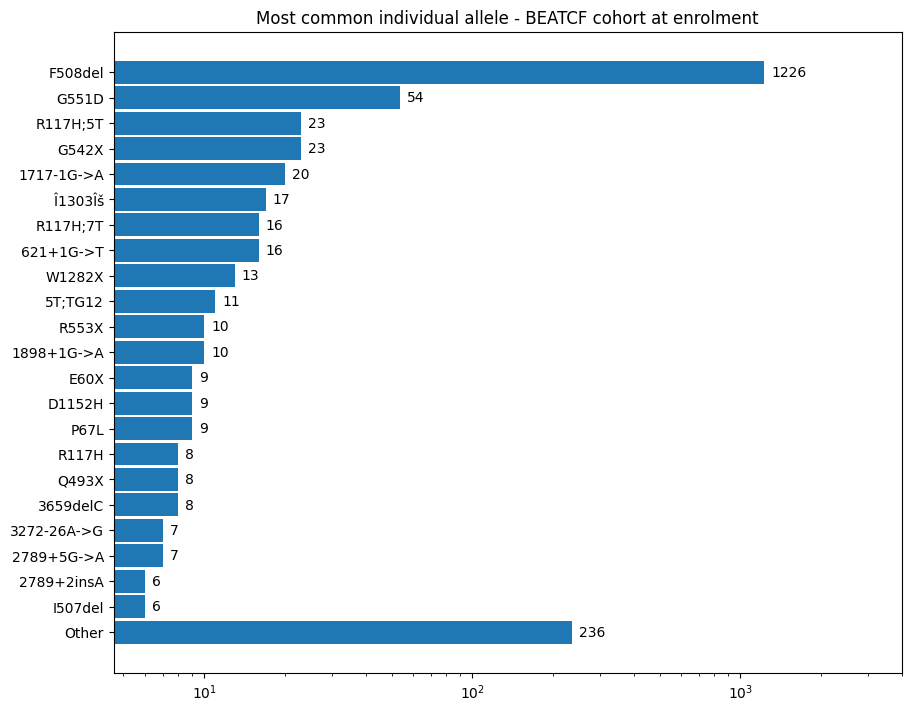

In [127]:
genotype_list = []
frequency_list = []

other_count = 0
for key in genotype_dic:
    if genotype_dic[key] > 5:
        genotype_list.append(key)
        frequency_list.append(genotype_dic[key])
    else:
        other_count = other_count + genotype_dic[key]
        
genotype_list.insert(0, "Other")
frequency_list.insert(0, other_count)

fig, ax1 = plt.subplots(figsize=(9, 7), layout='constrained')

ax1.set_title("Most common individual allele - BEATCF cohort at enrolment")

rects = ax1.barh(genotype_list, frequency_list, height=0.9, log=True, align='center')

ax1.bar_label(rects, frequency_list, padding=5, color='black')
ax1.set_xlim([0, 4000])

plt.savefig('BEATCF_genotype_distribution.png')

plt.show()

#### Contraindications

In [128]:
# Select the list of participants who have enroled before the cutoff date (1-7-2023)

sql_string = "select id, study_id, mrsa_status from microbiology_organism where organism_type = 2 and antibiotic_susceptibility_tested = 1 limit 2000000"
mycursor.execute(sql_string)
data = mycursor.fetchall()


In [129]:
antibiotic_type_other = []
for a in range (0, len(data)):
    micro_id = data[a][0]
    
    sql_string = "select * from microbiology_organism_antibiotic_susceptibility where microbiology_organism_id = {}".format(micro_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    
    for b in range (0, len(temp_data)):
        freetext = temp_data[b][3]
        if freetext != None:
            freetext = freetext.lower()
            if freetext not in antibiotic_type_other:
                antibiotic_type_other.append(freetext)

In [130]:
sql_string = """select A.study_id, A.Elexacaftor_tezacaftor_ivacaftor__Trikafta_, A.Ivacaftor__Kalydeco_, A.Lumacaftor_ivacaftor__Orkambi_, A.Tezacaftor_ivacaftor_and_ivacaftor__symdeko_, B.sweat_chlorine_level
FROM conmeds_paper_grouped A
INNER JOIN beatcf_enrolment_paper B
ON A.study_id = B.study_id
WHERE B.sweat_chlorine_level = 'CFTR modulator'"""
mycursor.execute(sql_string)
data = mycursor.fetchall()

ProgrammingError: 1054 (42S22): Unknown column 'B.sweat_chlorine_level' in 'field list'

In [ ]:
for a in range (0, len(data)):
    flag = 0
    if data[a][1] == 1:
        flag = flag + 1
    if data[a][2] == 1: 
        flag = flag + 1
    if data[a][3] == 1:
        flag = flag + 1
    if data[a][4] == 1: 
        flag = flag + 1
        
    if flag != 1:
        print(data[a][0], flag)

In [ ]:
sql_string = "select * from conmeds_paper_grouped where enrolment_date < '2023-07-01'"
mycursor.execute(sql_string)
data = mycursor.fetchall()

In [ ]:
count = 0
for a in range (0, len(data)):
    conmeds_count = 0
    for b in range (3, len(data[a]) - 1):
        conmeds_count = conmeds_count + data[a][b]
        
    if conmeds_count == 0:
        print(data[a][0])

##### Combining Mapping files into one integrated file

In [ ]:
# Read in Parveen's Microbiology_other file to classify other microbiology
bacteria_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\microbiology_bacteria_20Dec2023.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        bacteria_data.append(row)
        
# Create Bacteria Dictionary
bacteria_dic = {}
for a in range (1, len(bacteria_data)):
    bacteria_dic[bacteria_data[a][2]] = bacteria_data[a][4] #Assign freetext to final grouping
        
fungi_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\microbiology_fungi_20Dec2023.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        fungi_data.append(row)
        
fungi_dic = {}
for a in range (1, len(fungi_data)):
    fungi_dic[fungi_data[a][2]] = fungi_data[a][4] #Assign freetext to final grouping
        
virus_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\microbiology_virus_20Dec2023.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        virus_data.append(row)
        
virus_dic = {}
for a in range (1, len(virus_data)):
    virus_dic[virus_data[a][2]] = virus_data[a][4] #Assign freetext to final grouping
    
#Streptococcus additional classification
strep_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\Streptococcus_distinct_descriptions_PF_03april2024.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        strep_data.append(row)
        
strep_dic = {}
for a in range (1, len(strep_data)):
    if strep_data[a][0] == "NULL":
        organism_type_oth = None
    else:
        organism_type_oth = strep_data[a][0].lower()
        
    if strep_data[a][1] == "NULL":
        organism_description = None
    else:
        organism_description = strep_data[a][1].lower()
    
    strep_dic[(organism_type_oth, organism_description)] = strep_data[a][2]

# Read in Parveen's Microbiology_other file to classify other microbiology
micro_other_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology_other.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        micro_other_data.append(row)

micro_other_data_index = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology_other_index.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        micro_other_data_index.append(row)

In [ ]:
csv_list = []

# Group Freetext with their final groupings and org_type (Organism types: Bacteria / Virus / Fungi)

for a in range (1, len(micro_other_data)): # Ignore the headers from the CSV File
    free_text = micro_other_data[a][0].lower().replace("â\xa0", " ") # Convert to lowercase and remove special characters from double spacing
    genus_grouping = micro_other_data[a][1]
    organism_type = micro_other_data[a][2]
    final_grouping = micro_other_data[a][3]
        
    if organism_type == "Bacteria":
        final_grouping = bacteria_dic[genus_grouping]
    if organism_type == "Virus":
        final_grouping = virus_dic[genus_grouping]
    if organism_type == "Fungi":
        final_grouping = fungi_dic[genus_grouping.replace("Â\xa0","")]
                
    if final_grouping != "":
        csv_list.append([free_text, genus_grouping, organism_type, final_grouping])
        
for a in range (1, len(micro_other_data_index)): # Ignore the headers from CSV file
    
    organism_id = micro_other_data_index[a][0]
    
    if organism_id != "99" and organism_id != "199" and organism_id != "399" and organism_id != "":
    
        sql_string = """SELECT * FROM microbiology_organism_type WHERE id = '{}'""".format(organism_id)
        mycursor.execute(sql_string)
        tempdata = mycursor.fetchall()

        if len(tempdata) == 0:
            print(sql_string)
        
        genus_grouping = tempdata[0][1].lstrip(" ") + "_index"
        organism_type = micro_other_data_index[a][2]

        if organism_type == "Bacteria":
            final_grouping = bacteria_dic[genus_grouping]
        if organism_type == "Virus":
            final_grouping = virus_dic[genus_grouping]
        if organism_type == "Fungi":
            final_grouping = fungi_dic[genus_grouping.replace("Â\xa0","")]
            
        csv_list.append([organism_id, genus_grouping, organism_type, final_grouping])
        
csv_list = sorted(csv_list,key=lambda l:l[2])
csv_list = sorted(csv_list,key=lambda l:l[0])

In [160]:
csv_list

[['1', 'Pseudomonas_index', 'Bacteria', 'Pseudomonas species'],
 ['10', 'Mycobacterium_index', 'Bacteria', 'Mycobacterium species'],
 ['101', 'Adenovirus_index', 'Virus', 'Adenovirus'],
 ['102', 'Bocavirus_index', 'Virus', 'Virus other'],
 ['103', 'Coronavirus (not SARS-CoV-2)_index', 'Virus', 'Virus other'],
 ['104', 'Enterovirus_index', 'Virus', 'Enterovirus'],
 ['105', 'Influenza (type not specified)_index', 'Virus', 'Influenza '],
 ['106', 'Influenza type A_index', 'Virus', 'Influenza '],
 ['107', 'COVID-19 (SARS-CoV-2)_index', 'Virus', 'COVID-19'],
 ['108', 'Influenza type B_index', 'Virus', 'Influenza '],
 ['109', 'Metapneumovirus_index', 'Virus', 'Virus other'],
 ['11', 'Candida_index', 'Fungi', 'Candida species'],
 ['110', 'Parainfluenza (type not specified)_index', 'Virus', 'PIV'],
 ['111', 'Parainfluenza type 1_index', 'Virus', 'PIV'],
 ['112', 'Parainfluenza type 2_index', 'Virus', 'PIV'],
 ['113', 'Parainfluenza type 3_index', 'Virus', 'PIV'],
 ['114', 'Parainfluenza type 4

In [ ]:
bacteria_dic['Other bacteria_index'] = 'Bacteria Other'

In [ ]:
# field names
fields = ['Free Text', 'Genus', 'Type', 'Final Grouping']

# Specify the file name
filename = 'test.csv'
 
# Write the rows data to the CSV file with quotes around each field
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    csvwriter.writerows(csv_list)

In [ ]:
csv_list

In [159]:
micro_other_data_index

[['ï»¿', '', 'Organism type'],
 ['8', 'Acinetobacter', 'Bacteria'],
 ['101', 'Adenovirus', 'Virus'],
 ['7', 'Aspergillus', 'Fungi'],
 ['102', 'Bocavirus', 'Virus'],
 ['9', 'Burkholderia', 'Bacteria'],
 ['11', 'Candida', 'Fungi'],
 ['203', 'chlamydophila', 'Bacteria'],
 ['103', 'Coronavirus (not SARS-CoV-2)', 'Virus'],
 ['107', 'COVID-19 (SARS-CoV-2)', 'Virus'],
 ['104', 'Enterovirus', 'Virus'],
 ['4', 'Haemophilius', 'Bacteria'],
 ['105', 'Influenza (type not specified)', 'Virus'],
 ['106', 'Influenza type A', 'Virus'],
 ['108', 'Influenza type B', 'Virus'],
 ['202', 'legionella', 'Bacteria'],
 ['109', 'Metapneumovirus', 'Virus'],
 ['12', 'Mixed oral flora/URTF', 'Mixed'],
 ['10', 'Mycobacterium', 'Bacteria'],
 ['201', 'mycoplasma', 'Bacteria'],
 ['99', 'Other bacteria', 'Bacteria'],
 ['399', 'Other fungi', 'Fungi'],
 ['199', 'Other virus', 'Virus'],
 ['110', 'Parainfluenza (type not specified)', 'Virus'],
 ['111', 'Parainfluenza type 1', 'Virus'],
 ['112', 'Parainfluenza type 2', 'Vir